In [ ]:
# !wget https://www.dropbox.com/s/8noimh5qvij1o48/miniimagenet.zip?dl=0

In [ ]:
# !unzip miniimagenet.zip?dl=0

In [3]:
import joblib

In [4]:
import torch
from tqdm import tqdm

import os


from PIL import Image
import matplotlib.pyplot as plt

from torchvision import transforms
import random
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).')

In [ ]:
#!pip install tensorboardX

In [ ]:
#!pip install torch

In [ ]:
#!pip install torchmetrics

support_y : tensor([1, 3, 2, 0, 4])
query_y : tensor([0, 3, 4, 1, 2])


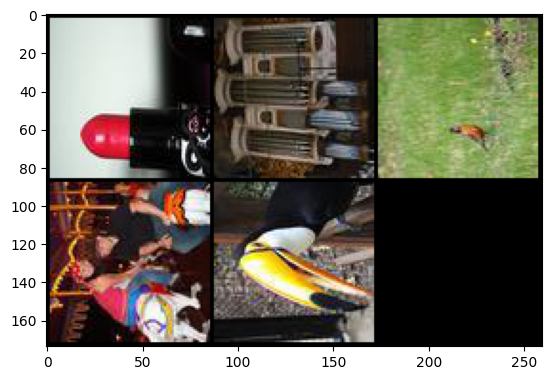

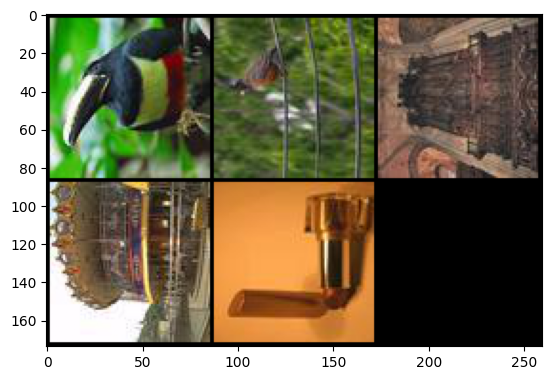

support_y : tensor([4, 2, 0, 3, 1])
query_y : tensor([2, 1, 0, 4, 3])


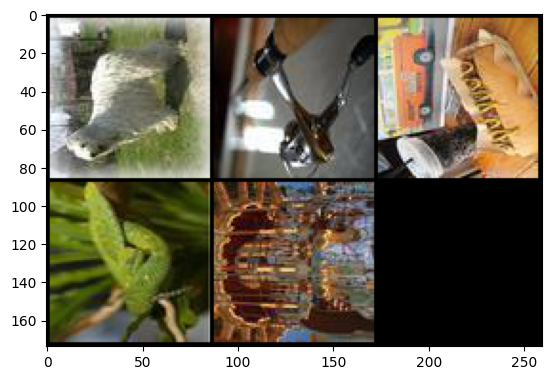

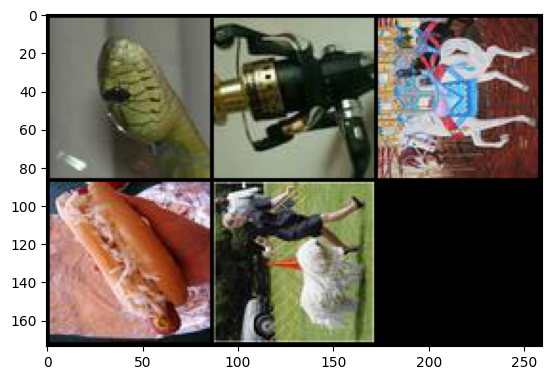

support_y : tensor([0, 2, 4, 3, 1])
query_y : tensor([0, 1, 2, 3, 4])


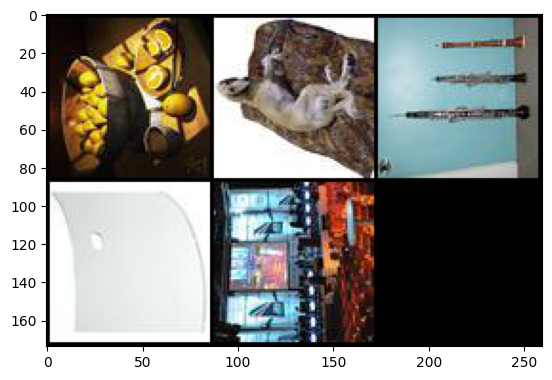

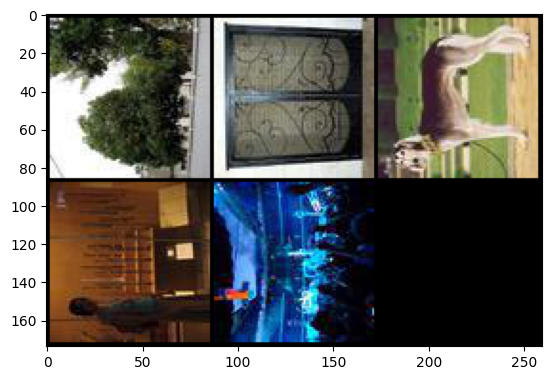

support_y : tensor([0, 4, 3, 1, 2])
query_y : tensor([3, 4, 1, 0, 2])


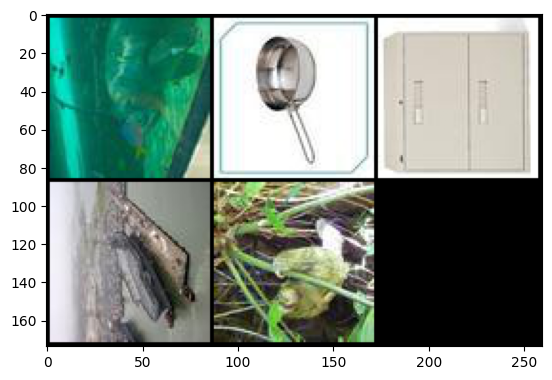

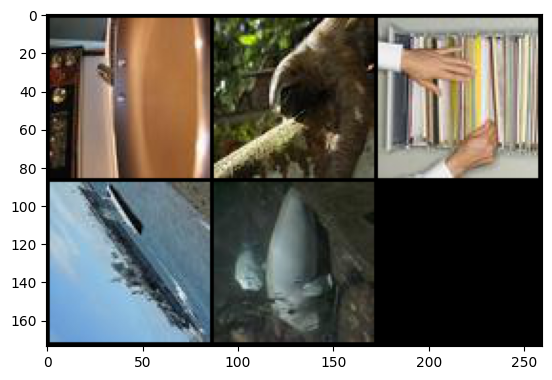

support_y : tensor([4, 0, 1, 2, 3])
query_y : tensor([4, 1, 2, 3, 0])


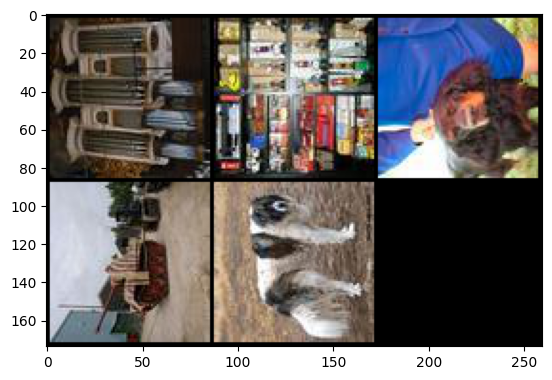

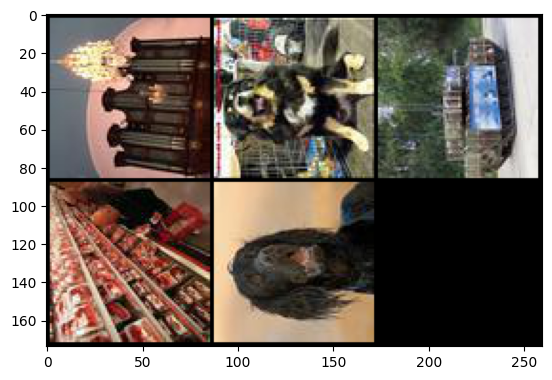

In [ ]:

class MiniImagenet():
    '''
    main_return: give task to use we have 3 task = {train,val,test}
    
        put mini-imagenet files as :
    root/miniimagenet :
        |- data/name_class/*.jpg includes all imgeas
        |- splits/ravi-larochelle/train.txt
        |- splits/ravi-larochelle/test.txt
        |- splits/ravi-larochelle/val.txt
    NOTICE: meta-learning is different from general supervised learning, especially the concept of batch and set.
    batch: contains several sets
    sets: conains n_way * k_shot for meta-train set, n_way * n_query for meta-test set.


    '''
    def __init__(self, root='miniimagenet/', mode='train', n_way=5, k_shot=5, k_query=10,resize=84,
                 transforms_normalization=transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))):
        self.root = root
        self.mode = mode
        self.n_way = n_way
        self.k_shot = k_shot
        self.k_query = k_query
        self.resize = resize

        if transforms_normalization is None:
          self.transform = transforms.Compose([
              transforms.Resize((resize,resize)),
              transforms.ToTensor(),
          ])
        else :
          self.transform = transforms.Compose([
              transforms.Resize((resize,resize)),
              transforms.ToTensor(),
              transforms_normalization
          ])
          
        self.data_folder = os.path.join(root, 'data')
        with open(os.path.join(root, 'splits/ravi-larochelle', f'{mode}.txt')) as file:
            self.calsses_mode_name = [line.strip().split(',') for line in file.readlines()]


    
    def one_task(self):

        list_of_support = []
        list_labels_support = []
        list_of_query = []
        list_labels_query = []

        random_classes_name,_ = self.shuffeling(self.calsses_mode_name, self.n_way)
        number_of_samples_for_each_class = self.k_shot+self.k_query
        
        for index,name_folder_image_in_list in enumerate(random_classes_name):
            name_folder_image = name_folder_image_in_list[0]

            images = os.listdir(os.path.join(self.data_folder, name_folder_image))
            
            selected_images,_ = self.shuffeling(images,number_of_samples_for_each_class)
            
            all_images = [self.transform(Image.open(os.path.join(self.data_folder, name_folder_image, sample_image))).unsqueeze(0) 
            for sample_image in selected_images]
            
            list_of_support.extend(all_images[:self.k_shot])
            class_labels_support = [index for _ in range(self.k_shot)]
            list_labels_support+=class_labels_support

            list_of_query.extend(all_images[self.k_shot:])
            class_labels_query =  [index for _ in range(self.k_query)]
            list_labels_query.extend(class_labels_query)
        
        random_list_of_support,random_list_labels_support = self.shuffeling(list_of_support,len(list_of_support),list_labels_support)
        random_list_of_query ,random_list_labels_query = self.shuffeling(list_of_query,len(list_of_query),list_labels_query)
        
        support_x =torch.cat(random_list_of_support, 0)
        support_y =  torch.LongTensor(random_list_labels_support)
        query_x = torch.cat(random_list_of_query, 0)
        query_y = torch.LongTensor(random_list_labels_query)

        return support_x, support_y, query_x, query_y 
    
    
    def list_of_task(self, batch):
        return [(self.one_task()) for _ in range(batch)]


    def shuffeling(self,list_item,number_of_samples,list_item2=None):
          index_random = random.sample(range(len(list_item)),number_of_samples)
          new_list = [list_item[index] for index in index_random]

          if list_item2 is not None:
              list_item2 = [list_item2[index] for index in index_random]
          return new_list,list_item2
    

if __name__ == '__main__':

    from torchvision.utils import make_grid
    from matplotlib import pyplot as plt
    from tensorboardX import SummaryWriter
    import time


    train = MiniImagenet(n_way=5, k_shot=1, k_query=1,transforms_normalization=None)
    list_of_tasks = train.list_of_task(5)

    plt.ion()
    tb = SummaryWriter('runs', 'mini-imagenet')

    for i, set_ in enumerate(list_of_tasks):
        # support_x: [k_shot*n_way, 3, 84, 84]
        support_x, support_y, query_x, query_y = set_
        support_x = make_grid(support_x, nrow=2)
        query_x = make_grid(query_x, nrow=2)

        print(f'support_y : {support_y}')
        print(f'query_y : {query_y}')

        plt.figure(1)
        plt.imshow(support_x.transpose(2, 0).numpy())
        plt.pause(0.5)
        plt.figure(2)
        tb.add_image('support_x : ', support_x)
        plt.imshow(query_x.transpose(2, 0).numpy())
        plt.pause(0.5)
        tb.add_image('query_x', query_x)
        




In [ ]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score
import copy
import torch
Epochs = 20000
save_epoch = 200
# from warnings import filterwarnings
# filterwarnings(action='ignore', category=DeprecationWarning, message='`np.int` is a deprecated alias for the builtin `int`')

In [5]:
#from MLclf import MLclf
import torchvision.transforms as transforms
import math
import os
import time
import json
import logging
from torch.utils.data import Dataset
import numpy as np
import collections
from PIL import Image
import csv

import torch.nn as nn

from collections import OrderedDict

import torch.nn.functional as F
from tqdm import tqdm

import re
import warnings




# Download the original mini-imagenet data:
#MLclf.miniimagenet_download(Download=True) # only need to run this line before you download the mini-imagenet dataset for the first time.


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [7]:
def plot_losses(history,name_model):
    losses_val = [x['val_loss'] for x in history['val']]
    losses_train = [x['train_loss'] for x in history['train']]

    plt.plot(losses_val, '-x')
    plt.plot(losses_train,'-o')
    plt.legend(["test_loss", "train_loss"], loc ="lower right")

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(f'Loss vs. No. of epochs {name_model}');

In [6]:
def plot_f1(history,name_model):
    losses_val = [x['val_F1'] for x in history['val']]
    losses_train = [x['train_F1'] for x in history['train']]

    plt.plot(losses_val, '-x')
    plt.plot(losses_train,'-o')
    plt.legend(["test_f1", "train_f1"], loc ="lower right")

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(f'Loss vs. No. of epochs {name_model}');

In [8]:
def plot_accuracies(history,name_model):
    accuracies_train = [x['val_acc'] for x in history['val']]
    accuracies_test = [x['train_acc'] for x in history['train']]
    plt.plot(accuracies_train, '-x')
    plt.plot(accuracies_test, '-o')
    plt.legend(["test_acc", "train_acc"], loc ="lower right")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title(f'Accuracy vs. No. of epochs {name_model}');

In [ ]:

class MetaModule(nn.Module):
    """
    Base class for PyTorch meta-learning modules. These modules accept an
    additional argument `params` in their `forward` method.
    Notes
    -----
    Objects inherited from `MetaModule` are fully compatible with PyTorch
    modules from `torch.nn.Module`. The argument `params` is a dictionary of
    tensors, with full support of the computation graph (for differentiation).
    """
    def __init__(self):
        super(MetaModule, self).__init__()
        self._children_modules_parameters_cache = dict()

    def meta_named_parameters(self, prefix='', recurse=True):
        gen = self._named_members(
            lambda module: module._parameters.items()
            if isinstance(module, MetaModule) else [],
            prefix=prefix, recurse=recurse)
        for elem in gen:
            yield elem

    def meta_parameters(self, recurse=True):
        for name, param in self.meta_named_parameters(recurse=recurse):
            yield param

    def get_subdict(self, params, key=None):
        if params is None:
            return None

        all_names = tuple(params.keys())
        if (key, all_names) not in self._children_modules_parameters_cache:
            if key is None:
                self._children_modules_parameters_cache[(key, all_names)] = all_names

            else:
                key_escape = re.escape(key)
                key_re = re.compile(r'^{0}\.(.+)'.format(key_escape))

                self._children_modules_parameters_cache[(key, all_names)] = [
                    key_re.sub(r'\1', k) for k in all_names if key_re.match(k) is not None]

        names = self._children_modules_parameters_cache[(key, all_names)]
        if not names:
            warnings.warn('Module `{0}` has no parameter corresponding to the '
                          'submodule named `{1}` in the dictionary `params` '
                          'provided as an argument to `forward()`. Using the '
                          'default parameters for this submodule. The list of '
                          'the parameters in `params`: [{2}].'.format(
                          self.__class__.__name__, key, ', '.join(all_names)),
                          stacklevel=2)
            return None

        return OrderedDict([(name, params[f'{key}.{name}']) for name in names])

In [ ]:
def gradient_update_parameters(model,
                               loss,
                               params=None,
                               step_size=0.5,
                               first_order=False):
    """Update of the meta-parameters with one step of gradient descent on the
    loss function.
    Parameters
    ----------
    model : `torchmeta.modules.MetaModule` instance
        The model.
    loss : `torch.Tensor` instance
        The value of the inner-loss. This is the result of the training dataset
        through the loss function.
    params : `collections.OrderedDict` instance, optional
        Dictionary containing the meta-parameters of the model. If `None`, then
        the values stored in `model.meta_named_parameters()` are used. This is
        useful for running multiple steps of gradient descent as the inner-loop.
    step_size : int, `torch.Tensor`, or `collections.OrderedDict` instance (default: 0.5)
        The step size in the gradient update. If an `OrderedDict`, then the
        keys must match the keys in `params`.
    first_order : bool (default: `False`)
        If `True`, then the first order approximation of MAML is used.
    Returns
    -------
    updated_params : `collections.OrderedDict` instance
        Dictionary containing the updated meta-parameters of the model, with one
        gradient update wrt. the inner-loss.
    """
    if not isinstance(model, MetaModule):
        raise ValueError('The model must be an instance of `torchmeta.modules.'
                         'MetaModule`, got `{0}`'.format(type(model)))

    if params is None:
        params = OrderedDict(model.meta_named_parameters())

    grads = torch.autograd.grad(loss,
                                params.values(),
                                create_graph=not first_order)

    updated_params = OrderedDict()

    if isinstance(step_size, (dict, OrderedDict)):
        for (name, param), grad in zip(params.items(), grads):
            updated_params[name] = param - step_size[name] * grad

    else:
        for (name, param), grad in zip(params.items(), grads):
            updated_params[name] = param - step_size * grad

    return updated_params

In [ ]:
class MetaSequential(nn.Sequential, MetaModule):
    __doc__ = nn.Sequential.__doc__

    def forward(self, input, params=None):
        for name, module in self._modules.items():
            if isinstance(module, MetaModule):
                input = module(input, params=self.get_subdict(params, name))
            elif isinstance(module, nn.Module):
                input = module(input)
            else:
                raise TypeError('The module must be either a torch module '
                    '(inheriting from `nn.Module`), or a `MetaModule`. '
                    'Got type: `{0}`'.format(type(module)))
        return input

In [ ]:
class MetaConv2d(nn.Conv2d, MetaModule):
    __doc__ = nn.Conv2d.__doc__

    def forward(self, input, params=None):
        if params is None:
            params = OrderedDict(self.named_parameters())
        bias = params.get('bias', None)
        return self._conv_forward(input, params['weight'], bias)

In [ ]:
def conv_block(in_channels, out_channels, **kwargs):
    return MetaSequential(OrderedDict([
        ('conv', MetaConv2d(in_channels, out_channels, **kwargs)),
        ('norm', nn.BatchNorm2d(out_channels, momentum=1.,
            track_running_stats=False)),
        ('relu', nn.ReLU()),
        ('pool', nn.MaxPool2d(2))
    ]))

In [ ]:
class MetaLinear(nn.Linear, MetaModule):
    __doc__ = nn.Linear.__doc__

    def forward(self, input, params=None):
        if params is None:
            params = OrderedDict(self.named_parameters())
        bias = params.get('bias', None)
        return F.linear(input, params['weight'], bias)


In [ ]:
class MetaConvModel(MetaModule):
    """4-layer Convolutional Neural Network architecture from [1].
    Parameters
    ----------
    in_channels : int
        Number of channels for the input images.
    out_features : int
        Number of classes (output of the model).
    hidden_size : int (default: 64)
        Number of channels in the intermediate representations.
    feature_size : int (default: 64)
        Number of features returned by the convolutional head.
    References
    ----------
    .. [1] Finn C., Abbeel P., and Levine, S. (2017). Model-Agnostic Meta-Learning
           for Fast Adaptation of Deep Networks. International Conference on
           Machine Learning (ICML) (https://arxiv.org/abs/1703.03400)
    """
    def __init__(self, in_channels, out_features, hidden_size=64, feature_size=64):
        super(MetaConvModel, self).__init__()
        self.in_channels = in_channels
        self.out_features = out_features
        self.hidden_size = hidden_size
        self.feature_size = feature_size

        self.features = MetaSequential(OrderedDict([
            ('layer1', conv_block(in_channels, hidden_size, kernel_size=3,
                                  stride=1, padding=1, bias=True)),
            ('layer2', conv_block(hidden_size, hidden_size, kernel_size=3,
                                  stride=1, padding=1, bias=True)),
            ('layer3', conv_block(hidden_size, hidden_size, kernel_size=3,
                                  stride=1, padding=1, bias=True)),
            ('layer4', conv_block(hidden_size, hidden_size, kernel_size=3,
                                  stride=1, padding=1, bias=True))
        ]))
        
        
        self.classifier = MetaLinear(feature_size, out_features, bias=True)

    def forward(self, inputs, params=None):
        features = self.features(inputs, params=self.get_subdict(params, 'features'))
        features = features.view((features.size(0), -1))
        logits = self.classifier(features, params=self.get_subdict(params, 'classifier'))
        return logits

In [ ]:
def ModelConvMiniImagenet(out_features, hidden_size=32):
    return MetaConvModel(3, out_features, hidden_size=hidden_size,
                         feature_size=5 * 5 * hidden_size)
# def ModelConvMiniImagenet(out_features, hidden_size=64):
#     return MetaConvModel(3, out_features, hidden_size=hidden_size,
#                          feature_size=10 * 10 * hidden_size)

In [ ]:
__all__ = ['ModelAgnosticMetaLearning', 'MAML', 'FOMAML']


class ModelAgnosticMetaLearning(object):
    
    
    def __init__(self, model,number_task,f1_score,inner_lr,outer_lr,opt_func,device,first_order,
                scheduler=None):
        self.model = model.to(device=device)
        self.lr_outer = outer_lr
        self.lr_inner = inner_lr
        self.device = device
        self.optimizer = opt_func(model.parameters(), self.lr_outer,weight_decay=0.0005)
        self.first_order = first_order
        self.num_adaptation_steps_train = 5
        self.num_adaption_stepss_val = 10
        if scheduler is not None:
          self.scheduler = scheduler(self.optimizer, gamma=0.9)
        else :
          self.scheduler = scheduler
          
        self.loss_function = F.cross_entropy
        self.number_task = number_task
        self.f1_calculate = f1_score



    def adapt(self, inputs, targets,num_adaptation_steps_train,first_order=False):
        
        params = None


        for step in range(num_adaptation_steps_train):
            logits = self.model(inputs, params=params)

            inner_loss = self.loss_function(logits, targets)

            self.model.zero_grad()
            params = gradient_update_parameters(self.model, inner_loss,
                step_size=self.lr_inner, params=params,
                first_order=(not self.model.training) or first_order)

        return params

    def train(self, mini,ep,save_item):
            train_res = {}
            acc = 0.
            f1 = 0.

            self.optimizer.zero_grad()
            mean_outer_loss = torch.tensor(0.)
            mean_outer_loss = mean_outer_loss.to(self.device)
            for i, set_train in enumerate(mini):                
                    # print(set_train)
                    support_x, support_y, query_x, query_y = set_train
                    
                    support_x = support_x.to(self.device)
                    support_y = support_y.to(self.device)
                    # print(self.device)
                    query_x = query_x.to(self.device)
                    query_y = query_y.to(self.device)

                    params = self.adapt(support_x, support_y,self.num_adaptation_steps_train,self.first_order)
                    with torch.set_grad_enabled(self.model.training):
                        test_logits = self.model(query_x, params=params)
                        if ep%save_item ==0:
                                  acc += accuracy(test_logits, query_y)
                                  _, preds = torch.max(test_logits, dim=1)
                                  f1 = f1+self.f1_calculate(preds.cpu(),query_y.cpu())
                        query_y.to(self.device)
                        test_logits.to(self.device)
                        outer_loss = self.loss_function(test_logits, query_y)
                        mean_outer_loss += outer_loss

            mean_outer_loss.div_(self.number_task)
            
            if ep%save_item ==0:
                  loss_train = mean_outer_loss.item()
                  acc = acc/self.number_task
                  f1 = f1/self.number_task
                  print(f"train_loss : {loss_train:.2f} train_acc : {acc:.4f} train_F1: {f1:.4f}")
                  train_res ={'train_loss': loss_train, 'train_acc': acc,'train_F1':f1}

            mean_outer_loss.backward()
            self.optimizer.step()

            if self.scheduler is not None:
                    self.scheduler.step()

            return train_res

    def evaluate(self, mini_val):
        
        mean_accuracy, mean_f1 = 0., 0.
        mean_outer_loss = torch.tensor(0.)
        mean_outer_loss = mean_outer_loss.to(self.device)

        machine = copy.deepcopy(self.model)
        self.model.eval()

        for i, set_val in enumerate(mini_val):
                
                count = i
                support_x, support_y, query_x, query_y = set_val
                loss_val,acc_val,f1 = self.evaluate_task(support_x, support_y, query_x, query_y)
                mean_outer_loss += loss_val
                mean_accuracy +=acc_val
                mean_f1 += f1

        mean_outer_loss.div_(count)
        mean_accuracy =mean_accuracy/count
        mean_f1 = mean_f1/count
        print(f"val_loss : {mean_outer_loss.item():.2f} val_acc : {mean_accuracy:.4f} val_F1: {mean_f1:.4f}")
        resut ={'val_loss': mean_outer_loss.item(), 'val_acc': mean_accuracy,'val_F1':mean_f1}

        self.model = machine
        return resut

    def evaluate_task(self, support_x, support_y, query_x, query_y):
                    
        f1 = 0.
        x_spt = support_x.to(self.device)
        y_spt = support_y.to(self.device)
        x_qry = query_x.to(self.device)
        y_qry = query_y.to(self.device)
        params = self.adapt(x_spt, y_spt,self.num_adaption_stepss_val,self.first_order)
        with torch.set_grad_enabled(self.model.training):
                test_logits = self.model(x_qry, params=params)
                outer_loss = self.loss_function(test_logits, y_qry)
                acc = accuracy(test_logits, y_qry)
                _, preds = torch.max(test_logits, dim=1)      
                f1 = self.f1_calculate(y_qry.cpu(), preds.cpu())

                return outer_loss, acc,f1


MAML = ModelAgnosticMetaLearning


In [ ]:
from torchmetrics.classification import MulticlassF1Score


def train_F_maml(epoch,number_task,n_way,k_shot,k_query,save_item,Fomaml,scheduler):

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    # print(device)
    train = MiniImagenet(mode='train',n_way=n_way,k_shot=k_shot,k_query=k_query)
    val = MiniImagenet(mode='test',n_way=n_way,k_shot=k_shot,k_query=k_query)

    model_base = ModelConvMiniImagenet(n_way,32)
    history = {'train':[],'val':[]}
    opt_func=torch.optim.SGD
    inner_lr=0.01
    outer_lr = 0.01
    save_item = save_item
    f1 = MulticlassF1Score(num_classes=n_way,average = 'macro')
    metalearner = ModelAgnosticMetaLearning(model_base,number_task,f1,inner_lr,outer_lr,opt_func,
                                            device,first_order=Fomaml,scheduler=scheduler)
    for ep in tqdm(range(epoch)):

        res = metalearner.train(train.list_of_task(number_task),ep,save_item)
        

        if ep%save_item == 0 :
            history['train'].append(res)
            res_val = metalearner.evaluate(val.list_of_task(number_task)) 
            history['val'].append(res_val)         
            print("#####################################################################################")

    return history,metalearner


In [ ]:
# return of model.evaluate {'val_loss': mean_outer_loss.item(), 'val_acc': mean_accuracy,'val_F1':mean_f1}

def test_F_maml(model,repid,number_task,n_way,k_shot,k_query):

    all_loss = 0.
    all_acc = 0.
    all_f1 = 0.
    test = MiniImagenet(mode='test',n_way=n_way,k_shot=k_shot,k_query=k_query)
    for _ in range(repid):
            res_val = model.evaluate(test.list_of_task(number_task)) 
            all_loss += res_val['val_loss']
            all_acc += res_val['val_acc']
            all_f1  += res_val['val_F1']
    return (all_loss/repid,all_acc/repid,all_f1/repid)

In [ ]:
Fomaml = False
# scheduler = torch.optim.lr_scheduler.ExponentialLR
scheduler = None
history,model_5_way_shot_1_maml = train_F_maml(Epochs,4,5,1,10,save_epoch,Fomaml,scheduler)

  0%|          | 1/20000 [00:01<6:04:26,  1.09s/it]

train_loss : 1.57 train_acc : 0.3200 train_F1: 0.2969
val_loss : 2.20 val_acc : 0.3733 val_F1: 0.3413
#####################################################################################


  1%|          | 201/20000 [00:23<46:57,  7.03it/s]

train_loss : 1.58 train_acc : 0.2750 train_F1: 0.2557
val_loss : 2.06 val_acc : 0.4067 val_F1: 0.3690
#####################################################################################


  2%|▏         | 401/20000 [00:46<46:23,  7.04it/s]

train_loss : 1.66 train_acc : 0.2200 train_F1: 0.2136
val_loss : 2.25 val_acc : 0.3600 val_F1: 0.3124
#####################################################################################


  3%|▎         | 601/20000 [01:09<45:30,  7.10it/s]

train_loss : 1.64 train_acc : 0.2850 train_F1: 0.2723
val_loss : 2.26 val_acc : 0.3533 val_F1: 0.3064
#####################################################################################


  4%|▍         | 801/20000 [01:32<44:43,  7.15it/s]

train_loss : 1.62 train_acc : 0.3200 train_F1: 0.2881
val_loss : 2.01 val_acc : 0.4467 val_F1: 0.4359
#####################################################################################


  5%|▌         | 1001/20000 [01:54<44:09,  7.17it/s]

train_loss : 1.62 train_acc : 0.3350 train_F1: 0.3263
val_loss : 2.25 val_acc : 0.3667 val_F1: 0.3286
#####################################################################################


  6%|▌         | 1201/20000 [02:17<43:29,  7.20it/s]

train_loss : 1.67 train_acc : 0.2350 train_F1: 0.2193
val_loss : 2.13 val_acc : 0.4133 val_F1: 0.3736
#####################################################################################


  7%|▋         | 1401/20000 [02:39<43:51,  7.07it/s]

train_loss : 1.64 train_acc : 0.2400 train_F1: 0.2321
val_loss : 2.07 val_acc : 0.4467 val_F1: 0.4187
#####################################################################################


  8%|▊         | 1601/20000 [03:02<43:36,  7.03it/s]

train_loss : 1.57 train_acc : 0.3000 train_F1: 0.3015
val_loss : 2.23 val_acc : 0.3467 val_F1: 0.3321
#####################################################################################


  9%|▉         | 1801/20000 [03:25<43:27,  6.98it/s]

train_loss : 1.58 train_acc : 0.2950 train_F1: 0.2807
val_loss : 2.18 val_acc : 0.4000 val_F1: 0.3783
#####################################################################################


 10%|█         | 2001/20000 [03:47<43:03,  6.97it/s]

train_loss : 1.61 train_acc : 0.2350 train_F1: 0.2145
val_loss : 2.32 val_acc : 0.3000 val_F1: 0.2747
#####################################################################################


 11%|█         | 2201/20000 [04:10<41:26,  7.16it/s]

train_loss : 1.63 train_acc : 0.2750 train_F1: 0.2445
val_loss : 2.22 val_acc : 0.3467 val_F1: 0.3273
#####################################################################################


 12%|█▏        | 2401/20000 [04:33<40:55,  7.17it/s]

train_loss : 1.57 train_acc : 0.2650 train_F1: 0.2519
val_loss : 2.25 val_acc : 0.3400 val_F1: 0.3251
#####################################################################################


 13%|█▎        | 2601/20000 [04:55<40:41,  7.13it/s]

train_loss : 1.52 train_acc : 0.3300 train_F1: 0.3110
val_loss : 2.15 val_acc : 0.3800 val_F1: 0.3413
#####################################################################################


 14%|█▍        | 2801/20000 [05:18<40:15,  7.12it/s]

train_loss : 1.61 train_acc : 0.2600 train_F1: 0.2283
val_loss : 2.13 val_acc : 0.3600 val_F1: 0.3414
#####################################################################################


 15%|█▌        | 3001/20000 [05:41<40:00,  7.08it/s]

train_loss : 1.58 train_acc : 0.3250 train_F1: 0.3036
val_loss : 2.16 val_acc : 0.3400 val_F1: 0.3169
#####################################################################################


 16%|█▌        | 3201/20000 [06:04<40:11,  6.97it/s]

train_loss : 1.62 train_acc : 0.2550 train_F1: 0.2321
val_loss : 2.11 val_acc : 0.4200 val_F1: 0.4115
#####################################################################################


 17%|█▋        | 3401/20000 [06:27<39:18,  7.04it/s]

train_loss : 1.64 train_acc : 0.2300 train_F1: 0.2154
val_loss : 2.24 val_acc : 0.3000 val_F1: 0.2767
#####################################################################################


 18%|█▊        | 3601/20000 [06:49<37:39,  7.26it/s]

train_loss : 1.62 train_acc : 0.2750 train_F1: 0.2668
val_loss : 2.18 val_acc : 0.3667 val_F1: 0.3314
#####################################################################################


 19%|█▉        | 3801/20000 [07:12<37:21,  7.23it/s]

train_loss : 1.63 train_acc : 0.3050 train_F1: 0.2919
val_loss : 2.12 val_acc : 0.3600 val_F1: 0.3328
#####################################################################################


 20%|██        | 4001/20000 [07:34<36:52,  7.23it/s]

train_loss : 1.65 train_acc : 0.2600 train_F1: 0.2472
val_loss : 2.16 val_acc : 0.3667 val_F1: 0.3187
#####################################################################################


 21%|██        | 4201/20000 [07:57<36:20,  7.24it/s]

train_loss : 1.57 train_acc : 0.3000 train_F1: 0.2888
val_loss : 2.24 val_acc : 0.2933 val_F1: 0.2564
#####################################################################################


 22%|██▏       | 4401/20000 [08:20<36:38,  7.09it/s]

train_loss : 1.53 train_acc : 0.3450 train_F1: 0.3176
val_loss : 2.22 val_acc : 0.3000 val_F1: 0.2825
#####################################################################################


 23%|██▎       | 4601/20000 [08:42<36:14,  7.08it/s]

train_loss : 1.64 train_acc : 0.2800 train_F1: 0.2603
val_loss : 2.25 val_acc : 0.3600 val_F1: 0.3375
#####################################################################################


 24%|██▍       | 4801/20000 [09:05<36:24,  6.96it/s]

train_loss : 1.66 train_acc : 0.2650 train_F1: 0.2472
val_loss : 2.22 val_acc : 0.3467 val_F1: 0.3210
#####################################################################################


 25%|██▌       | 5001/20000 [09:28<36:00,  6.94it/s]

train_loss : 1.62 train_acc : 0.2600 train_F1: 0.2418
val_loss : 2.20 val_acc : 0.3533 val_F1: 0.3249
#####################################################################################


 26%|██▌       | 5201/20000 [09:51<34:33,  7.14it/s]

train_loss : 1.67 train_acc : 0.2800 train_F1: 0.2615
val_loss : 2.17 val_acc : 0.3533 val_F1: 0.3218
#####################################################################################


 27%|██▋       | 5401/20000 [10:14<34:50,  6.98it/s]

train_loss : 1.60 train_acc : 0.2950 train_F1: 0.2725
val_loss : 2.19 val_acc : 0.3133 val_F1: 0.2763
#####################################################################################


 28%|██▊       | 5601/20000 [10:37<34:13,  7.01it/s]

train_loss : 1.71 train_acc : 0.2500 train_F1: 0.2307
val_loss : 2.17 val_acc : 0.3467 val_F1: 0.3259
#####################################################################################


 29%|██▉       | 5801/20000 [11:00<33:26,  7.08it/s]

train_loss : 1.62 train_acc : 0.3050 train_F1: 0.2779
val_loss : 2.23 val_acc : 0.3333 val_F1: 0.2998
#####################################################################################


 30%|███       | 6001/20000 [11:23<33:33,  6.95it/s]

train_loss : 1.66 train_acc : 0.2900 train_F1: 0.2784
val_loss : 2.08 val_acc : 0.4200 val_F1: 0.3917
#####################################################################################


 31%|███       | 6201/20000 [11:47<35:14,  6.53it/s]

train_loss : 1.55 train_acc : 0.2950 train_F1: 0.2708
val_loss : 2.25 val_acc : 0.3133 val_F1: 0.2649
#####################################################################################


 32%|███▏      | 6401/20000 [12:10<32:59,  6.87it/s]

train_loss : 1.58 train_acc : 0.3150 train_F1: 0.3115
val_loss : 2.14 val_acc : 0.4133 val_F1: 0.3842
#####################################################################################


 33%|███▎      | 6601/20000 [12:33<31:47,  7.02it/s]

train_loss : 1.59 train_acc : 0.2700 train_F1: 0.2736
val_loss : 2.20 val_acc : 0.3600 val_F1: 0.3106
#####################################################################################


 34%|███▍      | 6801/20000 [12:56<31:16,  7.03it/s]

train_loss : 1.56 train_acc : 0.3200 train_F1: 0.3015
val_loss : 2.26 val_acc : 0.2800 val_F1: 0.2533
#####################################################################################


 35%|███▌      | 7001/20000 [13:19<31:06,  6.97it/s]

train_loss : 1.63 train_acc : 0.3050 train_F1: 0.2783
val_loss : 2.15 val_acc : 0.3333 val_F1: 0.3228
#####################################################################################


 36%|███▌      | 7201/20000 [13:42<30:31,  6.99it/s]

train_loss : 1.55 train_acc : 0.2650 train_F1: 0.2437
val_loss : 2.19 val_acc : 0.3200 val_F1: 0.2977
#####################################################################################


 37%|███▋      | 7401/20000 [14:05<29:23,  7.14it/s]

train_loss : 1.52 train_acc : 0.3400 train_F1: 0.3292
val_loss : 2.12 val_acc : 0.3533 val_F1: 0.3077
#####################################################################################


 38%|███▊      | 7601/20000 [14:28<29:42,  6.96it/s]

train_loss : 1.71 train_acc : 0.2350 train_F1: 0.2281
val_loss : 2.10 val_acc : 0.4000 val_F1: 0.3918
#####################################################################################


 39%|███▉      | 7801/20000 [14:51<29:22,  6.92it/s]

train_loss : 1.56 train_acc : 0.2950 train_F1: 0.2785
val_loss : 2.11 val_acc : 0.4000 val_F1: 0.3720
#####################################################################################


 40%|████      | 8001/20000 [15:14<27:59,  7.14it/s]

train_loss : 1.67 train_acc : 0.2450 train_F1: 0.2294
val_loss : 2.09 val_acc : 0.4133 val_F1: 0.3852
#####################################################################################


 41%|████      | 8201/20000 [15:37<28:22,  6.93it/s]

train_loss : 1.51 train_acc : 0.3050 train_F1: 0.2946
val_loss : 2.16 val_acc : 0.3867 val_F1: 0.3754
#####################################################################################


 42%|████▏     | 8401/20000 [16:00<27:27,  7.04it/s]

train_loss : 1.59 train_acc : 0.2800 train_F1: 0.2615
val_loss : 2.11 val_acc : 0.4067 val_F1: 0.3626
#####################################################################################


 43%|████▎     | 8601/20000 [16:23<26:41,  7.12it/s]

train_loss : 1.68 train_acc : 0.2050 train_F1: 0.1885
val_loss : 2.11 val_acc : 0.4067 val_F1: 0.3765
#####################################################################################


 44%|████▍     | 8801/20000 [16:46<26:40,  7.00it/s]

train_loss : 1.52 train_acc : 0.3650 train_F1: 0.3492
val_loss : 2.16 val_acc : 0.3200 val_F1: 0.3235
#####################################################################################


 45%|████▌     | 9001/20000 [17:09<26:18,  6.97it/s]

train_loss : 1.48 train_acc : 0.3850 train_F1: 0.3729
val_loss : 2.30 val_acc : 0.3133 val_F1: 0.3000
#####################################################################################


 46%|████▌     | 9201/20000 [17:32<25:07,  7.16it/s]

train_loss : 1.43 train_acc : 0.3950 train_F1: 0.3690
val_loss : 2.16 val_acc : 0.3667 val_F1: 0.3492
#####################################################################################


 47%|████▋     | 9401/20000 [17:55<25:17,  6.99it/s]

train_loss : 1.58 train_acc : 0.3000 train_F1: 0.2932
val_loss : 2.07 val_acc : 0.4400 val_F1: 0.4086
#####################################################################################


 48%|████▊     | 9601/20000 [18:18<24:36,  7.04it/s]

train_loss : 1.55 train_acc : 0.3350 train_F1: 0.3089
val_loss : 2.20 val_acc : 0.3800 val_F1: 0.3397
#####################################################################################


 49%|████▉     | 9801/20000 [18:41<24:35,  6.91it/s]

train_loss : 1.60 train_acc : 0.2750 train_F1: 0.2490
val_loss : 2.21 val_acc : 0.2733 val_F1: 0.2530
#####################################################################################


 50%|█████     | 10001/20000 [19:05<24:02,  6.93it/s]

train_loss : 1.60 train_acc : 0.2400 train_F1: 0.2274
val_loss : 2.22 val_acc : 0.3467 val_F1: 0.3322
#####################################################################################


 51%|█████     | 10201/20000 [19:28<23:03,  7.08it/s]

train_loss : 1.55 train_acc : 0.3050 train_F1: 0.2954
val_loss : 2.14 val_acc : 0.3533 val_F1: 0.3131
#####################################################################################


 52%|█████▏    | 10401/20000 [19:51<22:52,  6.99it/s]

train_loss : 1.60 train_acc : 0.2900 train_F1: 0.2777
val_loss : 2.22 val_acc : 0.3467 val_F1: 0.3100
#####################################################################################


 53%|█████▎    | 10601/20000 [20:14<22:23,  7.00it/s]

train_loss : 1.61 train_acc : 0.2950 train_F1: 0.2963
val_loss : 2.08 val_acc : 0.4000 val_F1: 0.3872
#####################################################################################


 54%|█████▍    | 10801/20000 [20:37<21:29,  7.13it/s]

train_loss : 1.64 train_acc : 0.2800 train_F1: 0.2558
val_loss : 2.19 val_acc : 0.3467 val_F1: 0.3028
#####################################################################################


 55%|█████▌    | 11001/20000 [21:00<21:43,  6.90it/s]

train_loss : 1.65 train_acc : 0.2600 train_F1: 0.2412
val_loss : 2.15 val_acc : 0.3933 val_F1: 0.3784
#####################################################################################


 56%|█████▌    | 11201/20000 [21:23<20:36,  7.11it/s]

train_loss : 1.66 train_acc : 0.2750 train_F1: 0.2566
val_loss : 2.13 val_acc : 0.3800 val_F1: 0.3220
#####################################################################################


 57%|█████▋    | 11401/20000 [21:46<20:34,  6.97it/s]

train_loss : 1.60 train_acc : 0.2800 train_F1: 0.2522
val_loss : 2.19 val_acc : 0.4133 val_F1: 0.3922
#####################################################################################


 58%|█████▊    | 11601/20000 [22:09<19:52,  7.04it/s]

train_loss : 1.58 train_acc : 0.3550 train_F1: 0.3431
val_loss : 2.31 val_acc : 0.2667 val_F1: 0.2155
#####################################################################################


 59%|█████▉    | 11801/20000 [22:32<19:38,  6.96it/s]

train_loss : 1.69 train_acc : 0.2300 train_F1: 0.2263
val_loss : 2.17 val_acc : 0.4467 val_F1: 0.4067
#####################################################################################


 60%|██████    | 12001/20000 [22:55<19:10,  6.95it/s]

train_loss : 1.54 train_acc : 0.3050 train_F1: 0.2723
val_loss : 2.22 val_acc : 0.2933 val_F1: 0.2690
#####################################################################################


 61%|██████    | 12201/20000 [23:18<18:39,  6.97it/s]

train_loss : 1.58 train_acc : 0.3550 train_F1: 0.3391
val_loss : 2.27 val_acc : 0.3267 val_F1: 0.3093
#####################################################################################


 62%|██████▏   | 12401/20000 [23:42<17:47,  7.12it/s]

train_loss : 1.62 train_acc : 0.3150 train_F1: 0.3060
val_loss : 2.21 val_acc : 0.3200 val_F1: 0.2966
#####################################################################################


 63%|██████▎   | 12601/20000 [24:05<17:46,  6.94it/s]

train_loss : 1.54 train_acc : 0.3350 train_F1: 0.2970
val_loss : 2.13 val_acc : 0.4133 val_F1: 0.3917
#####################################################################################


 64%|██████▍   | 12801/20000 [24:28<16:53,  7.10it/s]

train_loss : 1.71 train_acc : 0.1950 train_F1: 0.1857
val_loss : 2.17 val_acc : 0.3667 val_F1: 0.3413
#####################################################################################


 65%|██████▌   | 13001/20000 [24:51<16:30,  7.06it/s]

train_loss : 1.67 train_acc : 0.2550 train_F1: 0.2391
val_loss : 2.26 val_acc : 0.2933 val_F1: 0.2626
#####################################################################################


 66%|██████▌   | 13201/20000 [25:14<16:06,  7.03it/s]

train_loss : 1.55 train_acc : 0.3150 train_F1: 0.2956
val_loss : 2.21 val_acc : 0.3267 val_F1: 0.2784
#####################################################################################


 67%|██████▋   | 13401/20000 [25:37<15:18,  7.18it/s]

train_loss : 1.59 train_acc : 0.3200 train_F1: 0.2998
val_loss : 2.21 val_acc : 0.3800 val_F1: 0.3393
#####################################################################################


 68%|██████▊   | 13601/20000 [26:00<15:18,  6.97it/s]

train_loss : 1.64 train_acc : 0.2700 train_F1: 0.2442
val_loss : 2.13 val_acc : 0.3867 val_F1: 0.3784
#####################################################################################


 69%|██████▉   | 13801/20000 [26:23<14:41,  7.04it/s]

train_loss : 1.51 train_acc : 0.3450 train_F1: 0.3418
val_loss : 2.14 val_acc : 0.3733 val_F1: 0.3193
#####################################################################################


 70%|███████   | 14001/20000 [26:46<14:24,  6.94it/s]

train_loss : 1.57 train_acc : 0.3300 train_F1: 0.3178
val_loss : 2.30 val_acc : 0.3200 val_F1: 0.3193
#####################################################################################


 71%|███████   | 14201/20000 [27:09<13:36,  7.10it/s]

train_loss : 1.61 train_acc : 0.2800 train_F1: 0.2549
val_loss : 2.19 val_acc : 0.3400 val_F1: 0.3223
#####################################################################################


 72%|███████▏  | 14401/20000 [27:32<13:01,  7.16it/s]

train_loss : 1.62 train_acc : 0.3000 train_F1: 0.2770
val_loss : 2.23 val_acc : 0.3667 val_F1: 0.3392
#####################################################################################


 73%|███████▎  | 14601/20000 [27:55<12:53,  6.98it/s]

train_loss : 1.54 train_acc : 0.3450 train_F1: 0.3215
val_loss : 2.26 val_acc : 0.2667 val_F1: 0.2429
#####################################################################################


 74%|███████▍  | 14801/20000 [28:18<12:32,  6.91it/s]

train_loss : 1.63 train_acc : 0.2500 train_F1: 0.2388
val_loss : 2.22 val_acc : 0.3133 val_F1: 0.2893
#####################################################################################


 75%|███████▌  | 15001/20000 [28:41<12:07,  6.87it/s]

train_loss : 1.50 train_acc : 0.3400 train_F1: 0.3217
val_loss : 2.04 val_acc : 0.4400 val_F1: 0.4078
#####################################################################################


 76%|███████▌  | 15201/20000 [29:04<11:29,  6.96it/s]

train_loss : 1.53 train_acc : 0.2850 train_F1: 0.2725
val_loss : 2.14 val_acc : 0.4333 val_F1: 0.3846
#####################################################################################


 77%|███████▋  | 15401/20000 [29:27<10:48,  7.09it/s]

train_loss : 1.56 train_acc : 0.3100 train_F1: 0.2862
val_loss : 2.11 val_acc : 0.3600 val_F1: 0.3198
#####################################################################################


 78%|███████▊  | 15601/20000 [29:50<10:17,  7.13it/s]

train_loss : 1.65 train_acc : 0.2800 train_F1: 0.2473
val_loss : 2.24 val_acc : 0.3400 val_F1: 0.3139
#####################################################################################


 79%|███████▉  | 15801/20000 [30:13<10:04,  6.94it/s]

train_loss : 1.50 train_acc : 0.3500 train_F1: 0.3087
val_loss : 2.22 val_acc : 0.3267 val_F1: 0.2933
#####################################################################################


 80%|████████  | 16001/20000 [30:36<09:24,  7.09it/s]

train_loss : 1.60 train_acc : 0.2950 train_F1: 0.2821
val_loss : 2.27 val_acc : 0.2933 val_F1: 0.2726
#####################################################################################


 81%|████████  | 16201/20000 [30:59<08:53,  7.12it/s]

train_loss : 1.66 train_acc : 0.2700 train_F1: 0.2492
val_loss : 2.11 val_acc : 0.3533 val_F1: 0.3164
#####################################################################################


 82%|████████▏ | 16401/20000 [31:22<08:31,  7.04it/s]

train_loss : 1.60 train_acc : 0.2950 train_F1: 0.2971
val_loss : 2.17 val_acc : 0.3933 val_F1: 0.3424
#####################################################################################


 83%|████████▎ | 16601/20000 [31:45<08:06,  6.99it/s]

train_loss : 1.58 train_acc : 0.2900 train_F1: 0.2555
val_loss : 2.28 val_acc : 0.3400 val_F1: 0.3174
#####################################################################################


 84%|████████▍ | 16801/20000 [32:08<07:38,  6.98it/s]

train_loss : 1.64 train_acc : 0.2750 train_F1: 0.2594
val_loss : 2.14 val_acc : 0.4000 val_F1: 0.3663
#####################################################################################


 85%|████████▌ | 17001/20000 [32:31<07:16,  6.88it/s]

train_loss : 1.62 train_acc : 0.2800 train_F1: 0.2564
val_loss : 2.17 val_acc : 0.4133 val_F1: 0.3787
#####################################################################################


 86%|████████▌ | 17201/20000 [32:54<06:40,  6.98it/s]

train_loss : 1.58 train_acc : 0.2800 train_F1: 0.2650
val_loss : 2.13 val_acc : 0.4200 val_F1: 0.3972
#####################################################################################


 87%|████████▋ | 17401/20000 [33:17<06:06,  7.10it/s]

train_loss : 1.62 train_acc : 0.2650 train_F1: 0.2531
val_loss : 2.26 val_acc : 0.3067 val_F1: 0.2737
#####################################################################################


 88%|████████▊ | 17601/20000 [33:40<05:37,  7.11it/s]

train_loss : 1.61 train_acc : 0.2500 train_F1: 0.2339
val_loss : 2.15 val_acc : 0.3533 val_F1: 0.3265
#####################################################################################


 89%|████████▉ | 17801/20000 [34:03<05:13,  7.00it/s]

train_loss : 1.48 train_acc : 0.3050 train_F1: 0.2804
val_loss : 2.19 val_acc : 0.3467 val_F1: 0.3009
#####################################################################################


 90%|█████████ | 18001/20000 [34:26<04:46,  6.97it/s]

train_loss : 1.62 train_acc : 0.2550 train_F1: 0.2296
val_loss : 2.21 val_acc : 0.3000 val_F1: 0.2905
#####################################################################################


 91%|█████████ | 18201/20000 [34:49<04:15,  7.05it/s]

train_loss : 1.68 train_acc : 0.2000 train_F1: 0.1853
val_loss : 2.18 val_acc : 0.3467 val_F1: 0.3312
#####################################################################################


 92%|█████████▏| 18401/20000 [35:12<03:44,  7.11it/s]

train_loss : 1.62 train_acc : 0.2450 train_F1: 0.2173
val_loss : 2.16 val_acc : 0.3733 val_F1: 0.3480
#####################################################################################


 93%|█████████▎| 18601/20000 [35:35<03:19,  7.02it/s]

train_loss : 1.55 train_acc : 0.2950 train_F1: 0.2803
val_loss : 2.15 val_acc : 0.3733 val_F1: 0.3574
#####################################################################################


 94%|█████████▍| 18801/20000 [35:58<02:48,  7.10it/s]

train_loss : 1.62 train_acc : 0.2650 train_F1: 0.2604
val_loss : 2.16 val_acc : 0.3533 val_F1: 0.3353
#####################################################################################


 95%|█████████▌| 19001/20000 [36:21<02:22,  6.99it/s]

train_loss : 1.64 train_acc : 0.2500 train_F1: 0.2348
val_loss : 2.13 val_acc : 0.3867 val_F1: 0.3485
#####################################################################################


 96%|█████████▌| 19201/20000 [36:44<01:52,  7.08it/s]

train_loss : 1.65 train_acc : 0.2850 train_F1: 0.2815
val_loss : 2.36 val_acc : 0.2800 val_F1: 0.2723
#####################################################################################


 97%|█████████▋| 19401/20000 [37:07<01:26,  6.96it/s]

train_loss : 1.58 train_acc : 0.3300 train_F1: 0.3135
val_loss : 2.18 val_acc : 0.4067 val_F1: 0.3637
#####################################################################################


 98%|█████████▊| 19601/20000 [37:30<00:57,  6.96it/s]

train_loss : 1.74 train_acc : 0.1750 train_F1: 0.1614
val_loss : 2.24 val_acc : 0.3867 val_F1: 0.3530
#####################################################################################


 99%|█████████▉| 19801/20000 [37:53<00:28,  6.94it/s]

train_loss : 1.57 train_acc : 0.3200 train_F1: 0.3151
val_loss : 2.24 val_acc : 0.3200 val_F1: 0.2963
#####################################################################################


100%|██████████| 20000/20000 [38:16<00:00,  8.71it/s]


In [ ]:
joblib.dump(model_5_way_shot_1_maml, 'model_5_way_shot_1_maml')
joblib.dump(history,'history')

['history']

In [5]:
history = joblib.load('history')

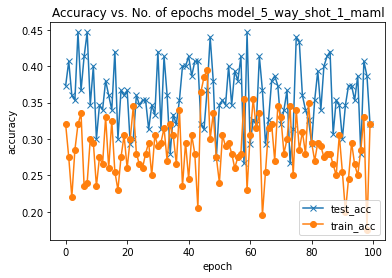

In [9]:
plot_accuracies(history,'model_5_way_shot_1_maml')

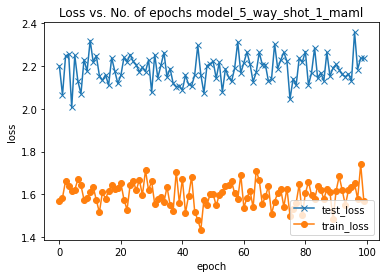

In [10]:
plot_losses(history,'model_5_way_shot_1_maml')

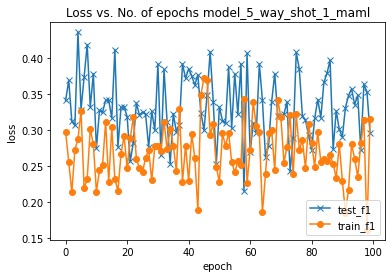

In [11]:
plot_f1(history,'model_5_way_shot_1_maml')

In [ ]:
test_F_maml_1 = test_F_maml(model_5_way_shot_1_maml,10,5,5,1,10)

val_loss : 2.16 val_acc : 0.2500 val_F1: 0.2204
val_loss : 1.89 val_acc : 0.4150 val_F1: 0.3871
val_loss : 2.04 val_acc : 0.3200 val_F1: 0.3083
val_loss : 2.07 val_acc : 0.3350 val_F1: 0.3119
val_loss : 2.06 val_acc : 0.3650 val_F1: 0.3572
val_loss : 2.05 val_acc : 0.3500 val_F1: 0.3359
val_loss : 1.97 val_acc : 0.3750 val_F1: 0.3504
val_loss : 2.03 val_acc : 0.3400 val_F1: 0.3051
val_loss : 2.06 val_acc : 0.3550 val_F1: 0.3357
val_loss : 1.93 val_acc : 0.4450 val_F1: 0.4125


In [ ]:
print("model_5_way_shot_1_maml test :")
print(f"loss : {test_F_maml_1[0]:.2f}   acc: {test_F_maml_1[1]:.2f}  f1 : {test_F_maml_1[2]:.2f} ")

model_5_way_shot_1_maml test :
loss : 2.03   acc: 0.35  f1 : 0.33 


In [ ]:
Fomaml = False
# scheduler = torch.optim.lr_scheduler.ExponentialLR
scheduler = None
history2,model_5_way_5_shot_maml = train_F_maml(Epochs,2,5,5,10,save_epoch,Fomaml,scheduler)

  0%|          | 0/20000 [00:00<?, ?it/s]

train_loss : 1.51 train_acc : 0.3600 train_F1: 0.3577


  0%|          | 1/20000 [00:00<53:25,  6.24it/s]

val_loss : 2.97 val_acc : 0.6600 val_F1: 0.6398
#####################################################################################


  1%|          | 202/20000 [00:19<33:57,  9.72it/s]

train_loss : 1.53 train_acc : 0.3600 train_F1: 0.3572
val_loss : 2.98 val_acc : 0.7400 val_F1: 0.7372
#####################################################################################


  2%|▏         | 402/20000 [00:37<33:18,  9.81it/s]

train_loss : 1.43 train_acc : 0.3900 train_F1: 0.3817
val_loss : 3.12 val_acc : 0.5800 val_F1: 0.5775
#####################################################################################


  3%|▎         | 602/20000 [00:56<32:58,  9.81it/s]

train_loss : 1.49 train_acc : 0.3900 train_F1: 0.3774
val_loss : 2.94 val_acc : 0.8000 val_F1: 0.7932
#####################################################################################


  4%|▍         | 802/20000 [01:15<32:47,  9.76it/s]

train_loss : 1.44 train_acc : 0.3900 train_F1: 0.3768
val_loss : 3.05 val_acc : 0.7000 val_F1: 0.6667
#####################################################################################


  5%|▌         | 1002/20000 [01:34<32:17,  9.81it/s]

train_loss : 1.38 train_acc : 0.3700 train_F1: 0.3676
val_loss : 2.89 val_acc : 0.7600 val_F1: 0.7378
#####################################################################################


  6%|▌         | 1202/20000 [01:52<31:52,  9.83it/s]

train_loss : 1.48 train_acc : 0.3900 train_F1: 0.3924
val_loss : 3.04 val_acc : 0.6400 val_F1: 0.6260
#####################################################################################


  7%|▋         | 1400/20000 [02:11<29:12, 10.61it/s]

train_loss : 1.39 train_acc : 0.4300 train_F1: 0.4394
val_loss : 3.15 val_acc : 0.5600 val_F1: 0.5639
#####################################################################################


  8%|▊         | 1602/20000 [02:30<30:58,  9.90it/s]

train_loss : 1.45 train_acc : 0.3400 train_F1: 0.3077
val_loss : 2.83 val_acc : 0.6800 val_F1: 0.6681
#####################################################################################


  9%|▉         | 1802/20000 [02:48<30:51,  9.83it/s]

train_loss : 1.63 train_acc : 0.2700 train_F1: 0.2647
val_loss : 3.05 val_acc : 0.6000 val_F1: 0.5873
#####################################################################################


 10%|█         | 2002/20000 [03:07<30:39,  9.79it/s]

train_loss : 1.48 train_acc : 0.3100 train_F1: 0.3161
val_loss : 2.70 val_acc : 0.8200 val_F1: 0.7744
#####################################################################################


 11%|█         | 2200/20000 [03:26<27:55, 10.63it/s]

train_loss : 1.44 train_acc : 0.3800 train_F1: 0.3786
val_loss : 2.93 val_acc : 0.7400 val_F1: 0.7012
#####################################################################################


 12%|█▏        | 2402/20000 [03:45<29:49,  9.84it/s]

train_loss : 1.45 train_acc : 0.3900 train_F1: 0.3809
val_loss : 2.93 val_acc : 0.7800 val_F1: 0.7655
#####################################################################################


 13%|█▎        | 2602/20000 [04:03<29:42,  9.76it/s]

train_loss : 1.46 train_acc : 0.4000 train_F1: 0.4003
val_loss : 3.02 val_acc : 0.6800 val_F1: 0.6573
#####################################################################################


 14%|█▍        | 2802/20000 [04:22<29:26,  9.74it/s]

train_loss : 1.47 train_acc : 0.3400 train_F1: 0.3490
val_loss : 2.75 val_acc : 0.9000 val_F1: 0.8912
#####################################################################################


 15%|█▌        | 3002/20000 [04:41<29:10,  9.71it/s]

train_loss : 1.49 train_acc : 0.3700 train_F1: 0.3550
val_loss : 3.07 val_acc : 0.6600 val_F1: 0.6566
#####################################################################################


 16%|█▌        | 3202/20000 [05:00<28:20,  9.88it/s]

train_loss : 1.51 train_acc : 0.3200 train_F1: 0.3084
val_loss : 3.10 val_acc : 0.5400 val_F1: 0.5157
#####################################################################################


 17%|█▋        | 3402/20000 [05:18<28:08,  9.83it/s]

train_loss : 1.48 train_acc : 0.3500 train_F1: 0.3489
val_loss : 2.69 val_acc : 0.8800 val_F1: 0.8439
#####################################################################################


 18%|█▊        | 3602/20000 [05:37<27:54,  9.79it/s]

train_loss : 1.46 train_acc : 0.4500 train_F1: 0.4527
val_loss : 3.02 val_acc : 0.6400 val_F1: 0.5938
#####################################################################################


 19%|█▉        | 3802/20000 [05:56<27:27,  9.83it/s]

train_loss : 1.54 train_acc : 0.3300 train_F1: 0.3182
val_loss : 3.13 val_acc : 0.7400 val_F1: 0.6749
#####################################################################################


 20%|██        | 4000/20000 [06:14<25:09, 10.60it/s]

train_loss : 1.44 train_acc : 0.4600 train_F1: 0.4591
val_loss : 2.79 val_acc : 0.8000 val_F1: 0.8005
#####################################################################################


 21%|██        | 4202/20000 [06:33<26:46,  9.83it/s]

train_loss : 1.52 train_acc : 0.3100 train_F1: 0.3046
val_loss : 2.80 val_acc : 0.8400 val_F1: 0.8068
#####################################################################################


 22%|██▏       | 4402/20000 [06:52<26:28,  9.82it/s]

train_loss : 1.49 train_acc : 0.3600 train_F1: 0.3615
val_loss : 2.90 val_acc : 0.7000 val_F1: 0.6929
#####################################################################################


 23%|██▎       | 4600/20000 [07:11<24:10, 10.62it/s]

train_loss : 1.48 train_acc : 0.3500 train_F1: 0.3401
val_loss : 2.69 val_acc : 0.8800 val_F1: 0.8650
#####################################################################################


 24%|██▍       | 4800/20000 [07:29<23:41, 10.70it/s]

train_loss : 1.63 train_acc : 0.2200 train_F1: 0.2121
val_loss : 2.73 val_acc : 0.7800 val_F1: 0.7559
#####################################################################################


 25%|██▌       | 5002/20000 [07:48<25:33,  9.78it/s]

train_loss : 1.47 train_acc : 0.3800 train_F1: 0.3740
val_loss : 2.87 val_acc : 0.8200 val_F1: 0.7807
#####################################################################################


 26%|██▌       | 5202/20000 [08:07<25:09,  9.80it/s]

train_loss : 1.52 train_acc : 0.3400 train_F1: 0.3211
val_loss : 2.97 val_acc : 0.8200 val_F1: 0.7800
#####################################################################################


 27%|██▋       | 5402/20000 [08:26<24:57,  9.75it/s]

train_loss : 1.47 train_acc : 0.3500 train_F1: 0.3535
val_loss : 2.93 val_acc : 0.7200 val_F1: 0.6962
#####################################################################################


 28%|██▊       | 5602/20000 [08:44<24:28,  9.81it/s]

train_loss : 1.44 train_acc : 0.4100 train_F1: 0.3926
val_loss : 3.10 val_acc : 0.5800 val_F1: 0.6007
#####################################################################################


 29%|██▉       | 5802/20000 [09:03<23:56,  9.88it/s]

train_loss : 1.47 train_acc : 0.4100 train_F1: 0.3967
val_loss : 2.88 val_acc : 0.8800 val_F1: 0.8291
#####################################################################################


 30%|███       | 6002/20000 [09:22<23:46,  9.81it/s]

train_loss : 1.55 train_acc : 0.3300 train_F1: 0.3271
val_loss : 3.24 val_acc : 0.6200 val_F1: 0.6076
#####################################################################################


 31%|███       | 6200/20000 [09:40<21:41, 10.60it/s]

train_loss : 1.59 train_acc : 0.3000 train_F1: 0.3135
val_loss : 3.20 val_acc : 0.5800 val_F1: 0.5481
#####################################################################################


 32%|███▏      | 6402/20000 [09:59<23:10,  9.78it/s]

train_loss : 1.54 train_acc : 0.3300 train_F1: 0.3205
val_loss : 3.20 val_acc : 0.5400 val_F1: 0.5323
#####################################################################################


 33%|███▎      | 6602/20000 [10:18<22:49,  9.78it/s]

train_loss : 1.57 train_acc : 0.2900 train_F1: 0.2782
val_loss : 3.07 val_acc : 0.6800 val_F1: 0.6823
#####################################################################################


 34%|███▍      | 6802/20000 [10:37<22:29,  9.78it/s]

train_loss : 1.51 train_acc : 0.2900 train_F1: 0.2617
val_loss : 2.50 val_acc : 1.1000 val_F1: 1.0817
#####################################################################################


 35%|███▌      | 7000/20000 [10:55<20:19, 10.66it/s]

train_loss : 1.46 train_acc : 0.3000 train_F1: 0.2843
val_loss : 2.69 val_acc : 0.9000 val_F1: 0.9016
#####################################################################################


 36%|███▌      | 7202/20000 [11:14<21:40,  9.84it/s]

train_loss : 1.51 train_acc : 0.3500 train_F1: 0.3255
val_loss : 3.04 val_acc : 0.7400 val_F1: 0.7099
#####################################################################################


 37%|███▋      | 7402/20000 [11:33<21:20,  9.84it/s]

train_loss : 1.57 train_acc : 0.3200 train_F1: 0.3105
val_loss : 3.04 val_acc : 0.6000 val_F1: 0.5795
#####################################################################################


 38%|███▊      | 7602/20000 [11:52<21:01,  9.83it/s]

train_loss : 1.47 train_acc : 0.4000 train_F1: 0.3907
val_loss : 2.93 val_acc : 0.7000 val_F1: 0.6695
#####################################################################################


 39%|███▉      | 7802/20000 [12:10<20:32,  9.90it/s]

train_loss : 1.45 train_acc : 0.4000 train_F1: 0.3950
val_loss : 2.94 val_acc : 0.7000 val_F1: 0.6774
#####################################################################################


 40%|████      | 8002/20000 [12:29<20:16,  9.86it/s]

train_loss : 1.47 train_acc : 0.4300 train_F1: 0.4062
val_loss : 2.85 val_acc : 0.7400 val_F1: 0.7044
#####################################################################################


 41%|████      | 8202/20000 [12:48<20:02,  9.81it/s]

train_loss : 1.41 train_acc : 0.4500 train_F1: 0.4436
val_loss : 2.91 val_acc : 0.7600 val_F1: 0.7556
#####################################################################################


 42%|████▏     | 8402/20000 [13:06<19:43,  9.80it/s]

train_loss : 1.54 train_acc : 0.3700 train_F1: 0.3684
val_loss : 3.21 val_acc : 0.6000 val_F1: 0.5917
#####################################################################################


 43%|████▎     | 8602/20000 [13:25<19:16,  9.86it/s]

train_loss : 1.51 train_acc : 0.4000 train_F1: 0.3961
val_loss : 2.93 val_acc : 0.7600 val_F1: 0.7599
#####################################################################################


 44%|████▍     | 8802/20000 [13:44<19:03,  9.80it/s]

train_loss : 1.52 train_acc : 0.3300 train_F1: 0.3122
val_loss : 2.97 val_acc : 0.8200 val_F1: 0.8250
#####################################################################################


 45%|████▌     | 9002/20000 [14:02<18:38,  9.83it/s]

train_loss : 1.48 train_acc : 0.3700 train_F1: 0.3595
val_loss : 3.01 val_acc : 0.8000 val_F1: 0.7618
#####################################################################################


 46%|████▌     | 9202/20000 [14:21<18:21,  9.80it/s]

train_loss : 1.39 train_acc : 0.4500 train_F1: 0.4613
val_loss : 2.96 val_acc : 0.6400 val_F1: 0.6436
#####################################################################################


 47%|████▋     | 9402/20000 [14:40<17:58,  9.83it/s]

train_loss : 1.55 train_acc : 0.2900 train_F1: 0.2772
val_loss : 2.92 val_acc : 0.6800 val_F1: 0.6310
#####################################################################################


 48%|████▊     | 9602/20000 [14:58<17:40,  9.81it/s]

train_loss : 1.41 train_acc : 0.3800 train_F1: 0.3529
val_loss : 2.88 val_acc : 0.8600 val_F1: 0.8454
#####################################################################################


 49%|████▉     | 9802/20000 [15:17<17:21,  9.79it/s]

train_loss : 1.54 train_acc : 0.3300 train_F1: 0.3153
val_loss : 2.96 val_acc : 0.6200 val_F1: 0.6071
#####################################################################################


 50%|█████     | 10002/20000 [15:36<17:03,  9.77it/s]

train_loss : 1.56 train_acc : 0.3100 train_F1: 0.3084
val_loss : 2.90 val_acc : 0.7200 val_F1: 0.7179
#####################################################################################


 51%|█████     | 10202/20000 [15:55<16:41,  9.78it/s]

train_loss : 1.54 train_acc : 0.3500 train_F1: 0.3536
val_loss : 2.90 val_acc : 0.8000 val_F1: 0.8146
#####################################################################################


 52%|█████▏    | 10402/20000 [16:13<16:24,  9.75it/s]

train_loss : 1.58 train_acc : 0.2900 train_F1: 0.2802
val_loss : 2.88 val_acc : 0.8400 val_F1: 0.8106
#####################################################################################


 53%|█████▎    | 10602/20000 [16:32<15:58,  9.81it/s]

train_loss : 1.49 train_acc : 0.3300 train_F1: 0.3079
val_loss : 3.26 val_acc : 0.5400 val_F1: 0.5412
#####################################################################################


 54%|█████▍    | 10802/20000 [16:51<15:46,  9.72it/s]

train_loss : 1.47 train_acc : 0.3600 train_F1: 0.3597
val_loss : 2.90 val_acc : 0.7200 val_F1: 0.6927
#####################################################################################


 55%|█████▌    | 11002/20000 [17:10<15:17,  9.80it/s]

train_loss : 1.51 train_acc : 0.3200 train_F1: 0.3160
val_loss : 2.99 val_acc : 0.7800 val_F1: 0.7452
#####################################################################################


 56%|█████▌    | 11202/20000 [17:28<14:58,  9.79it/s]

train_loss : 1.57 train_acc : 0.3000 train_F1: 0.2906
val_loss : 3.13 val_acc : 0.6800 val_F1: 0.6704
#####################################################################################


 57%|█████▋    | 11402/20000 [17:47<14:34,  9.83it/s]

train_loss : 1.59 train_acc : 0.2800 train_F1: 0.2729
val_loss : 3.07 val_acc : 0.6600 val_F1: 0.6415
#####################################################################################


 58%|█████▊    | 11602/20000 [18:06<14:17,  9.79it/s]

train_loss : 1.51 train_acc : 0.3700 train_F1: 0.3746
val_loss : 2.83 val_acc : 0.8000 val_F1: 0.7816
#####################################################################################


 59%|█████▉    | 11800/20000 [18:24<13:13, 10.33it/s]

train_loss : 1.46 train_acc : 0.3600 train_F1: 0.3425
val_loss : 2.81 val_acc : 0.7000 val_F1: 0.6427
#####################################################################################


 60%|██████    | 12000/20000 [18:44<12:49, 10.39it/s]

train_loss : 1.35 train_acc : 0.4500 train_F1: 0.4444
val_loss : 2.74 val_acc : 0.8800 val_F1: 0.8626
#####################################################################################


 61%|██████    | 12201/20000 [19:03<13:24,  9.70it/s]

train_loss : 1.45 train_acc : 0.4100 train_F1: 0.3985
val_loss : 3.03 val_acc : 0.6400 val_F1: 0.6083
#####################################################################################


 62%|██████▏   | 12401/20000 [19:22<13:19,  9.50it/s]

train_loss : 1.40 train_acc : 0.4600 train_F1: 0.4634
val_loss : 2.89 val_acc : 0.8200 val_F1: 0.7946
#####################################################################################


 63%|██████▎   | 12601/20000 [19:42<12:59,  9.49it/s]

train_loss : 1.36 train_acc : 0.4600 train_F1: 0.4625
val_loss : 2.90 val_acc : 0.7400 val_F1: 0.7130
#####################################################################################


 64%|██████▍   | 12801/20000 [20:01<12:43,  9.43it/s]

train_loss : 1.50 train_acc : 0.3900 train_F1: 0.3835
val_loss : 2.83 val_acc : 0.7200 val_F1: 0.6931
#####################################################################################


 65%|██████▌   | 13001/20000 [20:20<12:29,  9.34it/s]

train_loss : 1.43 train_acc : 0.3900 train_F1: 0.3915
val_loss : 3.20 val_acc : 0.6400 val_F1: 0.6351
#####################################################################################


 66%|██████▌   | 13200/20000 [20:39<10:41, 10.60it/s]

train_loss : 1.50 train_acc : 0.3400 train_F1: 0.3276
val_loss : 2.92 val_acc : 0.7600 val_F1: 0.7452
#####################################################################################


 67%|██████▋   | 13402/20000 [20:59<11:19,  9.71it/s]

train_loss : 1.44 train_acc : 0.4100 train_F1: 0.4055
val_loss : 3.26 val_acc : 0.5600 val_F1: 0.5685
#####################################################################################


 68%|██████▊   | 13600/20000 [21:17<09:58, 10.70it/s]

train_loss : 1.50 train_acc : 0.3300 train_F1: 0.3139
val_loss : 3.29 val_acc : 0.5200 val_F1: 0.5241
#####################################################################################


 69%|██████▉   | 13800/20000 [21:36<09:52, 10.47it/s]

train_loss : 1.51 train_acc : 0.3100 train_F1: 0.3050
val_loss : 3.12 val_acc : 0.7200 val_F1: 0.6850
#####################################################################################


 70%|███████   | 14002/20000 [21:56<10:18,  9.69it/s]

train_loss : 1.59 train_acc : 0.2900 train_F1: 0.2725
val_loss : 2.80 val_acc : 0.8800 val_F1: 0.8583
#####################################################################################


 71%|███████   | 14202/20000 [22:15<10:09,  9.52it/s]

train_loss : 1.60 train_acc : 0.3000 train_F1: 0.2878
val_loss : 3.11 val_acc : 0.6800 val_F1: 0.6587
#####################################################################################


 72%|███████▏  | 14400/20000 [22:34<08:51, 10.53it/s]

train_loss : 1.54 train_acc : 0.3100 train_F1: 0.3064
val_loss : 3.00 val_acc : 0.9200 val_F1: 0.8811
#####################################################################################


 73%|███████▎  | 14601/20000 [22:53<09:46,  9.20it/s]

train_loss : 1.54 train_acc : 0.2800 train_F1: 0.2804
val_loss : 2.86 val_acc : 0.7000 val_F1: 0.6890
#####################################################################################


 74%|███████▍  | 14801/20000 [23:12<09:02,  9.58it/s]

train_loss : 1.56 train_acc : 0.3300 train_F1: 0.3336
val_loss : 3.26 val_acc : 0.4800 val_F1: 0.4977
#####################################################################################


 75%|███████▌  | 15001/20000 [23:32<08:39,  9.62it/s]

train_loss : 1.49 train_acc : 0.3800 train_F1: 0.3779
val_loss : 3.16 val_acc : 0.5000 val_F1: 0.4928
#####################################################################################


 76%|███████▌  | 15201/20000 [23:51<08:17,  9.65it/s]

train_loss : 1.60 train_acc : 0.2500 train_F1: 0.2523
val_loss : 2.91 val_acc : 0.7600 val_F1: 0.7392
#####################################################################################


 77%|███████▋  | 15401/20000 [24:10<07:59,  9.60it/s]

train_loss : 1.43 train_acc : 0.3900 train_F1: 0.3966
val_loss : 2.80 val_acc : 0.8600 val_F1: 0.8379
#####################################################################################


 78%|███████▊  | 15601/20000 [24:29<07:41,  9.52it/s]

train_loss : 1.62 train_acc : 0.3200 train_F1: 0.3106
val_loss : 2.98 val_acc : 0.6800 val_F1: 0.6714
#####################################################################################


 79%|███████▉  | 15801/20000 [24:48<07:09,  9.79it/s]

train_loss : 1.52 train_acc : 0.4000 train_F1: 0.3816
val_loss : 2.90 val_acc : 0.9000 val_F1: 0.8867
#####################################################################################


 80%|████████  | 16001/20000 [25:08<06:47,  9.82it/s]

train_loss : 1.41 train_acc : 0.3800 train_F1: 0.3755
val_loss : 3.05 val_acc : 0.8000 val_F1: 0.7845
#####################################################################################


 81%|████████  | 16201/20000 [25:26<06:17, 10.06it/s]

train_loss : 1.54 train_acc : 0.2900 train_F1: 0.2885
val_loss : 3.07 val_acc : 0.6200 val_F1: 0.6301
#####################################################################################


 82%|████████▏ | 16402/20000 [25:45<05:55, 10.13it/s]

train_loss : 1.38 train_acc : 0.4600 train_F1: 0.4450
val_loss : 2.96 val_acc : 0.7200 val_F1: 0.7012
#####################################################################################


 83%|████████▎ | 16602/20000 [26:03<05:38, 10.04it/s]

train_loss : 1.49 train_acc : 0.4000 train_F1: 0.3967
val_loss : 2.99 val_acc : 0.7600 val_F1: 0.7514
#####################################################################################


 84%|████████▍ | 16800/20000 [26:22<05:07, 10.41it/s]

train_loss : 1.52 train_acc : 0.3300 train_F1: 0.3098
val_loss : 2.86 val_acc : 0.8000 val_F1: 0.7861
#####################################################################################


 85%|████████▌ | 17000/20000 [26:41<04:37, 10.81it/s]

train_loss : 1.39 train_acc : 0.3900 train_F1: 0.3875
val_loss : 2.99 val_acc : 0.7600 val_F1: 0.7070
#####################################################################################


 86%|████████▌ | 17202/20000 [27:00<04:46,  9.75it/s]

train_loss : 1.45 train_acc : 0.4100 train_F1: 0.4112
val_loss : 2.62 val_acc : 1.0000 val_F1: 0.9969
#####################################################################################


 87%|████████▋ | 17402/20000 [27:19<04:33,  9.51it/s]

train_loss : 1.51 train_acc : 0.4000 train_F1: 0.3915
val_loss : 2.92 val_acc : 0.7600 val_F1: 0.7581
#####################################################################################


 88%|████████▊ | 17600/20000 [27:38<03:46, 10.58it/s]

train_loss : 1.49 train_acc : 0.3600 train_F1: 0.3601
val_loss : 3.02 val_acc : 0.7600 val_F1: 0.7494
#####################################################################################


 89%|████████▉ | 17802/20000 [27:57<03:41,  9.94it/s]

train_loss : 1.52 train_acc : 0.3400 train_F1: 0.3182
val_loss : 3.06 val_acc : 0.6200 val_F1: 0.5995
#####################################################################################


 90%|█████████ | 18002/20000 [28:15<03:23,  9.83it/s]

train_loss : 1.43 train_acc : 0.4300 train_F1: 0.4325
val_loss : 3.07 val_acc : 0.5400 val_F1: 0.5484
#####################################################################################


 91%|█████████ | 18202/20000 [28:34<03:00,  9.96it/s]

train_loss : 1.50 train_acc : 0.3300 train_F1: 0.3122
val_loss : 2.89 val_acc : 0.6200 val_F1: 0.6370
#####################################################################################


 92%|█████████▏| 18402/20000 [28:52<02:41,  9.87it/s]

train_loss : 1.57 train_acc : 0.3100 train_F1: 0.3132
val_loss : 3.02 val_acc : 0.6400 val_F1: 0.6209
#####################################################################################


 93%|█████████▎| 18602/20000 [29:11<02:20,  9.97it/s]

train_loss : 1.37 train_acc : 0.4600 train_F1: 0.4506
val_loss : 3.25 val_acc : 0.4000 val_F1: 0.3573
#####################################################################################


 94%|█████████▍| 18802/20000 [29:29<02:00,  9.90it/s]

train_loss : 1.46 train_acc : 0.3800 train_F1: 0.3753
val_loss : 3.00 val_acc : 0.7000 val_F1: 0.6794
#####################################################################################


 95%|█████████▌| 19002/20000 [29:48<01:41,  9.85it/s]

train_loss : 1.44 train_acc : 0.3800 train_F1: 0.3805
val_loss : 3.07 val_acc : 0.6800 val_F1: 0.6785
#####################################################################################


 96%|█████████▌| 19202/20000 [30:06<01:20,  9.93it/s]

train_loss : 1.55 train_acc : 0.3000 train_F1: 0.2837
val_loss : 2.98 val_acc : 0.8000 val_F1: 0.7957
#####################################################################################


 97%|█████████▋| 19402/20000 [30:24<01:00,  9.93it/s]

train_loss : 1.60 train_acc : 0.3300 train_F1: 0.3107
val_loss : 2.68 val_acc : 1.0200 val_F1: 1.0063
#####################################################################################


 98%|█████████▊| 19602/20000 [30:43<00:40,  9.91it/s]

train_loss : 1.63 train_acc : 0.2500 train_F1: 0.2435
val_loss : 3.00 val_acc : 0.7200 val_F1: 0.7194
#####################################################################################


 99%|█████████▉| 19802/20000 [31:01<00:19,  9.95it/s]

train_loss : 1.50 train_acc : 0.3600 train_F1: 0.3474
val_loss : 2.89 val_acc : 0.8800 val_F1: 0.8844
#####################################################################################


100%|██████████| 20000/20000 [31:19<00:00, 10.64it/s]


In [ ]:
joblib.dump(model_5_way_5_shot_maml, 'model_5_way_5_shot_maml')
joblib.dump(history2,'history2')

['history2']

In [12]:
history2 = joblib.load('history2')

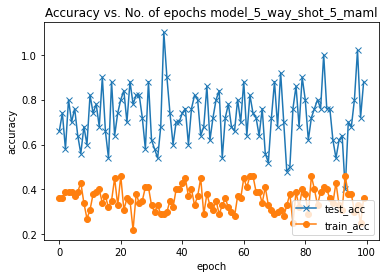

In [13]:
plot_accuracies(history2,'model_5_way_shot_5_maml')

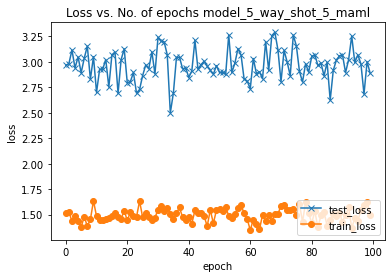

In [14]:
plot_losses(history2,'model_5_way_shot_5_maml')

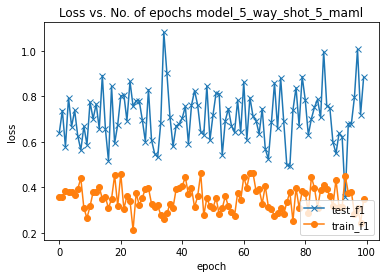

In [15]:
plot_f1(history2,'model_5_way_shot_5_maml')

In [ ]:
test_F_maml_2 = test_F_maml(model_5_way_5_shot_maml,10,5,5,5,10)

val_loss : 1.83 val_acc : 0.4550 val_F1: 0.4502
val_loss : 1.83 val_acc : 0.4350 val_F1: 0.4253
val_loss : 1.88 val_acc : 0.4100 val_F1: 0.4023
val_loss : 1.78 val_acc : 0.5350 val_F1: 0.5291
val_loss : 1.85 val_acc : 0.4300 val_F1: 0.4155
val_loss : 1.88 val_acc : 0.4450 val_F1: 0.4394
val_loss : 1.84 val_acc : 0.4650 val_F1: 0.4513
val_loss : 1.86 val_acc : 0.4600 val_F1: 0.4423
val_loss : 1.85 val_acc : 0.4400 val_F1: 0.4313
val_loss : 1.87 val_acc : 0.4000 val_F1: 0.3772


In [ ]:
print("model_5_way_shot_5_maml test :")
print(f"loss : {test_F_maml_2[0]:.2f}   acc: {test_F_maml_2[1]:.2f}  f1 : {test_F_maml_2[2]:.2f} ")

model_5_way_shot_5_maml test :
loss : 1.85   acc: 0.45  f1 : 0.44 


In [ ]:
Fomaml = True
# scheduler = torch.optim.lr_scheduler.ExponentialLR
scheduler = None
history3,model_5_way_1_shot_fomaml = train_F_maml(Epochs,4,5,1,10,save_epoch,Fomaml,scheduler)

  0%|          | 1/20000 [00:00<59:27,  5.61it/s]

train_loss : 1.56 train_acc : 0.3250 train_F1: 0.3114
val_loss : 2.26 val_acc : 0.3733 val_F1: 0.3311
#####################################################################################


  1%|          | 201/20000 [00:14<28:00, 11.78it/s]

train_loss : 1.59 train_acc : 0.3000 train_F1: 0.2854
val_loss : 2.17 val_acc : 0.4133 val_F1: 0.3883
#####################################################################################


  2%|▏         | 401/20000 [00:29<28:02, 11.65it/s]

train_loss : 1.60 train_acc : 0.3000 train_F1: 0.2729
val_loss : 2.19 val_acc : 0.3133 val_F1: 0.3009
#####################################################################################


  3%|▎         | 601/20000 [00:43<27:41, 11.67it/s]

train_loss : 1.55 train_acc : 0.3300 train_F1: 0.3062
val_loss : 2.22 val_acc : 0.2533 val_F1: 0.2369
#####################################################################################


  4%|▍         | 801/20000 [00:58<26:49, 11.93it/s]

train_loss : 1.57 train_acc : 0.3250 train_F1: 0.3002
val_loss : 2.05 val_acc : 0.3667 val_F1: 0.3184
#####################################################################################


  5%|▌         | 1001/20000 [01:12<26:35, 11.91it/s]

train_loss : 1.60 train_acc : 0.2450 train_F1: 0.2365
val_loss : 2.16 val_acc : 0.3733 val_F1: 0.3306
#####################################################################################


  6%|▌         | 1201/20000 [01:27<26:34, 11.79it/s]

train_loss : 1.62 train_acc : 0.2750 train_F1: 0.2733
val_loss : 2.25 val_acc : 0.3133 val_F1: 0.2978
#####################################################################################


  7%|▋         | 1401/20000 [01:41<26:36, 11.65it/s]

train_loss : 1.52 train_acc : 0.3500 train_F1: 0.3121
val_loss : 2.15 val_acc : 0.4200 val_F1: 0.3902
#####################################################################################


  8%|▊         | 1601/20000 [01:56<26:43, 11.48it/s]

train_loss : 1.64 train_acc : 0.2600 train_F1: 0.2506
val_loss : 2.26 val_acc : 0.3200 val_F1: 0.3007
#####################################################################################


  9%|▉         | 1801/20000 [02:10<26:00, 11.66it/s]

train_loss : 1.66 train_acc : 0.2500 train_F1: 0.2330
val_loss : 2.19 val_acc : 0.3800 val_F1: 0.3403
#####################################################################################


 10%|█         | 2001/20000 [02:25<26:14, 11.43it/s]

train_loss : 1.56 train_acc : 0.3050 train_F1: 0.2759
val_loss : 2.14 val_acc : 0.4000 val_F1: 0.3869
#####################################################################################


 11%|█         | 2201/20000 [02:39<24:49, 11.95it/s]

train_loss : 1.51 train_acc : 0.3600 train_F1: 0.3480
val_loss : 2.21 val_acc : 0.3667 val_F1: 0.3180
#####################################################################################


 12%|█▏        | 2401/20000 [02:53<24:58, 11.74it/s]

train_loss : 1.65 train_acc : 0.2500 train_F1: 0.2441
val_loss : 2.19 val_acc : 0.4200 val_F1: 0.3911
#####################################################################################


 13%|█▎        | 2601/20000 [03:08<24:30, 11.83it/s]

train_loss : 1.66 train_acc : 0.2850 train_F1: 0.2687
val_loss : 2.11 val_acc : 0.4533 val_F1: 0.4271
#####################################################################################


 14%|█▍        | 2801/20000 [03:22<24:23, 11.75it/s]

train_loss : 1.75 train_acc : 0.1600 train_F1: 0.1436
val_loss : 2.24 val_acc : 0.3467 val_F1: 0.3427
#####################################################################################


 15%|█▌        | 3001/20000 [03:37<23:46, 11.91it/s]

train_loss : 1.68 train_acc : 0.2100 train_F1: 0.1912
val_loss : 2.19 val_acc : 0.3533 val_F1: 0.3229
#####################################################################################


 16%|█▌        | 3201/20000 [03:51<23:51, 11.73it/s]

train_loss : 1.59 train_acc : 0.2800 train_F1: 0.2568
val_loss : 2.12 val_acc : 0.3667 val_F1: 0.3288
#####################################################################################


 17%|█▋        | 3401/20000 [04:06<23:32, 11.76it/s]

train_loss : 1.55 train_acc : 0.3000 train_F1: 0.2893
val_loss : 2.15 val_acc : 0.3667 val_F1: 0.3250
#####################################################################################


 18%|█▊        | 3601/20000 [04:20<23:20, 11.71it/s]

train_loss : 1.59 train_acc : 0.2850 train_F1: 0.2844
val_loss : 2.06 val_acc : 0.4667 val_F1: 0.4020
#####################################################################################


 19%|█▉        | 3801/20000 [04:35<23:19, 11.57it/s]

train_loss : 1.61 train_acc : 0.2750 train_F1: 0.2546
val_loss : 2.16 val_acc : 0.4267 val_F1: 0.3942
#####################################################################################


 20%|██        | 4001/20000 [04:49<23:15, 11.47it/s]

train_loss : 1.55 train_acc : 0.3050 train_F1: 0.2821
val_loss : 2.14 val_acc : 0.4400 val_F1: 0.4053
#####################################################################################


 21%|██        | 4201/20000 [05:04<22:35, 11.65it/s]

train_loss : 1.59 train_acc : 0.3050 train_F1: 0.2817
val_loss : 2.15 val_acc : 0.3333 val_F1: 0.2955
#####################################################################################


 22%|██▏       | 4401/20000 [05:18<22:43, 11.44it/s]

train_loss : 1.62 train_acc : 0.3150 train_F1: 0.2925
val_loss : 2.09 val_acc : 0.3933 val_F1: 0.3540
#####################################################################################


 23%|██▎       | 4601/20000 [05:33<22:09, 11.58it/s]

train_loss : 1.61 train_acc : 0.2900 train_F1: 0.2666
val_loss : 2.21 val_acc : 0.2867 val_F1: 0.2639
#####################################################################################


 24%|██▍       | 4801/20000 [05:47<21:10, 11.96it/s]

train_loss : 1.57 train_acc : 0.2850 train_F1: 0.2545
val_loss : 2.20 val_acc : 0.3200 val_F1: 0.2826
#####################################################################################


 25%|██▌       | 5001/20000 [06:02<20:52, 11.97it/s]

train_loss : 1.66 train_acc : 0.2550 train_F1: 0.2380
val_loss : 2.21 val_acc : 0.3267 val_F1: 0.3119
#####################################################################################


 26%|██▌       | 5201/20000 [06:16<21:00, 11.74it/s]

train_loss : 1.57 train_acc : 0.3100 train_F1: 0.3015
val_loss : 2.19 val_acc : 0.4000 val_F1: 0.3399
#####################################################################################


 27%|██▋       | 5401/20000 [06:30<20:57, 11.61it/s]

train_loss : 1.62 train_acc : 0.2950 train_F1: 0.2749
val_loss : 2.15 val_acc : 0.3600 val_F1: 0.3333
#####################################################################################


 28%|██▊       | 5601/20000 [06:45<20:24, 11.76it/s]

train_loss : 1.58 train_acc : 0.2650 train_F1: 0.2402
val_loss : 2.09 val_acc : 0.3733 val_F1: 0.3480
#####################################################################################


 29%|██▉       | 5801/20000 [06:59<20:25, 11.59it/s]

train_loss : 1.60 train_acc : 0.3100 train_F1: 0.2802
val_loss : 2.07 val_acc : 0.4133 val_F1: 0.3825
#####################################################################################


 30%|███       | 6001/20000 [07:14<19:39, 11.86it/s]

train_loss : 1.53 train_acc : 0.3200 train_F1: 0.2968
val_loss : 2.18 val_acc : 0.3267 val_F1: 0.3078
#####################################################################################


 31%|███       | 6201/20000 [07:28<19:31, 11.78it/s]

train_loss : 1.66 train_acc : 0.2500 train_F1: 0.2326
val_loss : 2.10 val_acc : 0.3800 val_F1: 0.3518
#####################################################################################


 32%|███▏      | 6401/20000 [07:42<20:03, 11.30it/s]

train_loss : 1.55 train_acc : 0.3600 train_F1: 0.3207
val_loss : 2.11 val_acc : 0.3667 val_F1: 0.3575
#####################################################################################


 33%|███▎      | 6601/20000 [07:57<19:28, 11.47it/s]

train_loss : 1.58 train_acc : 0.2800 train_F1: 0.2681
val_loss : 2.23 val_acc : 0.3267 val_F1: 0.2937
#####################################################################################


 34%|███▍      | 6801/20000 [08:11<19:01, 11.57it/s]

train_loss : 1.63 train_acc : 0.2250 train_F1: 0.1951
val_loss : 2.21 val_acc : 0.3600 val_F1: 0.3416
#####################################################################################


 35%|███▌      | 7001/20000 [08:26<18:38, 11.62it/s]

train_loss : 1.58 train_acc : 0.2900 train_F1: 0.2748
val_loss : 2.07 val_acc : 0.4333 val_F1: 0.4106
#####################################################################################


 36%|███▌      | 7201/20000 [08:40<18:08, 11.76it/s]

train_loss : 1.57 train_acc : 0.3050 train_F1: 0.2874
val_loss : 2.20 val_acc : 0.3533 val_F1: 0.3298
#####################################################################################


 37%|███▋      | 7401/20000 [08:55<17:58, 11.68it/s]

train_loss : 1.70 train_acc : 0.2600 train_F1: 0.2501
val_loss : 2.20 val_acc : 0.3333 val_F1: 0.3178
#####################################################################################


 38%|███▊      | 7601/20000 [09:09<17:44, 11.65it/s]

train_loss : 1.57 train_acc : 0.3250 train_F1: 0.3130
val_loss : 2.08 val_acc : 0.3333 val_F1: 0.2973
#####################################################################################


 39%|███▉      | 7801/20000 [09:24<17:27, 11.65it/s]

train_loss : 1.53 train_acc : 0.3300 train_F1: 0.3104
val_loss : 2.16 val_acc : 0.3267 val_F1: 0.3033
#####################################################################################


 40%|████      | 8001/20000 [09:38<16:43, 11.96it/s]

train_loss : 1.62 train_acc : 0.2750 train_F1: 0.2634
val_loss : 2.23 val_acc : 0.3400 val_F1: 0.3014
#####################################################################################


 41%|████      | 8201/20000 [09:53<16:48, 11.69it/s]

train_loss : 1.56 train_acc : 0.2850 train_F1: 0.2608
val_loss : 2.14 val_acc : 0.3667 val_F1: 0.3403
#####################################################################################


 42%|████▏     | 8401/20000 [10:07<16:48, 11.50it/s]

train_loss : 1.57 train_acc : 0.2800 train_F1: 0.2567
val_loss : 2.25 val_acc : 0.3267 val_F1: 0.2910
#####################################################################################


 43%|████▎     | 8601/20000 [10:22<16:20, 11.62it/s]

train_loss : 1.56 train_acc : 0.2850 train_F1: 0.2864
val_loss : 2.16 val_acc : 0.3933 val_F1: 0.3855
#####################################################################################


 44%|████▍     | 8801/20000 [10:36<15:31, 12.02it/s]

train_loss : 1.62 train_acc : 0.2750 train_F1: 0.2585
val_loss : 2.24 val_acc : 0.2733 val_F1: 0.2467
#####################################################################################


 45%|████▌     | 9001/20000 [10:50<15:31, 11.81it/s]

train_loss : 1.55 train_acc : 0.3050 train_F1: 0.2949
val_loss : 2.17 val_acc : 0.3400 val_F1: 0.3231
#####################################################################################


 46%|████▌     | 9201/20000 [11:05<15:11, 11.85it/s]

train_loss : 1.67 train_acc : 0.2000 train_F1: 0.1862
val_loss : 2.05 val_acc : 0.4200 val_F1: 0.4062
#####################################################################################


 47%|████▋     | 9401/20000 [11:19<15:03, 11.74it/s]

train_loss : 1.61 train_acc : 0.2750 train_F1: 0.2472
val_loss : 2.16 val_acc : 0.3067 val_F1: 0.2891
#####################################################################################


 48%|████▊     | 9601/20000 [11:34<14:41, 11.79it/s]

train_loss : 1.57 train_acc : 0.2600 train_F1: 0.2393
val_loss : 2.24 val_acc : 0.3333 val_F1: 0.3081
#####################################################################################


 49%|████▉     | 9801/20000 [11:48<14:07, 12.04it/s]

train_loss : 1.66 train_acc : 0.2600 train_F1: 0.2401
val_loss : 2.18 val_acc : 0.3667 val_F1: 0.3291
#####################################################################################


 50%|█████     | 10001/20000 [12:02<14:12, 11.73it/s]

train_loss : 1.60 train_acc : 0.3100 train_F1: 0.2934
val_loss : 2.12 val_acc : 0.3600 val_F1: 0.3388
#####################################################################################


 51%|█████     | 10201/20000 [12:17<13:59, 11.67it/s]

train_loss : 1.64 train_acc : 0.2800 train_F1: 0.2632
val_loss : 2.25 val_acc : 0.3467 val_F1: 0.3137
#####################################################################################


 52%|█████▏    | 10401/20000 [12:31<13:27, 11.89it/s]

train_loss : 1.64 train_acc : 0.2500 train_F1: 0.2411
val_loss : 2.25 val_acc : 0.3267 val_F1: 0.2880
#####################################################################################


 53%|█████▎    | 10601/20000 [12:46<13:16, 11.79it/s]

train_loss : 1.69 train_acc : 0.2250 train_F1: 0.2117
val_loss : 2.12 val_acc : 0.3800 val_F1: 0.3415
#####################################################################################


 54%|█████▍    | 10801/20000 [13:00<13:12, 11.60it/s]

train_loss : 1.59 train_acc : 0.2800 train_F1: 0.2676
val_loss : 2.13 val_acc : 0.3733 val_F1: 0.3289
#####################################################################################


 55%|█████▌    | 11001/20000 [13:15<12:47, 11.73it/s]

train_loss : 1.57 train_acc : 0.2800 train_F1: 0.2596
val_loss : 2.24 val_acc : 0.3400 val_F1: 0.3062
#####################################################################################


 56%|█████▌    | 11201/20000 [13:29<12:33, 11.67it/s]

train_loss : 1.65 train_acc : 0.2800 train_F1: 0.2613
val_loss : 2.21 val_acc : 0.3133 val_F1: 0.3163
#####################################################################################


 57%|█████▋    | 11401/20000 [13:44<12:23, 11.56it/s]

train_loss : 1.58 train_acc : 0.3550 train_F1: 0.3297
val_loss : 2.13 val_acc : 0.3933 val_F1: 0.3509
#####################################################################################


 58%|█████▊    | 11601/20000 [13:58<11:46, 11.89it/s]

train_loss : 1.64 train_acc : 0.2300 train_F1: 0.2079
val_loss : 2.18 val_acc : 0.2800 val_F1: 0.2419
#####################################################################################


 59%|█████▉    | 11801/20000 [14:12<11:49, 11.56it/s]

train_loss : 1.58 train_acc : 0.3200 train_F1: 0.3039
val_loss : 2.21 val_acc : 0.3067 val_F1: 0.3157
#####################################################################################


 60%|██████    | 12001/20000 [14:27<11:09, 11.95it/s]

train_loss : 1.56 train_acc : 0.2950 train_F1: 0.2627
val_loss : 2.21 val_acc : 0.3333 val_F1: 0.2969
#####################################################################################


 61%|██████    | 12201/20000 [14:41<11:12, 11.60it/s]

train_loss : 1.67 train_acc : 0.2750 train_F1: 0.2638
val_loss : 2.16 val_acc : 0.3867 val_F1: 0.3675
#####################################################################################


 62%|██████▏   | 12401/20000 [14:56<10:42, 11.82it/s]

train_loss : 1.58 train_acc : 0.3500 train_F1: 0.3315
val_loss : 2.26 val_acc : 0.3133 val_F1: 0.2565
#####################################################################################


 63%|██████▎   | 12601/20000 [15:10<10:34, 11.66it/s]

train_loss : 1.61 train_acc : 0.2950 train_F1: 0.2775
val_loss : 2.06 val_acc : 0.4800 val_F1: 0.4468
#####################################################################################


 64%|██████▍   | 12801/20000 [15:25<10:05, 11.89it/s]

train_loss : 1.63 train_acc : 0.2900 train_F1: 0.2664
val_loss : 2.11 val_acc : 0.3867 val_F1: 0.3620
#####################################################################################


 65%|██████▌   | 13001/20000 [15:39<10:02, 11.61it/s]

train_loss : 1.57 train_acc : 0.2400 train_F1: 0.2386
val_loss : 2.15 val_acc : 0.3933 val_F1: 0.3497
#####################################################################################


 66%|██████▌   | 13201/20000 [15:53<09:27, 11.98it/s]

train_loss : 1.62 train_acc : 0.3000 train_F1: 0.2726
val_loss : 2.14 val_acc : 0.3933 val_F1: 0.3597
#####################################################################################


 67%|██████▋   | 13401/20000 [16:08<09:23, 11.71it/s]

train_loss : 1.55 train_acc : 0.3050 train_F1: 0.2715
val_loss : 2.13 val_acc : 0.4000 val_F1: 0.3556
#####################################################################################


 68%|██████▊   | 13601/20000 [16:22<09:17, 11.48it/s]

train_loss : 1.53 train_acc : 0.3100 train_F1: 0.2988
val_loss : 2.11 val_acc : 0.4133 val_F1: 0.3876
#####################################################################################


 69%|██████▉   | 13801/20000 [16:37<08:59, 11.50it/s]

train_loss : 1.58 train_acc : 0.2700 train_F1: 0.2678
val_loss : 2.17 val_acc : 0.3467 val_F1: 0.2955
#####################################################################################


 70%|███████   | 14001/20000 [16:51<08:28, 11.79it/s]

train_loss : 1.65 train_acc : 0.2000 train_F1: 0.1844
val_loss : 2.15 val_acc : 0.3400 val_F1: 0.3018
#####################################################################################


 71%|███████   | 14201/20000 [17:05<08:21, 11.56it/s]

train_loss : 1.64 train_acc : 0.3100 train_F1: 0.2966
val_loss : 2.24 val_acc : 0.2800 val_F1: 0.2564
#####################################################################################


 72%|███████▏  | 14401/20000 [17:20<07:54, 11.81it/s]

train_loss : 1.59 train_acc : 0.2750 train_F1: 0.2649
val_loss : 2.14 val_acc : 0.3733 val_F1: 0.3265
#####################################################################################


 73%|███████▎  | 14601/20000 [17:34<07:49, 11.51it/s]

train_loss : 1.63 train_acc : 0.3200 train_F1: 0.2695
val_loss : 2.16 val_acc : 0.3733 val_F1: 0.3154
#####################################################################################


 74%|███████▍  | 14801/20000 [17:49<07:25, 11.66it/s]

train_loss : 1.62 train_acc : 0.2750 train_F1: 0.2562
val_loss : 2.24 val_acc : 0.3067 val_F1: 0.2825
#####################################################################################


 75%|███████▌  | 15001/20000 [18:03<07:06, 11.72it/s]

train_loss : 1.61 train_acc : 0.3050 train_F1: 0.2904
val_loss : 2.12 val_acc : 0.4133 val_F1: 0.3979
#####################################################################################


 76%|███████▌  | 15201/20000 [18:18<06:52, 11.62it/s]

train_loss : 1.60 train_acc : 0.2700 train_F1: 0.2574
val_loss : 2.13 val_acc : 0.3400 val_F1: 0.3181
#####################################################################################


 77%|███████▋  | 15401/20000 [18:32<06:29, 11.80it/s]

train_loss : 1.62 train_acc : 0.2700 train_F1: 0.2253
val_loss : 2.13 val_acc : 0.3800 val_F1: 0.3471
#####################################################################################


 78%|███████▊  | 15601/20000 [18:46<06:19, 11.60it/s]

train_loss : 1.66 train_acc : 0.2800 train_F1: 0.2620
val_loss : 2.21 val_acc : 0.2933 val_F1: 0.2739
#####################################################################################


 79%|███████▉  | 15801/20000 [19:01<05:52, 11.90it/s]

train_loss : 1.65 train_acc : 0.2350 train_F1: 0.2334
val_loss : 2.23 val_acc : 0.3267 val_F1: 0.2977
#####################################################################################


 80%|████████  | 16001/20000 [19:15<05:35, 11.91it/s]

train_loss : 1.56 train_acc : 0.3000 train_F1: 0.2805
val_loss : 2.07 val_acc : 0.4333 val_F1: 0.3962
#####################################################################################


 81%|████████  | 16201/20000 [19:30<05:24, 11.69it/s]

train_loss : 1.59 train_acc : 0.3000 train_F1: 0.2876
val_loss : 2.27 val_acc : 0.3067 val_F1: 0.2958
#####################################################################################


 82%|████████▏ | 16401/20000 [19:44<05:08, 11.67it/s]

train_loss : 1.59 train_acc : 0.2950 train_F1: 0.2628
val_loss : 2.26 val_acc : 0.2867 val_F1: 0.2483
#####################################################################################


 83%|████████▎ | 16601/20000 [19:59<04:45, 11.92it/s]

train_loss : 1.64 train_acc : 0.2450 train_F1: 0.2145
val_loss : 2.29 val_acc : 0.2867 val_F1: 0.2581
#####################################################################################


 84%|████████▍ | 16801/20000 [20:13<04:38, 11.49it/s]

train_loss : 1.65 train_acc : 0.2700 train_F1: 0.2469
val_loss : 2.16 val_acc : 0.4400 val_F1: 0.4022
#####################################################################################


 85%|████████▌ | 17001/20000 [20:28<04:19, 11.57it/s]

train_loss : 1.57 train_acc : 0.3100 train_F1: 0.2889
val_loss : 2.23 val_acc : 0.3933 val_F1: 0.3555
#####################################################################################


 86%|████████▌ | 17201/20000 [20:42<03:59, 11.68it/s]

train_loss : 1.63 train_acc : 0.2400 train_F1: 0.2074
val_loss : 2.14 val_acc : 0.3667 val_F1: 0.3415
#####################################################################################


 87%|████████▋ | 17401/20000 [20:57<03:46, 11.48it/s]

train_loss : 1.63 train_acc : 0.2300 train_F1: 0.2040
val_loss : 2.07 val_acc : 0.4600 val_F1: 0.4224
#####################################################################################


 88%|████████▊ | 17601/20000 [21:11<03:23, 11.80it/s]

train_loss : 1.52 train_acc : 0.3750 train_F1: 0.3525
val_loss : 2.11 val_acc : 0.4467 val_F1: 0.4002
#####################################################################################


 89%|████████▉ | 17801/20000 [21:26<03:10, 11.54it/s]

train_loss : 1.64 train_acc : 0.2650 train_F1: 0.2396
val_loss : 2.03 val_acc : 0.4467 val_F1: 0.4308
#####################################################################################


 90%|█████████ | 18001/20000 [21:40<02:49, 11.82it/s]

train_loss : 1.62 train_acc : 0.2900 train_F1: 0.2635
val_loss : 2.22 val_acc : 0.3533 val_F1: 0.3297
#####################################################################################


 91%|█████████ | 18201/20000 [21:55<02:35, 11.53it/s]

train_loss : 1.56 train_acc : 0.3150 train_F1: 0.2987
val_loss : 2.29 val_acc : 0.2733 val_F1: 0.2602
#####################################################################################


 92%|█████████▏| 18401/20000 [22:09<02:19, 11.46it/s]

train_loss : 1.61 train_acc : 0.2700 train_F1: 0.2504
val_loss : 2.25 val_acc : 0.2867 val_F1: 0.2585
#####################################################################################


 93%|█████████▎| 18601/20000 [22:24<01:57, 11.93it/s]

train_loss : 1.55 train_acc : 0.2900 train_F1: 0.2823
val_loss : 2.10 val_acc : 0.3733 val_F1: 0.3435
#####################################################################################


 94%|█████████▍| 18801/20000 [22:38<01:40, 11.94it/s]

train_loss : 1.56 train_acc : 0.3400 train_F1: 0.3233
val_loss : 2.20 val_acc : 0.3000 val_F1: 0.2833
#####################################################################################


 95%|█████████▌| 19001/20000 [22:53<01:26, 11.55it/s]

train_loss : 1.61 train_acc : 0.2300 train_F1: 0.2210
val_loss : 2.28 val_acc : 0.3133 val_F1: 0.2863
#####################################################################################


 96%|█████████▌| 19201/20000 [23:07<01:06, 11.99it/s]

train_loss : 1.68 train_acc : 0.2500 train_F1: 0.2403
val_loss : 2.15 val_acc : 0.3867 val_F1: 0.3662
#####################################################################################


 97%|█████████▋| 19401/20000 [23:22<00:51, 11.63it/s]

train_loss : 1.62 train_acc : 0.2500 train_F1: 0.2374
val_loss : 2.18 val_acc : 0.3400 val_F1: 0.3128
#####################################################################################


 98%|█████████▊| 19601/20000 [23:36<00:34, 11.52it/s]

train_loss : 1.63 train_acc : 0.2350 train_F1: 0.2270
val_loss : 2.17 val_acc : 0.3933 val_F1: 0.3649
#####################################################################################


 99%|█████████▉| 19801/20000 [23:51<00:16, 11.87it/s]

train_loss : 1.62 train_acc : 0.3150 train_F1: 0.2778
val_loss : 2.15 val_acc : 0.4000 val_F1: 0.3654
#####################################################################################


100%|██████████| 20000/20000 [24:05<00:00, 13.84it/s]


In [ ]:
joblib.dump(model_5_way_1_shot_fomaml, 'model_5_way_1_shot_fomaml')
joblib.dump(history3,'history3')

['history3']

In [16]:
history3 = joblib.load('history3')

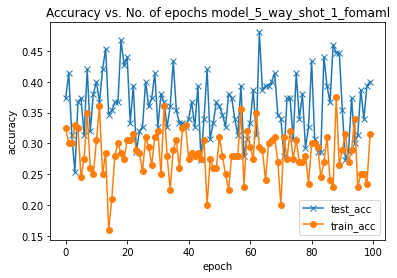

In [17]:
plot_accuracies(history3,'model_5_way_shot_1_fomaml')

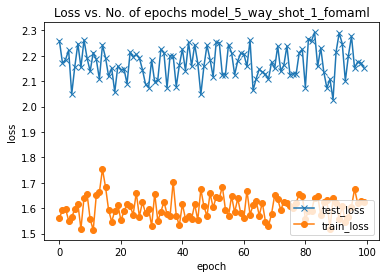

In [18]:
plot_losses(history3,'model_5_way_shot_1_fomaml')

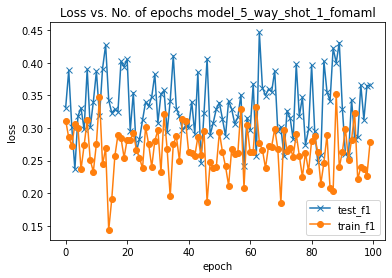

In [19]:
plot_f1(history3,'model_5_way_shot_1_fomaml')

In [ ]:
test_F_maml_3 = test_F_maml(model_5_way_1_shot_fomaml,10,5,5,1,10)

val_loss : 2.00 val_acc : 0.3250 val_F1: 0.3176
val_loss : 2.09 val_acc : 0.3350 val_F1: 0.3001
val_loss : 2.02 val_acc : 0.3450 val_F1: 0.3405
val_loss : 1.96 val_acc : 0.4250 val_F1: 0.4175
val_loss : 1.91 val_acc : 0.4350 val_F1: 0.4034
val_loss : 1.94 val_acc : 0.4050 val_F1: 0.3862
val_loss : 2.13 val_acc : 0.2750 val_F1: 0.2491
val_loss : 1.99 val_acc : 0.3000 val_F1: 0.2606
val_loss : 1.95 val_acc : 0.3650 val_F1: 0.3296
val_loss : 2.00 val_acc : 0.3550 val_F1: 0.3389


In [ ]:
print("model_5_way_1_shot_fomaml test :")
print(f"loss : {test_F_maml_3[0]:.2f}   acc: {test_F_maml_3[1]:.2f}  f1 : {test_F_maml_3[2]:.2f} ")

model_5_way_1_shot_fomaml test :
loss : 2.00   acc: 0.36  f1 : 0.33 


In [ ]:
Fomaml = True
# scheduler = torch.optim.lr_scheduler.ExponentialLR
scheduler = None
history4,model_5_way_5_shot_fomaml = train_F_maml(Epochs,2,5,5,10,save_epoch,Fomaml,scheduler)

  0%|          | 0/20000 [00:00<?, ?it/s]

train_loss : 1.49 train_acc : 0.3400 train_F1: 0.3319


  0%|          | 1/20000 [00:00<35:42,  9.33it/s]

val_loss : 2.99 val_acc : 0.7800 val_F1: 0.7872
#####################################################################################


  1%|          | 202/20000 [00:09<16:44, 19.70it/s]

train_loss : 1.28 train_acc : 0.4800 train_F1: 0.4683
val_loss : 2.93 val_acc : 0.7400 val_F1: 0.7421
#####################################################################################


  2%|▏         | 403/20000 [00:18<16:53, 19.34it/s]

train_loss : 1.46 train_acc : 0.3400 train_F1: 0.3293
val_loss : 3.31 val_acc : 0.4800 val_F1: 0.4457
#####################################################################################


  3%|▎         | 604/20000 [00:27<16:18, 19.83it/s]

train_loss : 1.55 train_acc : 0.3400 train_F1: 0.3395
val_loss : 3.37 val_acc : 0.4600 val_F1: 0.4389
#####################################################################################


  4%|▍         | 802/20000 [00:36<16:32, 19.34it/s]

train_loss : 1.47 train_acc : 0.3600 train_F1: 0.3526
val_loss : 3.15 val_acc : 0.5800 val_F1: 0.5905
#####################################################################################


  5%|▌         | 1003/20000 [00:46<16:27, 19.25it/s]

train_loss : 1.50 train_acc : 0.3800 train_F1: 0.3669
val_loss : 2.71 val_acc : 0.9400 val_F1: 0.9496
#####################################################################################


  6%|▌         | 1204/20000 [00:55<15:19, 20.44it/s]

train_loss : 1.52 train_acc : 0.3700 train_F1: 0.3636
val_loss : 2.97 val_acc : 0.7000 val_F1: 0.6962
#####################################################################################


  7%|▋         | 1402/20000 [01:04<16:12, 19.12it/s]

train_loss : 1.54 train_acc : 0.2800 train_F1: 0.2867
val_loss : 2.83 val_acc : 0.8200 val_F1: 0.8123
#####################################################################################


  8%|▊         | 1603/20000 [01:14<15:58, 19.19it/s]

train_loss : 1.43 train_acc : 0.3900 train_F1: 0.3770
val_loss : 3.19 val_acc : 0.5400 val_F1: 0.5242
#####################################################################################


  9%|▉         | 1804/20000 [01:23<15:06, 20.08it/s]

train_loss : 1.38 train_acc : 0.4100 train_F1: 0.3884
val_loss : 2.73 val_acc : 0.9200 val_F1: 0.9220
#####################################################################################


 10%|█         | 2002/20000 [01:32<15:14, 19.68it/s]

train_loss : 1.51 train_acc : 0.3500 train_F1: 0.3466
val_loss : 2.72 val_acc : 0.8600 val_F1: 0.8173
#####################################################################################


 11%|█         | 2203/20000 [01:41<15:26, 19.20it/s]

train_loss : 1.66 train_acc : 0.1900 train_F1: 0.1907
val_loss : 3.07 val_acc : 0.6600 val_F1: 0.6653
#####################################################################################


 12%|█▏        | 2404/20000 [01:51<14:37, 20.04it/s]

train_loss : 1.53 train_acc : 0.3600 train_F1: 0.3405
val_loss : 3.03 val_acc : 0.5400 val_F1: 0.5266
#####################################################################################


 13%|█▎        | 2602/20000 [02:00<14:56, 19.40it/s]

train_loss : 1.54 train_acc : 0.3300 train_F1: 0.3192
val_loss : 2.82 val_acc : 0.8200 val_F1: 0.7970
#####################################################################################


 14%|█▍        | 2803/20000 [02:09<14:46, 19.39it/s]

train_loss : 1.47 train_acc : 0.3600 train_F1: 0.3584
val_loss : 3.02 val_acc : 0.7200 val_F1: 0.7026
#####################################################################################


 15%|█▌        | 3004/20000 [02:18<13:50, 20.46it/s]

train_loss : 1.36 train_acc : 0.4500 train_F1: 0.4516
val_loss : 2.89 val_acc : 0.7600 val_F1: 0.7470
#####################################################################################


 16%|█▌        | 3202/20000 [02:27<14:38, 19.12it/s]

train_loss : 1.60 train_acc : 0.2900 train_F1: 0.2714
val_loss : 2.93 val_acc : 0.6800 val_F1: 0.6823
#####################################################################################


 17%|█▋        | 3403/20000 [02:37<14:28, 19.11it/s]

train_loss : 1.53 train_acc : 0.3200 train_F1: 0.3075
val_loss : 2.89 val_acc : 0.7800 val_F1: 0.7754
#####################################################################################


 18%|█▊        | 3604/20000 [02:46<13:35, 20.10it/s]

train_loss : 1.57 train_acc : 0.3100 train_F1: 0.3008
val_loss : 2.82 val_acc : 0.7400 val_F1: 0.7139
#####################################################################################


 19%|█▉        | 3802/20000 [02:55<13:51, 19.47it/s]

train_loss : 1.42 train_acc : 0.4300 train_F1: 0.4138
val_loss : 3.04 val_acc : 0.7200 val_F1: 0.7140
#####################################################################################


 20%|██        | 4003/20000 [03:04<13:42, 19.45it/s]

train_loss : 1.34 train_acc : 0.4700 train_F1: 0.4610
val_loss : 2.92 val_acc : 0.7800 val_F1: 0.7859
#####################################################################################


 21%|██        | 4204/20000 [03:14<13:06, 20.09it/s]

train_loss : 1.38 train_acc : 0.4400 train_F1: 0.4398
val_loss : 3.00 val_acc : 0.7000 val_F1: 0.7039
#####################################################################################


 22%|██▏       | 4402/20000 [03:23<13:33, 19.18it/s]

train_loss : 1.43 train_acc : 0.4000 train_F1: 0.3974
val_loss : 3.07 val_acc : 0.7600 val_F1: 0.7435
#####################################################################################


 23%|██▎       | 4603/20000 [03:32<13:05, 19.60it/s]

train_loss : 1.38 train_acc : 0.4900 train_F1: 0.4875
val_loss : 2.91 val_acc : 0.7400 val_F1: 0.7295
#####################################################################################


 24%|██▍       | 4804/20000 [03:42<12:41, 19.97it/s]

train_loss : 1.62 train_acc : 0.2600 train_F1: 0.2510
val_loss : 3.20 val_acc : 0.5600 val_F1: 0.5370
#####################################################################################


 25%|██▌       | 5002/20000 [03:51<13:01, 19.19it/s]

train_loss : 1.30 train_acc : 0.4900 train_F1: 0.4903
val_loss : 2.90 val_acc : 0.6600 val_F1: 0.6417
#####################################################################################


 26%|██▌       | 5203/20000 [04:00<12:42, 19.42it/s]

train_loss : 1.45 train_acc : 0.3800 train_F1: 0.3709
val_loss : 2.94 val_acc : 0.8200 val_F1: 0.8000
#####################################################################################


 27%|██▋       | 5403/20000 [04:10<12:39, 19.21it/s]

train_loss : 1.48 train_acc : 0.4400 train_F1: 0.4409
val_loss : 2.95 val_acc : 0.7400 val_F1: 0.7239
#####################################################################################


 28%|██▊       | 5604/20000 [04:19<12:03, 19.89it/s]

train_loss : 1.43 train_acc : 0.4300 train_F1: 0.4118
val_loss : 3.36 val_acc : 0.4600 val_F1: 0.4516
#####################################################################################


 29%|██▉       | 5802/20000 [04:28<12:31, 18.90it/s]

train_loss : 1.48 train_acc : 0.3700 train_F1: 0.3600
val_loss : 2.93 val_acc : 0.7400 val_F1: 0.7640
#####################################################################################


 30%|███       | 6003/20000 [04:37<12:04, 19.33it/s]

train_loss : 1.39 train_acc : 0.5100 train_F1: 0.5056
val_loss : 2.76 val_acc : 0.8400 val_F1: 0.8197
#####################################################################################


 31%|███       | 6204/20000 [04:47<11:22, 20.22it/s]

train_loss : 1.51 train_acc : 0.3800 train_F1: 0.3694
val_loss : 2.92 val_acc : 0.7200 val_F1: 0.7032
#####################################################################################


 32%|███▏      | 6402/20000 [04:56<11:45, 19.27it/s]

train_loss : 1.52 train_acc : 0.3900 train_F1: 0.3888
val_loss : 2.88 val_acc : 0.7600 val_F1: 0.7485
#####################################################################################


 33%|███▎      | 6603/20000 [05:05<11:25, 19.53it/s]

train_loss : 1.56 train_acc : 0.3600 train_F1: 0.3633
val_loss : 3.09 val_acc : 0.6000 val_F1: 0.5864
#####################################################################################


 34%|███▍      | 6804/20000 [05:15<11:02, 19.93it/s]

train_loss : 1.47 train_acc : 0.3800 train_F1: 0.3793
val_loss : 2.93 val_acc : 0.7200 val_F1: 0.6841
#####################################################################################


 35%|███▌      | 7002/20000 [05:24<11:11, 19.35it/s]

train_loss : 1.47 train_acc : 0.3700 train_F1: 0.3640
val_loss : 2.96 val_acc : 0.7200 val_F1: 0.6753
#####################################################################################


 36%|███▌      | 7201/20000 [05:33<11:39, 18.31it/s]

train_loss : 1.47 train_acc : 0.3600 train_F1: 0.3535
val_loss : 3.05 val_acc : 0.6600 val_F1: 0.6317
#####################################################################################


 37%|███▋      | 7402/20000 [05:43<10:51, 19.33it/s]

train_loss : 1.63 train_acc : 0.3200 train_F1: 0.3057
val_loss : 2.90 val_acc : 0.8200 val_F1: 0.7844
#####################################################################################


 38%|███▊      | 7603/20000 [05:52<10:40, 19.35it/s]

train_loss : 1.57 train_acc : 0.3000 train_F1: 0.2951
val_loss : 2.87 val_acc : 0.8200 val_F1: 0.7997
#####################################################################################


 39%|███▉      | 7804/20000 [06:01<10:11, 19.93it/s]

train_loss : 1.50 train_acc : 0.3000 train_F1: 0.3006
val_loss : 2.89 val_acc : 0.8000 val_F1: 0.7681
#####################################################################################


 40%|████      | 8002/20000 [06:10<10:14, 19.54it/s]

train_loss : 1.54 train_acc : 0.3400 train_F1: 0.3434
val_loss : 3.02 val_acc : 0.6800 val_F1: 0.6826
#####################################################################################


 41%|████      | 8203/20000 [06:20<10:09, 19.35it/s]

train_loss : 1.34 train_acc : 0.4700 train_F1: 0.4589
val_loss : 2.94 val_acc : 0.6200 val_F1: 0.6259
#####################################################################################


 42%|████▏     | 8404/20000 [06:29<09:41, 19.96it/s]

train_loss : 1.43 train_acc : 0.4200 train_F1: 0.4088
val_loss : 2.79 val_acc : 0.8000 val_F1: 0.7891
#####################################################################################


 43%|████▎     | 8602/20000 [06:38<09:57, 19.07it/s]

train_loss : 1.41 train_acc : 0.3800 train_F1: 0.3740
val_loss : 2.88 val_acc : 0.8200 val_F1: 0.8398
#####################################################################################


 44%|████▍     | 8803/20000 [06:48<09:46, 19.08it/s]

train_loss : 1.47 train_acc : 0.4200 train_F1: 0.3606
val_loss : 3.33 val_acc : 0.6400 val_F1: 0.6260
#####################################################################################


 45%|████▌     | 9003/20000 [06:57<09:34, 19.14it/s]

train_loss : 1.53 train_acc : 0.4300 train_F1: 0.4196
val_loss : 3.04 val_acc : 0.6800 val_F1: 0.6648
#####################################################################################


 46%|████▌     | 9204/20000 [07:07<09:07, 19.73it/s]

train_loss : 1.64 train_acc : 0.2600 train_F1: 0.2560
val_loss : 3.00 val_acc : 0.7200 val_F1: 0.7087
#####################################################################################


 47%|████▋     | 9401/20000 [07:16<10:09, 17.38it/s]

train_loss : 1.49 train_acc : 0.4000 train_F1: 0.3895
val_loss : 2.76 val_acc : 0.7800 val_F1: 0.7605
#####################################################################################


 48%|████▊     | 9602/20000 [07:26<09:13, 18.79it/s]

train_loss : 1.53 train_acc : 0.2900 train_F1: 0.2842
val_loss : 3.22 val_acc : 0.5600 val_F1: 0.5428
#####################################################################################


 49%|████▉     | 9803/20000 [07:35<09:14, 18.39it/s]

train_loss : 1.44 train_acc : 0.4000 train_F1: 0.3929
val_loss : 3.06 val_acc : 0.4800 val_F1: 0.5007
#####################################################################################


 50%|█████     | 10004/20000 [07:45<08:38, 19.27it/s]

train_loss : 1.36 train_acc : 0.4600 train_F1: 0.4500
val_loss : 2.92 val_acc : 0.7800 val_F1: 0.7859
#####################################################################################


 51%|█████     | 10203/20000 [07:54<08:38, 18.90it/s]

train_loss : 1.44 train_acc : 0.4200 train_F1: 0.4053
val_loss : 2.91 val_acc : 0.7200 val_F1: 0.7242
#####################################################################################


 52%|█████▏    | 10404/20000 [08:03<07:59, 20.02it/s]

train_loss : 1.50 train_acc : 0.3600 train_F1: 0.3660
val_loss : 3.08 val_acc : 0.5200 val_F1: 0.5184
#####################################################################################


 53%|█████▎    | 10602/20000 [08:12<08:04, 19.40it/s]

train_loss : 1.57 train_acc : 0.3400 train_F1: 0.3305
val_loss : 2.57 val_acc : 1.0600 val_F1: 1.0234
#####################################################################################


 54%|█████▍    | 10803/20000 [08:22<07:55, 19.34it/s]

train_loss : 1.53 train_acc : 0.3500 train_F1: 0.3369
val_loss : 2.96 val_acc : 0.8800 val_F1: 0.8822
#####################################################################################


 55%|█████▌    | 11004/20000 [08:31<07:22, 20.35it/s]

train_loss : 1.56 train_acc : 0.3100 train_F1: 0.3134
val_loss : 3.16 val_acc : 0.5800 val_F1: 0.5733
#####################################################################################


 56%|█████▌    | 11202/20000 [08:40<07:28, 19.60it/s]

train_loss : 1.46 train_acc : 0.3800 train_F1: 0.3795
val_loss : 2.97 val_acc : 0.7800 val_F1: 0.7647
#####################################################################################


 57%|█████▋    | 11403/20000 [08:49<07:17, 19.67it/s]

train_loss : 1.30 train_acc : 0.5000 train_F1: 0.4920
val_loss : 2.76 val_acc : 0.7600 val_F1: 0.7610
#####################################################################################


 58%|█████▊    | 11604/20000 [08:59<06:58, 20.07it/s]

train_loss : 1.47 train_acc : 0.3000 train_F1: 0.3007
val_loss : 2.86 val_acc : 0.7400 val_F1: 0.7359
#####################################################################################


 59%|█████▉    | 11802/20000 [09:08<07:10, 19.06it/s]

train_loss : 1.59 train_acc : 0.2600 train_F1: 0.2489
val_loss : 2.88 val_acc : 0.7800 val_F1: 0.7611
#####################################################################################


 60%|██████    | 12004/20000 [09:17<06:41, 19.92it/s]

train_loss : 1.50 train_acc : 0.3200 train_F1: 0.2998
val_loss : 3.05 val_acc : 0.7000 val_F1: 0.6727
#####################################################################################


 61%|██████    | 12202/20000 [09:27<06:46, 19.17it/s]

train_loss : 1.51 train_acc : 0.3600 train_F1: 0.3489
val_loss : 2.86 val_acc : 0.7600 val_F1: 0.7363
#####################################################################################


 62%|██████▏   | 12403/20000 [09:36<06:32, 19.34it/s]

train_loss : 1.61 train_acc : 0.3400 train_F1: 0.3337
val_loss : 3.04 val_acc : 0.7000 val_F1: 0.6539
#####################################################################################


 63%|██████▎   | 12601/20000 [09:45<06:29, 18.99it/s]

train_loss : 1.50 train_acc : 0.3700 train_F1: 0.3381
val_loss : 3.09 val_acc : 0.5600 val_F1: 0.5659
#####################################################################################


 64%|██████▍   | 12802/20000 [09:54<06:09, 19.48it/s]

train_loss : 1.42 train_acc : 0.4200 train_F1: 0.4183
val_loss : 3.29 val_acc : 0.5600 val_F1: 0.5646
#####################################################################################


 65%|██████▌   | 13003/20000 [10:04<06:01, 19.35it/s]

train_loss : 1.47 train_acc : 0.3300 train_F1: 0.3037
val_loss : 2.79 val_acc : 0.8200 val_F1: 0.8033
#####################################################################################


 66%|██████▌   | 13204/20000 [10:13<05:41, 19.88it/s]

train_loss : 1.50 train_acc : 0.3500 train_F1: 0.3426
val_loss : 2.81 val_acc : 0.7600 val_F1: 0.7420
#####################################################################################


 67%|██████▋   | 13402/20000 [10:22<05:42, 19.27it/s]

train_loss : 1.41 train_acc : 0.4300 train_F1: 0.4094
val_loss : 3.13 val_acc : 0.6000 val_F1: 0.5635
#####################################################################################


 68%|██████▊   | 13602/20000 [10:33<05:32, 19.26it/s]

train_loss : 1.47 train_acc : 0.3800 train_F1: 0.3681
val_loss : 3.02 val_acc : 0.6600 val_F1: 0.6377
#####################################################################################


 69%|██████▉   | 13803/20000 [10:42<05:23, 19.16it/s]

train_loss : 1.38 train_acc : 0.4300 train_F1: 0.4140
val_loss : 2.97 val_acc : 0.7000 val_F1: 0.6992
#####################################################################################


 70%|███████   | 14004/20000 [10:51<05:02, 19.80it/s]

train_loss : 1.38 train_acc : 0.4900 train_F1: 0.4744
val_loss : 2.81 val_acc : 0.7800 val_F1: 0.7571
#####################################################################################


 71%|███████   | 14202/20000 [11:01<05:03, 19.12it/s]

train_loss : 1.44 train_acc : 0.4100 train_F1: 0.4073
val_loss : 3.18 val_acc : 0.5600 val_F1: 0.5631
#####################################################################################


 72%|███████▏  | 14404/20000 [11:10<04:42, 19.80it/s]

train_loss : 1.61 train_acc : 0.2200 train_F1: 0.2154
val_loss : 2.86 val_acc : 0.7400 val_F1: 0.6729
#####################################################################################


 73%|███████▎  | 14602/20000 [11:20<04:51, 18.50it/s]

train_loss : 1.55 train_acc : 0.3300 train_F1: 0.3231
val_loss : 2.45 val_acc : 0.9200 val_F1: 0.8935
#####################################################################################


 74%|███████▍  | 14803/20000 [11:29<04:36, 18.83it/s]

train_loss : 1.61 train_acc : 0.2600 train_F1: 0.2437
val_loss : 3.06 val_acc : 0.5600 val_F1: 0.5574
#####################################################################################


 75%|███████▌  | 15004/20000 [11:39<04:04, 20.43it/s]

train_loss : 1.48 train_acc : 0.3400 train_F1: 0.3313
val_loss : 3.06 val_acc : 0.6200 val_F1: 0.6190
#####################################################################################


 76%|███████▌  | 15202/20000 [11:48<04:12, 19.02it/s]

train_loss : 1.49 train_acc : 0.4100 train_F1: 0.4056
val_loss : 3.14 val_acc : 0.6800 val_F1: 0.6686
#####################################################################################


 77%|███████▋  | 15403/20000 [11:58<04:00, 19.08it/s]

train_loss : 1.50 train_acc : 0.3800 train_F1: 0.3631
val_loss : 3.19 val_acc : 0.4800 val_F1: 0.4848
#####################################################################################


 78%|███████▊  | 15604/20000 [12:07<03:44, 19.58it/s]

train_loss : 1.56 train_acc : 0.3000 train_F1: 0.2955
val_loss : 3.12 val_acc : 0.7000 val_F1: 0.6701
#####################################################################################


 79%|███████▉  | 15802/20000 [12:16<03:42, 18.89it/s]

train_loss : 1.50 train_acc : 0.3000 train_F1: 0.2873
val_loss : 2.79 val_acc : 0.9000 val_F1: 0.8995
#####################################################################################


 80%|████████  | 16003/20000 [12:26<03:39, 18.22it/s]

train_loss : 1.46 train_acc : 0.3600 train_F1: 0.3537
val_loss : 2.96 val_acc : 0.7000 val_F1: 0.6813
#####################################################################################


 81%|████████  | 16201/20000 [12:35<03:20, 18.94it/s]

train_loss : 1.62 train_acc : 0.3400 train_F1: 0.3241
val_loss : 2.82 val_acc : 0.8000 val_F1: 0.7758
#####################################################################################


 82%|████████▏ | 16402/20000 [12:45<03:05, 19.36it/s]

train_loss : 1.55 train_acc : 0.3200 train_F1: 0.3104
val_loss : 3.11 val_acc : 0.7000 val_F1: 0.6858
#####################################################################################


 83%|████████▎ | 16603/20000 [12:54<02:57, 19.14it/s]

train_loss : 1.53 train_acc : 0.3600 train_F1: 0.3552
val_loss : 2.99 val_acc : 0.6800 val_F1: 0.6612
#####################################################################################


 84%|████████▍ | 16801/20000 [13:03<02:49, 18.93it/s]

train_loss : 1.42 train_acc : 0.4200 train_F1: 0.4033
val_loss : 3.03 val_acc : 0.6000 val_F1: 0.5888
#####################################################################################


 85%|████████▌ | 17002/20000 [13:13<02:41, 18.62it/s]

train_loss : 1.56 train_acc : 0.3500 train_F1: 0.3286
val_loss : 2.72 val_acc : 0.9200 val_F1: 0.8861
#####################################################################################


 86%|████████▌ | 17203/20000 [13:22<02:28, 18.83it/s]

train_loss : 1.52 train_acc : 0.3000 train_F1: 0.2734
val_loss : 2.94 val_acc : 0.6800 val_F1: 0.6828
#####################################################################################


 87%|████████▋ | 17402/20000 [13:32<02:15, 19.19it/s]

train_loss : 1.57 train_acc : 0.2500 train_F1: 0.2423
val_loss : 2.83 val_acc : 0.8400 val_F1: 0.8275
#####################################################################################


 88%|████████▊ | 17603/20000 [13:41<02:07, 18.77it/s]

train_loss : 1.44 train_acc : 0.4200 train_F1: 0.4148
val_loss : 3.26 val_acc : 0.5400 val_F1: 0.5309
#####################################################################################


 89%|████████▉ | 17804/20000 [13:51<01:49, 20.00it/s]

train_loss : 1.54 train_acc : 0.3200 train_F1: 0.2943
val_loss : 2.84 val_acc : 0.8000 val_F1: 0.7694
#####################################################################################


 90%|█████████ | 18002/20000 [14:00<01:42, 19.43it/s]

train_loss : 1.38 train_acc : 0.4800 train_F1: 0.4813
val_loss : 2.99 val_acc : 0.6000 val_F1: 0.6075
#####################################################################################


 91%|█████████ | 18203/20000 [14:09<01:31, 19.58it/s]

train_loss : 1.49 train_acc : 0.3900 train_F1: 0.3848
val_loss : 2.92 val_acc : 0.8200 val_F1: 0.7833
#####################################################################################


 92%|█████████▏| 18404/20000 [14:19<01:18, 20.37it/s]

train_loss : 1.54 train_acc : 0.3900 train_F1: 0.3894
val_loss : 2.76 val_acc : 0.7800 val_F1: 0.7366
#####################################################################################


 93%|█████████▎| 18602/20000 [14:28<01:12, 19.19it/s]

train_loss : 1.53 train_acc : 0.3200 train_F1: 0.2997
val_loss : 2.85 val_acc : 0.8200 val_F1: 0.7786
#####################################################################################


 94%|█████████▍| 18803/20000 [14:37<01:02, 19.15it/s]

train_loss : 1.45 train_acc : 0.3300 train_F1: 0.3112
val_loss : 2.95 val_acc : 0.7400 val_F1: 0.7189
#####################################################################################


 95%|█████████▌| 19004/20000 [14:46<00:50, 19.82it/s]

train_loss : 1.42 train_acc : 0.4300 train_F1: 0.4176
val_loss : 3.17 val_acc : 0.5200 val_F1: 0.5074
#####################################################################################


 96%|█████████▌| 19202/20000 [14:56<00:40, 19.57it/s]

train_loss : 1.46 train_acc : 0.4100 train_F1: 0.4051
val_loss : 2.73 val_acc : 0.8400 val_F1: 0.8431
#####################################################################################


 97%|█████████▋| 19403/20000 [15:05<00:30, 19.28it/s]

train_loss : 1.53 train_acc : 0.3600 train_F1: 0.3393
val_loss : 3.03 val_acc : 0.6600 val_F1: 0.6342
#####################################################################################


 98%|█████████▊| 19604/20000 [15:14<00:20, 19.61it/s]

train_loss : 1.49 train_acc : 0.3800 train_F1: 0.3760
val_loss : 3.13 val_acc : 0.5400 val_F1: 0.5308
#####################################################################################


 99%|█████████▉| 19804/20000 [15:24<00:09, 19.71it/s]

train_loss : 1.43 train_acc : 0.4500 train_F1: 0.4423
val_loss : 3.02 val_acc : 0.6800 val_F1: 0.6945
#####################################################################################


100%|██████████| 20000/20000 [15:33<00:00, 21.42it/s]


In [ ]:
joblib.dump(model_5_way_5_shot_fomaml, 'model_5_way_5_shot_fomaml')
joblib.dump(history4,'history4')

['history4']

In [20]:
history4 = joblib.load('history4')

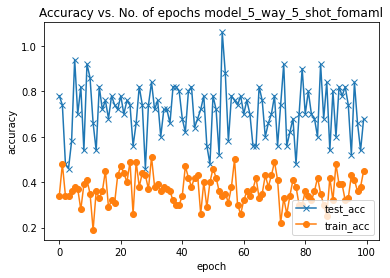

In [21]:
plot_accuracies(history4,'model_5_way_5_shot_fomaml')

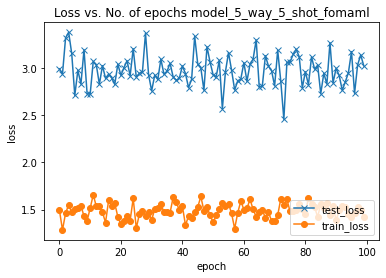

In [22]:
plot_losses(history4,'model_5_way_5_shot_fomaml')

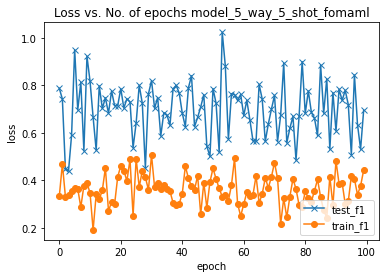

In [23]:
plot_f1(history4,'model_5_way_5_shot_fomaml')

In [ ]:
test_F_maml_4 = test_F_maml(model_5_way_5_shot_fomaml,10,5,5,5,10)

val_loss : 1.77 val_acc : 0.4900 val_F1: 0.4847
val_loss : 1.84 val_acc : 0.4350 val_F1: 0.4350
val_loss : 1.90 val_acc : 0.3850 val_F1: 0.3846
val_loss : 1.77 val_acc : 0.4900 val_F1: 0.4870
val_loss : 1.71 val_acc : 0.5550 val_F1: 0.5482
val_loss : 1.74 val_acc : 0.5500 val_F1: 0.5466
val_loss : 1.90 val_acc : 0.4200 val_F1: 0.4118
val_loss : 1.86 val_acc : 0.4300 val_F1: 0.4128
val_loss : 1.77 val_acc : 0.5400 val_F1: 0.5349
val_loss : 1.82 val_acc : 0.4500 val_F1: 0.4315


In [ ]:
print("model_5_way_5_shot_fomaml test :")
print(f"loss : {test_F_maml_4[0]:.2f}   acc: {test_F_maml_4[1]:.2f}  f1 : {test_F_maml_4[2]:.2f} ")

model_5_way_5_shot_fomaml test :
loss : 1.81   acc: 0.47  f1 : 0.47 


In [ ]:
Fomaml = False
scheduler = torch.optim.lr_scheduler.ExponentialLR
# scheduler = None
history5,model_5_way_1_shot_maml_with_scheduler = train_F_maml(Epochs,4,5,1,10,save_epoch,Fomaml,scheduler)

  0%|          | 0/20000 [00:00<?, ?it/s]

train_loss : 1.64 train_acc : 0.2650 train_F1: 0.2418


  0%|          | 1/20000 [00:00<1:10:56,  4.70it/s]

val_loss : 2.11 val_acc : 0.4000 val_F1: 0.3408
#####################################################################################


  1%|          | 201/20000 [00:23<46:19,  7.12it/s]

train_loss : 1.65 train_acc : 0.2600 train_F1: 0.2493
val_loss : 2.17 val_acc : 0.3667 val_F1: 0.3377
#####################################################################################


  2%|▏         | 401/20000 [00:46<47:21,  6.90it/s]

train_loss : 1.58 train_acc : 0.2950 train_F1: 0.2850
val_loss : 2.24 val_acc : 0.2467 val_F1: 0.2286
#####################################################################################


  3%|▎         | 601/20000 [01:09<45:56,  7.04it/s]

train_loss : 1.56 train_acc : 0.3450 train_F1: 0.3064
val_loss : 2.19 val_acc : 0.3200 val_F1: 0.3107
#####################################################################################


  4%|▍         | 801/20000 [01:32<46:02,  6.95it/s]

train_loss : 1.52 train_acc : 0.3650 train_F1: 0.3550
val_loss : 2.19 val_acc : 0.3133 val_F1: 0.2585
#####################################################################################


  5%|▌         | 1001/20000 [01:55<44:40,  7.09it/s]

train_loss : 1.62 train_acc : 0.1800 train_F1: 0.1597
val_loss : 2.15 val_acc : 0.4333 val_F1: 0.3877
#####################################################################################


  6%|▌         | 1201/20000 [02:19<46:20,  6.76it/s]

train_loss : 1.64 train_acc : 0.2550 train_F1: 0.2465
val_loss : 2.21 val_acc : 0.3533 val_F1: 0.3246
#####################################################################################


  7%|▋         | 1401/20000 [02:42<43:12,  7.18it/s]

train_loss : 1.57 train_acc : 0.2850 train_F1: 0.2795
val_loss : 2.15 val_acc : 0.4000 val_F1: 0.3571
#####################################################################################


  8%|▊         | 1601/20000 [03:04<44:00,  6.97it/s]

train_loss : 1.60 train_acc : 0.2800 train_F1: 0.2762
val_loss : 2.18 val_acc : 0.4133 val_F1: 0.3902
#####################################################################################


  9%|▉         | 1801/20000 [03:27<42:33,  7.13it/s]

train_loss : 1.60 train_acc : 0.3050 train_F1: 0.3016
val_loss : 2.18 val_acc : 0.3067 val_F1: 0.2854
#####################################################################################


 10%|█         | 2001/20000 [03:50<42:49,  7.00it/s]

train_loss : 1.53 train_acc : 0.3650 train_F1: 0.3595
val_loss : 2.10 val_acc : 0.3733 val_F1: 0.3404
#####################################################################################


 11%|█         | 2201/20000 [04:13<42:10,  7.03it/s]

train_loss : 1.52 train_acc : 0.3500 train_F1: 0.3136
val_loss : 2.09 val_acc : 0.3867 val_F1: 0.3494
#####################################################################################


 12%|█▏        | 2401/20000 [04:36<45:03,  6.51it/s]

train_loss : 1.56 train_acc : 0.3400 train_F1: 0.2980
val_loss : 2.19 val_acc : 0.3467 val_F1: 0.2919
#####################################################################################


 13%|█▎        | 2601/20000 [04:59<41:06,  7.05it/s]

train_loss : 1.57 train_acc : 0.2900 train_F1: 0.2677
val_loss : 2.23 val_acc : 0.3200 val_F1: 0.2823
#####################################################################################


 14%|█▍        | 2801/20000 [05:22<41:02,  6.98it/s]

train_loss : 1.60 train_acc : 0.2800 train_F1: 0.2440
val_loss : 2.18 val_acc : 0.3533 val_F1: 0.3356
#####################################################################################


 15%|█▌        | 3001/20000 [05:45<39:34,  7.16it/s]

train_loss : 1.56 train_acc : 0.3100 train_F1: 0.2661
val_loss : 2.19 val_acc : 0.3267 val_F1: 0.3116
#####################################################################################


 16%|█▌        | 3201/20000 [06:08<39:10,  7.15it/s]

train_loss : 1.59 train_acc : 0.3000 train_F1: 0.2919
val_loss : 2.13 val_acc : 0.3600 val_F1: 0.3306
#####################################################################################


 17%|█▋        | 3401/20000 [06:31<42:21,  6.53it/s]

train_loss : 1.60 train_acc : 0.2850 train_F1: 0.2708
val_loss : 2.20 val_acc : 0.3600 val_F1: 0.3052
#####################################################################################


 18%|█▊        | 3601/20000 [06:54<39:19,  6.95it/s]

train_loss : 1.63 train_acc : 0.2600 train_F1: 0.2360
val_loss : 2.13 val_acc : 0.3467 val_F1: 0.3055
#####################################################################################


 19%|█▉        | 3801/20000 [07:17<37:48,  7.14it/s]

train_loss : 1.60 train_acc : 0.2800 train_F1: 0.2602
val_loss : 2.12 val_acc : 0.3800 val_F1: 0.3454
#####################################################################################


 20%|██        | 4001/20000 [07:40<38:00,  7.01it/s]

train_loss : 1.56 train_acc : 0.3050 train_F1: 0.2877
val_loss : 2.14 val_acc : 0.3400 val_F1: 0.3018
#####################################################################################


 21%|██        | 4201/20000 [08:04<38:10,  6.90it/s]

train_loss : 1.57 train_acc : 0.3250 train_F1: 0.3012
val_loss : 2.05 val_acc : 0.4400 val_F1: 0.4151
#####################################################################################


 22%|██▏       | 4401/20000 [08:27<36:25,  7.14it/s]

train_loss : 1.66 train_acc : 0.2250 train_F1: 0.2226
val_loss : 2.21 val_acc : 0.3200 val_F1: 0.2718
#####################################################################################


 23%|██▎       | 4601/20000 [08:50<37:18,  6.88it/s]

train_loss : 1.54 train_acc : 0.3000 train_F1: 0.2855
val_loss : 2.16 val_acc : 0.3533 val_F1: 0.3194
#####################################################################################


 24%|██▍       | 4801/20000 [09:14<38:06,  6.65it/s]

train_loss : 1.59 train_acc : 0.3000 train_F1: 0.2830
val_loss : 2.19 val_acc : 0.3667 val_F1: 0.3310
#####################################################################################


 25%|██▌       | 5001/20000 [09:38<37:14,  6.71it/s]

train_loss : 1.52 train_acc : 0.2600 train_F1: 0.2206
val_loss : 2.16 val_acc : 0.3667 val_F1: 0.3477
#####################################################################################


 26%|██▌       | 5201/20000 [10:02<36:27,  6.77it/s]

train_loss : 1.59 train_acc : 0.2750 train_F1: 0.2578
val_loss : 2.15 val_acc : 0.3867 val_F1: 0.3328
#####################################################################################


 27%|██▋       | 5401/20000 [10:27<36:09,  6.73it/s]

train_loss : 1.64 train_acc : 0.2550 train_F1: 0.2403
val_loss : 2.19 val_acc : 0.3333 val_F1: 0.3047
#####################################################################################


 28%|██▊       | 5601/20000 [10:51<37:02,  6.48it/s]

train_loss : 1.66 train_acc : 0.2600 train_F1: 0.2438
val_loss : 2.25 val_acc : 0.3667 val_F1: 0.3406
#####################################################################################


 29%|██▉       | 5801/20000 [11:15<35:40,  6.63it/s]

train_loss : 1.61 train_acc : 0.2800 train_F1: 0.2553
val_loss : 2.09 val_acc : 0.4000 val_F1: 0.3464
#####################################################################################


 30%|███       | 6001/20000 [11:39<34:00,  6.86it/s]

train_loss : 1.55 train_acc : 0.3650 train_F1: 0.3209
val_loss : 2.08 val_acc : 0.4400 val_F1: 0.4129
#####################################################################################


 31%|███       | 6201/20000 [12:03<32:19,  7.11it/s]

train_loss : 1.61 train_acc : 0.2450 train_F1: 0.2148
val_loss : 2.06 val_acc : 0.4133 val_F1: 0.4035
#####################################################################################


 32%|███▏      | 6401/20000 [12:26<32:09,  7.05it/s]

train_loss : 1.55 train_acc : 0.3600 train_F1: 0.3272
val_loss : 2.21 val_acc : 0.3600 val_F1: 0.3125
#####################################################################################


 33%|███▎      | 6601/20000 [12:49<31:52,  7.01it/s]

train_loss : 1.59 train_acc : 0.3100 train_F1: 0.2808
val_loss : 2.15 val_acc : 0.4267 val_F1: 0.3837
#####################################################################################


 34%|███▍      | 6801/20000 [13:12<31:18,  7.02it/s]

train_loss : 1.59 train_acc : 0.2700 train_F1: 0.2446
val_loss : 2.23 val_acc : 0.3733 val_F1: 0.3544
#####################################################################################


 35%|███▌      | 7001/20000 [13:34<30:59,  6.99it/s]

train_loss : 1.61 train_acc : 0.3200 train_F1: 0.2986
val_loss : 2.24 val_acc : 0.2733 val_F1: 0.2370
#####################################################################################


 36%|███▌      | 7201/20000 [13:57<30:10,  7.07it/s]

train_loss : 1.62 train_acc : 0.2750 train_F1: 0.2517
val_loss : 2.14 val_acc : 0.4400 val_F1: 0.4290
#####################################################################################


 37%|███▋      | 7401/20000 [14:20<29:22,  7.15it/s]

train_loss : 1.61 train_acc : 0.3000 train_F1: 0.2653
val_loss : 2.14 val_acc : 0.3067 val_F1: 0.2759
#####################################################################################


 38%|███▊      | 7601/20000 [14:43<29:25,  7.02it/s]

train_loss : 1.55 train_acc : 0.3300 train_F1: 0.3080
val_loss : 2.15 val_acc : 0.3467 val_F1: 0.3180
#####################################################################################


 39%|███▉      | 7801/20000 [15:06<28:59,  7.01it/s]

train_loss : 1.49 train_acc : 0.3550 train_F1: 0.3366
val_loss : 2.11 val_acc : 0.4267 val_F1: 0.3949
#####################################################################################


 40%|████      | 8001/20000 [15:28<28:08,  7.11it/s]

train_loss : 1.58 train_acc : 0.2950 train_F1: 0.2730
val_loss : 2.16 val_acc : 0.3600 val_F1: 0.3387
#####################################################################################


 41%|████      | 8201/20000 [15:51<28:12,  6.97it/s]

train_loss : 1.60 train_acc : 0.2650 train_F1: 0.2341
val_loss : 2.21 val_acc : 0.3667 val_F1: 0.3247
#####################################################################################


 42%|████▏     | 8401/20000 [16:14<27:18,  7.08it/s]

train_loss : 1.59 train_acc : 0.3800 train_F1: 0.3440
val_loss : 2.37 val_acc : 0.2933 val_F1: 0.2703
#####################################################################################


 43%|████▎     | 8601/20000 [16:37<26:50,  7.08it/s]

train_loss : 1.57 train_acc : 0.3450 train_F1: 0.3260
val_loss : 2.07 val_acc : 0.3600 val_F1: 0.2979
#####################################################################################


 44%|████▍     | 8801/20000 [17:00<26:26,  7.06it/s]

train_loss : 1.57 train_acc : 0.2950 train_F1: 0.2734
val_loss : 2.12 val_acc : 0.3600 val_F1: 0.3416
#####################################################################################


 45%|████▌     | 9001/20000 [17:22<25:52,  7.08it/s]

train_loss : 1.53 train_acc : 0.3300 train_F1: 0.3019
val_loss : 2.18 val_acc : 0.3600 val_F1: 0.3341
#####################################################################################


 46%|████▌     | 9201/20000 [17:45<25:08,  7.16it/s]

train_loss : 1.55 train_acc : 0.2650 train_F1: 0.2425
val_loss : 2.18 val_acc : 0.3133 val_F1: 0.2802
#####################################################################################


 47%|████▋     | 9401/20000 [18:08<25:01,  7.06it/s]

train_loss : 1.61 train_acc : 0.2450 train_F1: 0.2222
val_loss : 2.11 val_acc : 0.3267 val_F1: 0.2948
#####################################################################################


 48%|████▊     | 9601/20000 [18:31<24:12,  7.16it/s]

train_loss : 1.68 train_acc : 0.2550 train_F1: 0.2259
val_loss : 2.04 val_acc : 0.4200 val_F1: 0.3922
#####################################################################################


 49%|████▉     | 9801/20000 [18:54<24:49,  6.85it/s]

train_loss : 1.52 train_acc : 0.3150 train_F1: 0.2930
val_loss : 2.28 val_acc : 0.2733 val_F1: 0.2683
#####################################################################################


 50%|█████     | 10001/20000 [19:17<23:33,  7.07it/s]

train_loss : 1.57 train_acc : 0.3050 train_F1: 0.2995
val_loss : 2.24 val_acc : 0.2800 val_F1: 0.2562
#####################################################################################


 51%|█████     | 10201/20000 [19:40<23:18,  7.01it/s]

train_loss : 1.57 train_acc : 0.2950 train_F1: 0.2759
val_loss : 2.20 val_acc : 0.3667 val_F1: 0.3296
#####################################################################################


 52%|█████▏    | 10401/20000 [20:02<22:46,  7.02it/s]

train_loss : 1.50 train_acc : 0.3250 train_F1: 0.3202
val_loss : 2.08 val_acc : 0.3867 val_F1: 0.3523
#####################################################################################


 53%|█████▎    | 10601/20000 [20:25<22:27,  6.97it/s]

train_loss : 1.58 train_acc : 0.2900 train_F1: 0.2753
val_loss : 2.15 val_acc : 0.3800 val_F1: 0.3361
#####################################################################################


 54%|█████▍    | 10801/20000 [20:48<21:30,  7.13it/s]

train_loss : 1.54 train_acc : 0.3150 train_F1: 0.2979
val_loss : 2.06 val_acc : 0.4800 val_F1: 0.4311
#####################################################################################


 55%|█████▌    | 11001/20000 [21:11<21:46,  6.89it/s]

train_loss : 1.54 train_acc : 0.2900 train_F1: 0.2857
val_loss : 2.23 val_acc : 0.2867 val_F1: 0.2485
#####################################################################################


 56%|█████▌    | 11201/20000 [21:34<20:47,  7.05it/s]

train_loss : 1.52 train_acc : 0.3450 train_F1: 0.3134
val_loss : 2.21 val_acc : 0.3000 val_F1: 0.2927
#####################################################################################


 57%|█████▋    | 11401/20000 [21:57<20:11,  7.10it/s]

train_loss : 1.56 train_acc : 0.3100 train_F1: 0.2940
val_loss : 2.20 val_acc : 0.3467 val_F1: 0.3160
#####################################################################################


 58%|█████▊    | 11601/20000 [22:21<21:22,  6.55it/s]

train_loss : 1.58 train_acc : 0.3300 train_F1: 0.3000
val_loss : 1.98 val_acc : 0.5000 val_F1: 0.4589
#####################################################################################


 59%|█████▉    | 11801/20000 [22:46<21:08,  6.46it/s]

train_loss : 1.58 train_acc : 0.2550 train_F1: 0.2361
val_loss : 2.27 val_acc : 0.2600 val_F1: 0.2385
#####################################################################################


 60%|██████    | 12001/20000 [23:10<20:30,  6.50it/s]

train_loss : 1.57 train_acc : 0.2750 train_F1: 0.2541
val_loss : 2.23 val_acc : 0.3400 val_F1: 0.3272
#####################################################################################


 61%|██████    | 12201/20000 [23:35<19:10,  6.78it/s]

train_loss : 1.53 train_acc : 0.3250 train_F1: 0.2898
val_loss : 2.10 val_acc : 0.3267 val_F1: 0.3191
#####################################################################################


 62%|██████▏   | 12401/20000 [24:00<19:17,  6.57it/s]

train_loss : 1.56 train_acc : 0.3200 train_F1: 0.3036
val_loss : 2.20 val_acc : 0.2933 val_F1: 0.2726
#####################################################################################


 63%|██████▎   | 12601/20000 [24:24<18:51,  6.54it/s]

train_loss : 1.54 train_acc : 0.3050 train_F1: 0.2753
val_loss : 2.21 val_acc : 0.3267 val_F1: 0.3132
#####################################################################################


 64%|██████▍   | 12801/20000 [24:49<18:05,  6.63it/s]

train_loss : 1.54 train_acc : 0.2800 train_F1: 0.2725
val_loss : 2.35 val_acc : 0.2800 val_F1: 0.2773
#####################################################################################


 65%|██████▌   | 13001/20000 [25:13<17:08,  6.80it/s]

train_loss : 1.61 train_acc : 0.2650 train_F1: 0.2424
val_loss : 2.19 val_acc : 0.3267 val_F1: 0.2874
#####################################################################################


 66%|██████▌   | 13201/20000 [25:38<17:20,  6.54it/s]

train_loss : 1.58 train_acc : 0.3000 train_F1: 0.2627
val_loss : 2.12 val_acc : 0.4000 val_F1: 0.3735
#####################################################################################


 67%|██████▋   | 13401/20000 [26:03<16:24,  6.70it/s]

train_loss : 1.56 train_acc : 0.3000 train_F1: 0.2717
val_loss : 2.13 val_acc : 0.3667 val_F1: 0.3492
#####################################################################################


 68%|██████▊   | 13601/20000 [26:26<14:53,  7.16it/s]

train_loss : 1.55 train_acc : 0.3400 train_F1: 0.3121
val_loss : 2.25 val_acc : 0.2800 val_F1: 0.2513
#####################################################################################


 69%|██████▉   | 13801/20000 [26:48<14:25,  7.16it/s]

train_loss : 1.55 train_acc : 0.3200 train_F1: 0.3027
val_loss : 2.09 val_acc : 0.3800 val_F1: 0.3251
#####################################################################################


 70%|███████   | 14001/20000 [27:11<13:49,  7.23it/s]

train_loss : 1.52 train_acc : 0.3400 train_F1: 0.3249
val_loss : 2.01 val_acc : 0.4867 val_F1: 0.4517
#####################################################################################


 71%|███████   | 14201/20000 [27:33<13:27,  7.18it/s]

train_loss : 1.63 train_acc : 0.2650 train_F1: 0.2588
val_loss : 2.20 val_acc : 0.3600 val_F1: 0.3251
#####################################################################################


 72%|███████▏  | 14401/20000 [27:56<14:22,  6.49it/s]

train_loss : 1.62 train_acc : 0.2650 train_F1: 0.2562
val_loss : 2.08 val_acc : 0.3800 val_F1: 0.3098
#####################################################################################


 73%|███████▎  | 14601/20000 [28:19<12:23,  7.26it/s]

train_loss : 1.49 train_acc : 0.3700 train_F1: 0.3316
val_loss : 2.17 val_acc : 0.3733 val_F1: 0.3580
#####################################################################################


 74%|███████▍  | 14801/20000 [28:41<12:10,  7.11it/s]

train_loss : 1.62 train_acc : 0.2450 train_F1: 0.2265
val_loss : 2.18 val_acc : 0.3467 val_F1: 0.3086
#####################################################################################


 75%|███████▌  | 15001/20000 [29:04<11:34,  7.19it/s]

train_loss : 1.46 train_acc : 0.4350 train_F1: 0.4127
val_loss : 2.12 val_acc : 0.3267 val_F1: 0.2863
#####################################################################################


 76%|███████▌  | 15201/20000 [29:26<11:09,  7.17it/s]

train_loss : 1.65 train_acc : 0.2550 train_F1: 0.2454
val_loss : 2.16 val_acc : 0.3000 val_F1: 0.2815
#####################################################################################


 77%|███████▋  | 15401/20000 [29:49<10:39,  7.19it/s]

train_loss : 1.53 train_acc : 0.3050 train_F1: 0.2861
val_loss : 2.17 val_acc : 0.3400 val_F1: 0.3052
#####################################################################################


 78%|███████▊  | 15601/20000 [30:11<10:03,  7.29it/s]

train_loss : 1.66 train_acc : 0.2400 train_F1: 0.2325
val_loss : 2.08 val_acc : 0.4333 val_F1: 0.4145
#####################################################################################


 79%|███████▉  | 15801/20000 [30:33<09:39,  7.25it/s]

train_loss : 1.52 train_acc : 0.3150 train_F1: 0.2954
val_loss : 2.10 val_acc : 0.4533 val_F1: 0.4052
#####################################################################################


 80%|████████  | 16001/20000 [30:55<09:13,  7.22it/s]

train_loss : 1.56 train_acc : 0.3400 train_F1: 0.3322
val_loss : 2.12 val_acc : 0.4000 val_F1: 0.3640
#####################################################################################


 81%|████████  | 16201/20000 [31:18<08:44,  7.24it/s]

train_loss : 1.54 train_acc : 0.3250 train_F1: 0.2983
val_loss : 2.11 val_acc : 0.3933 val_F1: 0.3597
#####################################################################################


 82%|████████▏ | 16401/20000 [31:40<08:44,  6.86it/s]

train_loss : 1.57 train_acc : 0.2650 train_F1: 0.2457
val_loss : 2.09 val_acc : 0.4133 val_F1: 0.3560
#####################################################################################


 83%|████████▎ | 16601/20000 [32:03<07:56,  7.13it/s]

train_loss : 1.57 train_acc : 0.3300 train_F1: 0.2997
val_loss : 2.16 val_acc : 0.3667 val_F1: 0.3359
#####################################################################################


 84%|████████▍ | 16801/20000 [32:25<07:24,  7.20it/s]

train_loss : 1.59 train_acc : 0.2750 train_F1: 0.2464
val_loss : 2.08 val_acc : 0.4067 val_F1: 0.3902
#####################################################################################


 85%|████████▌ | 17001/20000 [32:48<06:53,  7.25it/s]

train_loss : 1.58 train_acc : 0.2750 train_F1: 0.2575
val_loss : 2.08 val_acc : 0.4400 val_F1: 0.4000
#####################################################################################


 86%|████████▌ | 17201/20000 [33:10<06:31,  7.15it/s]

train_loss : 1.55 train_acc : 0.3100 train_F1: 0.2886
val_loss : 2.16 val_acc : 0.3800 val_F1: 0.3601
#####################################################################################


 87%|████████▋ | 17401/20000 [33:33<06:13,  6.95it/s]

train_loss : 1.53 train_acc : 0.2900 train_F1: 0.2792
val_loss : 2.11 val_acc : 0.3867 val_F1: 0.3465
#####################################################################################


 88%|████████▊ | 17601/20000 [33:58<06:12,  6.44it/s]

train_loss : 1.63 train_acc : 0.2350 train_F1: 0.2151
val_loss : 2.15 val_acc : 0.3733 val_F1: 0.3398
#####################################################################################


 89%|████████▉ | 17801/20000 [34:23<05:44,  6.39it/s]

train_loss : 1.55 train_acc : 0.2950 train_F1: 0.2547
val_loss : 2.23 val_acc : 0.3267 val_F1: 0.2879
#####################################################################################


 90%|█████████ | 18001/20000 [34:47<05:09,  6.46it/s]

train_loss : 1.57 train_acc : 0.3300 train_F1: 0.3052
val_loss : 2.24 val_acc : 0.3200 val_F1: 0.2732
#####################################################################################


 91%|█████████ | 18201/20000 [35:13<04:25,  6.76it/s]

train_loss : 1.55 train_acc : 0.3550 train_F1: 0.3311
val_loss : 1.97 val_acc : 0.4933 val_F1: 0.4501
#####################################################################################


 92%|█████████▏| 18401/20000 [35:37<03:57,  6.73it/s]

train_loss : 1.66 train_acc : 0.2600 train_F1: 0.2501
val_loss : 2.16 val_acc : 0.3333 val_F1: 0.3127
#####################################################################################


 93%|█████████▎| 18601/20000 [36:01<03:23,  6.89it/s]

train_loss : 1.56 train_acc : 0.3050 train_F1: 0.2930
val_loss : 2.14 val_acc : 0.3667 val_F1: 0.3376
#####################################################################################


 94%|█████████▍| 18801/20000 [36:25<02:54,  6.88it/s]

train_loss : 1.51 train_acc : 0.3650 train_F1: 0.3322
val_loss : 2.20 val_acc : 0.4067 val_F1: 0.3694
#####################################################################################


 95%|█████████▌| 19001/20000 [36:49<02:31,  6.60it/s]

train_loss : 1.58 train_acc : 0.2750 train_F1: 0.2670
val_loss : 2.21 val_acc : 0.3733 val_F1: 0.3516
#####################################################################################


 96%|█████████▌| 19201/20000 [37:14<02:00,  6.64it/s]

train_loss : 1.57 train_acc : 0.2750 train_F1: 0.2633
val_loss : 2.05 val_acc : 0.4067 val_F1: 0.3783
#####################################################################################


 97%|█████████▋| 19401/20000 [37:39<01:33,  6.40it/s]

train_loss : 1.54 train_acc : 0.3400 train_F1: 0.2935
val_loss : 2.20 val_acc : 0.3400 val_F1: 0.2955
#####################################################################################


 98%|█████████▊| 19601/20000 [38:02<00:54,  7.26it/s]

train_loss : 1.54 train_acc : 0.3050 train_F1: 0.2697
val_loss : 2.31 val_acc : 0.2667 val_F1: 0.2420
#####################################################################################


 99%|█████████▉| 19801/20000 [38:25<00:27,  7.18it/s]

train_loss : 1.61 train_acc : 0.2750 train_F1: 0.2489
val_loss : 2.06 val_acc : 0.3933 val_F1: 0.3699
#####################################################################################


100%|██████████| 20000/20000 [38:47<00:00,  8.59it/s]


In [ ]:
joblib.dump(model_5_way_1_shot_maml_with_scheduler, 'model_5_way_1_shot_maml_with_scheduler')
joblib.dump(history5,'history5')

['history5']

In [24]:
history5 = joblib.load('history5')

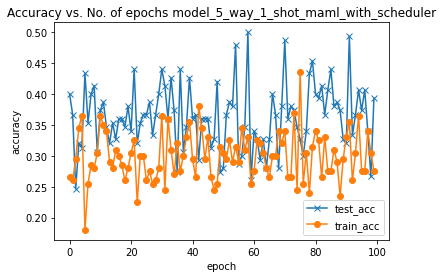

In [25]:
plot_accuracies(history5,'model_5_way_1_shot_maml_with_scheduler')

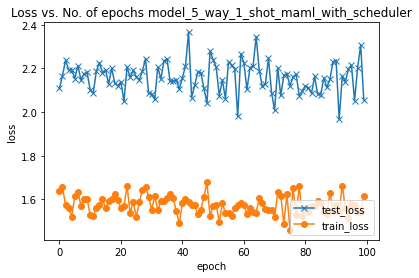

In [26]:
plot_losses(history5,'model_5_way_1_shot_maml_with_scheduler')

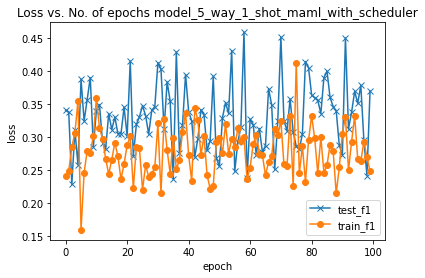

In [27]:
plot_f1(history5,'model_5_way_1_shot_maml_with_scheduler')

In [ ]:
test_F_maml_5 = test_F_maml(model_5_way_1_shot_maml_with_scheduler,10,5,5,1,10)

val_loss : 1.96 val_acc : 0.3450 val_F1: 0.3098
val_loss : 2.06 val_acc : 0.3300 val_F1: 0.2924
val_loss : 2.04 val_acc : 0.3350 val_F1: 0.3204
val_loss : 2.09 val_acc : 0.3100 val_F1: 0.2789
val_loss : 2.01 val_acc : 0.3750 val_F1: 0.3389
val_loss : 2.00 val_acc : 0.3400 val_F1: 0.3133
val_loss : 2.02 val_acc : 0.3200 val_F1: 0.2947
val_loss : 2.00 val_acc : 0.3300 val_F1: 0.2829
val_loss : 2.04 val_acc : 0.3100 val_F1: 0.2860
val_loss : 2.06 val_acc : 0.2950 val_F1: 0.2744


In [ ]:
print("model_5_way_1_shot_maml_with_scheduler test :")
print(f"loss : {test_F_maml_5[0]:.2f}   acc: {test_F_maml_5[1]:.2f}  f1 : {test_F_maml_5[2]:.2f} ")

model_5_way_1_shot_maml_with_scheduler test :
loss : 2.03   acc: 0.33  f1 : 0.30 


In [ ]:
Fomaml = False
scheduler = torch.optim.lr_scheduler.ExponentialLR
# scheduler = None
history6,model_5_way_5_shot_maml_with_scheduler = train_F_maml(Epochs,2,5,5,10,save_epoch,Fomaml,scheduler)

  0%|          | 1/20000 [00:00<48:56,  6.81it/s]

train_loss : 1.37 train_acc : 0.4600 train_F1: 0.4592
val_loss : 2.96 val_acc : 0.6800 val_F1: 0.6568
#####################################################################################


  1%|          | 201/20000 [00:17<32:05, 10.28it/s]

train_loss : 1.59 train_acc : 0.2400 train_F1: 0.2391
val_loss : 2.83 val_acc : 0.8200 val_F1: 0.7974
#####################################################################################


  2%|▏         | 401/20000 [00:36<32:44,  9.98it/s]

train_loss : 1.40 train_acc : 0.4100 train_F1: 0.3884
val_loss : 2.95 val_acc : 0.7400 val_F1: 0.7532
#####################################################################################


  3%|▎         | 601/20000 [00:54<32:35,  9.92it/s]

train_loss : 1.33 train_acc : 0.5000 train_F1: 0.4762
val_loss : 2.91 val_acc : 0.7800 val_F1: 0.7758
#####################################################################################


  4%|▍         | 801/20000 [01:12<31:59, 10.00it/s]

train_loss : 1.38 train_acc : 0.4200 train_F1: 0.3907
val_loss : 3.06 val_acc : 0.6600 val_F1: 0.6370
#####################################################################################


  5%|▌         | 1001/20000 [01:31<31:40, 10.00it/s]

train_loss : 1.40 train_acc : 0.4600 train_F1: 0.4395
val_loss : 2.93 val_acc : 0.7800 val_F1: 0.7775
#####################################################################################


  6%|▌         | 1201/20000 [01:49<31:03, 10.09it/s]

train_loss : 1.43 train_acc : 0.4100 train_F1: 0.4075
val_loss : 3.07 val_acc : 0.7400 val_F1: 0.7458
#####################################################################################


  7%|▋         | 1401/20000 [02:07<31:25,  9.86it/s]

train_loss : 1.51 train_acc : 0.3300 train_F1: 0.3016
val_loss : 2.85 val_acc : 0.7800 val_F1: 0.7391
#####################################################################################


  8%|▊         | 1601/20000 [02:26<29:51, 10.27it/s]

train_loss : 1.45 train_acc : 0.3500 train_F1: 0.3315
val_loss : 3.19 val_acc : 0.5200 val_F1: 0.4966
#####################################################################################


  9%|▉         | 1801/20000 [02:44<30:28,  9.95it/s]

train_loss : 1.61 train_acc : 0.2400 train_F1: 0.2340
val_loss : 2.97 val_acc : 0.8200 val_F1: 0.8019
#####################################################################################


 10%|█         | 2001/20000 [03:02<31:11,  9.62it/s]

train_loss : 1.54 train_acc : 0.2700 train_F1: 0.2607
val_loss : 3.38 val_acc : 0.4400 val_F1: 0.4245
#####################################################################################


 11%|█         | 2201/20000 [03:21<30:40,  9.67it/s]

train_loss : 1.38 train_acc : 0.4200 train_F1: 0.3999
val_loss : 2.77 val_acc : 0.7800 val_F1: 0.7590
#####################################################################################


 12%|█▏        | 2401/20000 [03:40<29:52,  9.82it/s]

train_loss : 1.62 train_acc : 0.2300 train_F1: 0.2223
val_loss : 3.20 val_acc : 0.6400 val_F1: 0.6096
#####################################################################################


 13%|█▎        | 2601/20000 [03:59<29:31,  9.82it/s]

train_loss : 1.36 train_acc : 0.4700 train_F1: 0.4511
val_loss : 2.80 val_acc : 1.0200 val_F1: 1.0322
#####################################################################################


 14%|█▍        | 2801/20000 [04:18<30:10,  9.50it/s]

train_loss : 1.47 train_acc : 0.3400 train_F1: 0.3205
val_loss : 2.61 val_acc : 0.9400 val_F1: 0.9278
#####################################################################################


 15%|█▌        | 3001/20000 [04:37<29:13,  9.70it/s]

train_loss : 1.44 train_acc : 0.3800 train_F1: 0.3751
val_loss : 3.12 val_acc : 0.6600 val_F1: 0.6470
#####################################################################################


 16%|█▌        | 3201/20000 [04:56<29:11,  9.59it/s]

train_loss : 1.49 train_acc : 0.3800 train_F1: 0.3835
val_loss : 2.95 val_acc : 0.7400 val_F1: 0.7322
#####################################################################################


 17%|█▋        | 3400/20000 [05:15<26:28, 10.45it/s]

train_loss : 1.36 train_acc : 0.5700 train_F1: 0.5645
val_loss : 2.82 val_acc : 0.8200 val_F1: 0.8016
#####################################################################################


 18%|█▊        | 3602/20000 [05:35<28:26,  9.61it/s]

train_loss : 1.52 train_acc : 0.3200 train_F1: 0.2894
val_loss : 2.90 val_acc : 0.7200 val_F1: 0.7191
#####################################################################################


 19%|█▉        | 3801/20000 [05:53<27:40,  9.75it/s]

train_loss : 1.38 train_acc : 0.4300 train_F1: 0.4317
val_loss : 2.83 val_acc : 0.6600 val_F1: 0.6418
#####################################################################################


 20%|██        | 4001/20000 [06:12<27:30,  9.69it/s]

train_loss : 1.48 train_acc : 0.3600 train_F1: 0.3361
val_loss : 3.33 val_acc : 0.6000 val_F1: 0.5863
#####################################################################################


 21%|██        | 4201/20000 [06:31<25:44, 10.23it/s]

train_loss : 1.44 train_acc : 0.4300 train_F1: 0.4023
val_loss : 2.79 val_acc : 0.9200 val_F1: 0.9243
#####################################################################################


 22%|██▏       | 4401/20000 [06:49<27:14,  9.54it/s]

train_loss : 1.37 train_acc : 0.4800 train_F1: 0.4822
val_loss : 2.78 val_acc : 0.8600 val_F1: 0.8571
#####################################################################################


 23%|██▎       | 4601/20000 [07:08<25:47,  9.95it/s]

train_loss : 1.38 train_acc : 0.4800 train_F1: 0.4731
val_loss : 3.04 val_acc : 0.6400 val_F1: 0.6432
#####################################################################################


 24%|██▍       | 4801/20000 [07:26<25:07, 10.08it/s]

train_loss : 1.54 train_acc : 0.2700 train_F1: 0.2528
val_loss : 2.84 val_acc : 0.7400 val_F1: 0.7077
#####################################################################################


 25%|██▌       | 5001/20000 [07:45<25:25,  9.83it/s]

train_loss : 1.34 train_acc : 0.4900 train_F1: 0.4896
val_loss : 3.03 val_acc : 0.7600 val_F1: 0.7508
#####################################################################################


 26%|██▌       | 5201/20000 [08:03<24:04, 10.24it/s]

train_loss : 1.44 train_acc : 0.3400 train_F1: 0.3274
val_loss : 2.82 val_acc : 0.9000 val_F1: 0.8834
#####################################################################################


 27%|██▋       | 5401/20000 [08:21<24:14, 10.04it/s]

train_loss : 1.49 train_acc : 0.3600 train_F1: 0.3530
val_loss : 3.05 val_acc : 0.6000 val_F1: 0.5922
#####################################################################################


 28%|██▊       | 5601/20000 [08:39<25:21,  9.46it/s]

train_loss : 1.55 train_acc : 0.3200 train_F1: 0.3242
val_loss : 2.88 val_acc : 0.6400 val_F1: 0.6252
#####################################################################################


 29%|██▉       | 5801/20000 [08:58<25:07,  9.42it/s]

train_loss : 1.46 train_acc : 0.3900 train_F1: 0.3887
val_loss : 3.04 val_acc : 0.6800 val_F1: 0.6303
#####################################################################################


 30%|███       | 6001/20000 [09:17<22:47, 10.24it/s]

train_loss : 1.54 train_acc : 0.3600 train_F1: 0.3441
val_loss : 3.07 val_acc : 0.6000 val_F1: 0.5878
#####################################################################################


 31%|███       | 6201/20000 [09:35<23:17,  9.88it/s]

train_loss : 1.36 train_acc : 0.4200 train_F1: 0.4112
val_loss : 2.86 val_acc : 0.8400 val_F1: 0.8478
#####################################################################################


 32%|███▏      | 6401/20000 [09:54<22:24, 10.11it/s]

train_loss : 1.34 train_acc : 0.4600 train_F1: 0.4272
val_loss : 3.22 val_acc : 0.5400 val_F1: 0.5042
#####################################################################################


 33%|███▎      | 6601/20000 [10:12<23:14,  9.61it/s]

train_loss : 1.41 train_acc : 0.3900 train_F1: 0.3912
val_loss : 3.30 val_acc : 0.5800 val_F1: 0.5722
#####################################################################################


 34%|███▍      | 6801/20000 [10:31<21:45, 10.11it/s]

train_loss : 1.59 train_acc : 0.2900 train_F1: 0.2752
val_loss : 2.95 val_acc : 0.7000 val_F1: 0.6756
#####################################################################################


 35%|███▌      | 7001/20000 [10:49<22:20,  9.70it/s]

train_loss : 1.58 train_acc : 0.2600 train_F1: 0.2501
val_loss : 3.08 val_acc : 0.7400 val_F1: 0.7076
#####################################################################################


 36%|███▌      | 7201/20000 [11:08<21:19, 10.01it/s]

train_loss : 1.52 train_acc : 0.2900 train_F1: 0.2777
val_loss : 2.97 val_acc : 0.6400 val_F1: 0.6364
#####################################################################################


 37%|███▋      | 7401/20000 [11:26<21:18,  9.86it/s]

train_loss : 1.53 train_acc : 0.3600 train_F1: 0.3631
val_loss : 3.07 val_acc : 0.4800 val_F1: 0.4925
#####################################################################################


 38%|███▊      | 7601/20000 [11:44<20:22, 10.15it/s]

train_loss : 1.43 train_acc : 0.3600 train_F1: 0.3437
val_loss : 2.83 val_acc : 0.8400 val_F1: 0.7954
#####################################################################################


 39%|███▉      | 7801/20000 [12:03<20:22,  9.98it/s]

train_loss : 1.37 train_acc : 0.4700 train_F1: 0.4554
val_loss : 2.86 val_acc : 0.7600 val_F1: 0.7443
#####################################################################################


 40%|████      | 8001/20000 [12:21<19:38, 10.18it/s]

train_loss : 1.42 train_acc : 0.4200 train_F1: 0.4190
val_loss : 2.94 val_acc : 0.7200 val_F1: 0.7280
#####################################################################################


 41%|████      | 8201/20000 [12:39<19:42,  9.97it/s]

train_loss : 1.54 train_acc : 0.3300 train_F1: 0.3247
val_loss : 3.28 val_acc : 0.5000 val_F1: 0.4658
#####################################################################################


 42%|████▏     | 8401/20000 [12:57<19:55,  9.70it/s]

train_loss : 1.36 train_acc : 0.4600 train_F1: 0.4494
val_loss : 2.59 val_acc : 0.8800 val_F1: 0.8479
#####################################################################################


 43%|████▎     | 8601/20000 [13:16<19:42,  9.64it/s]

train_loss : 1.52 train_acc : 0.3200 train_F1: 0.3142
val_loss : 2.92 val_acc : 0.6800 val_F1: 0.6253
#####################################################################################


 44%|████▍     | 8801/20000 [13:34<18:19, 10.18it/s]

train_loss : 1.54 train_acc : 0.3300 train_F1: 0.3223
val_loss : 3.02 val_acc : 0.6200 val_F1: 0.6369
#####################################################################################


 45%|████▌     | 9001/20000 [13:53<18:29,  9.91it/s]

train_loss : 1.47 train_acc : 0.3600 train_F1: 0.3468
val_loss : 2.96 val_acc : 0.7000 val_F1: 0.7146
#####################################################################################


 46%|████▌     | 9201/20000 [14:11<17:42, 10.16it/s]

train_loss : 1.42 train_acc : 0.3700 train_F1: 0.3512
val_loss : 3.07 val_acc : 0.5600 val_F1: 0.5412
#####################################################################################


 47%|████▋     | 9401/20000 [14:29<17:13, 10.25it/s]

train_loss : 1.46 train_acc : 0.3400 train_F1: 0.3405
val_loss : 2.90 val_acc : 0.9200 val_F1: 0.9087
#####################################################################################


 48%|████▊     | 9601/20000 [14:47<17:49,  9.72it/s]

train_loss : 1.42 train_acc : 0.4200 train_F1: 0.4159
val_loss : 2.78 val_acc : 0.8800 val_F1: 0.8722
#####################################################################################


 49%|████▉     | 9801/20000 [15:05<16:37, 10.23it/s]

train_loss : 1.45 train_acc : 0.3000 train_F1: 0.2826
val_loss : 2.95 val_acc : 0.7200 val_F1: 0.7066
#####################################################################################


 50%|█████     | 10001/20000 [15:23<16:41,  9.98it/s]

train_loss : 1.64 train_acc : 0.2800 train_F1: 0.2676
val_loss : 3.06 val_acc : 0.7400 val_F1: 0.7584
#####################################################################################


 51%|█████     | 10201/20000 [15:42<16:17, 10.03it/s]

train_loss : 1.47 train_acc : 0.4400 train_F1: 0.4378
val_loss : 2.91 val_acc : 0.6600 val_F1: 0.6448
#####################################################################################


 52%|█████▏    | 10401/20000 [16:00<16:00, 10.00it/s]

train_loss : 1.40 train_acc : 0.4600 train_F1: 0.4380
val_loss : 2.99 val_acc : 0.5600 val_F1: 0.5350
#####################################################################################


 53%|█████▎    | 10601/20000 [16:18<15:35, 10.05it/s]

train_loss : 1.43 train_acc : 0.3800 train_F1: 0.3895
val_loss : 2.99 val_acc : 0.7600 val_F1: 0.7512
#####################################################################################


 54%|█████▍    | 10801/20000 [16:37<15:15, 10.05it/s]

train_loss : 1.47 train_acc : 0.3900 train_F1: 0.3681
val_loss : 2.84 val_acc : 0.9000 val_F1: 0.8622
#####################################################################################


 55%|█████▌    | 11001/20000 [16:55<14:51, 10.09it/s]

train_loss : 1.35 train_acc : 0.4300 train_F1: 0.4243
val_loss : 2.82 val_acc : 0.7000 val_F1: 0.6977
#####################################################################################


 56%|█████▌    | 11201/20000 [17:15<17:05,  8.58it/s]

train_loss : 1.50 train_acc : 0.3700 train_F1: 0.3483
val_loss : 2.88 val_acc : 0.8200 val_F1: 0.7798
#####################################################################################


 57%|█████▋    | 11400/20000 [17:35<13:51, 10.34it/s]

train_loss : 1.50 train_acc : 0.2600 train_F1: 0.2510
val_loss : 2.86 val_acc : 0.8400 val_F1: 0.8299
#####################################################################################


 58%|█████▊    | 11601/20000 [17:55<14:50,  9.44it/s]

train_loss : 1.55 train_acc : 0.2700 train_F1: 0.2666
val_loss : 2.90 val_acc : 0.8000 val_F1: 0.7888
#####################################################################################


 59%|█████▉    | 11801/20000 [18:14<13:26, 10.16it/s]

train_loss : 1.38 train_acc : 0.4800 train_F1: 0.4715
val_loss : 2.97 val_acc : 0.7800 val_F1: 0.7403
#####################################################################################


 60%|██████    | 12001/20000 [18:32<13:10, 10.12it/s]

train_loss : 1.38 train_acc : 0.4300 train_F1: 0.4169
val_loss : 3.03 val_acc : 0.7200 val_F1: 0.7084
#####################################################################################


 61%|██████    | 12202/20000 [18:51<12:56, 10.04it/s]

train_loss : 1.55 train_acc : 0.3300 train_F1: 0.3106
val_loss : 3.10 val_acc : 0.7200 val_F1: 0.6936
#####################################################################################


 62%|██████▏   | 12402/20000 [19:09<12:36, 10.04it/s]

train_loss : 1.35 train_acc : 0.4900 train_F1: 0.4620
val_loss : 2.88 val_acc : 0.8000 val_F1: 0.7943
#####################################################################################


 63%|██████▎   | 12602/20000 [19:27<12:39,  9.75it/s]

train_loss : 1.57 train_acc : 0.3300 train_F1: 0.3295
val_loss : 2.73 val_acc : 0.8800 val_F1: 0.8688
#####################################################################################


 64%|██████▍   | 12801/20000 [19:45<11:42, 10.25it/s]

train_loss : 1.46 train_acc : 0.4000 train_F1: 0.3753
val_loss : 3.18 val_acc : 0.6600 val_F1: 0.6708
#####################################################################################


 65%|██████▌   | 13001/20000 [20:04<11:59,  9.73it/s]

train_loss : 1.57 train_acc : 0.2600 train_F1: 0.2420
val_loss : 2.94 val_acc : 0.8000 val_F1: 0.7906
#####################################################################################


 66%|██████▌   | 13201/20000 [20:22<11:16, 10.05it/s]

train_loss : 1.42 train_acc : 0.4200 train_F1: 0.4201
val_loss : 2.88 val_acc : 0.7000 val_F1: 0.6807
#####################################################################################


 67%|██████▋   | 13401/20000 [20:40<11:30,  9.56it/s]

train_loss : 1.54 train_acc : 0.3200 train_F1: 0.3192
val_loss : 2.91 val_acc : 0.7800 val_F1: 0.7791
#####################################################################################


 68%|██████▊   | 13601/20000 [20:58<10:38, 10.02it/s]

train_loss : 1.51 train_acc : 0.3100 train_F1: 0.3043
val_loss : 3.09 val_acc : 0.6200 val_F1: 0.6113
#####################################################################################


 69%|██████▉   | 13801/20000 [21:17<10:39,  9.69it/s]

train_loss : 1.44 train_acc : 0.4600 train_F1: 0.4519
val_loss : 3.12 val_acc : 0.6400 val_F1: 0.6534
#####################################################################################


 70%|███████   | 14001/20000 [21:35<09:40, 10.33it/s]

train_loss : 1.38 train_acc : 0.3800 train_F1: 0.3714
val_loss : 3.10 val_acc : 0.6200 val_F1: 0.5868
#####################################################################################


 71%|███████   | 14201/20000 [21:53<10:05,  9.57it/s]

train_loss : 1.44 train_acc : 0.3800 train_F1: 0.3643
val_loss : 2.66 val_acc : 0.8600 val_F1: 0.8584
#####################################################################################


 72%|███████▏  | 14401/20000 [22:12<09:43,  9.60it/s]

train_loss : 1.55 train_acc : 0.3200 train_F1: 0.2938
val_loss : 2.95 val_acc : 0.7800 val_F1: 0.7607
#####################################################################################


 73%|███████▎  | 14601/20000 [22:30<09:18,  9.66it/s]

train_loss : 1.55 train_acc : 0.3000 train_F1: 0.2979
val_loss : 2.94 val_acc : 0.7200 val_F1: 0.7211
#####################################################################################


 74%|███████▍  | 14802/20000 [22:49<08:35, 10.07it/s]

train_loss : 1.39 train_acc : 0.3800 train_F1: 0.3704
val_loss : 2.87 val_acc : 0.9800 val_F1: 0.9638
#####################################################################################


 75%|███████▌  | 15002/20000 [23:07<08:23,  9.93it/s]

train_loss : 1.44 train_acc : 0.3800 train_F1: 0.3680
val_loss : 2.95 val_acc : 0.8400 val_F1: 0.7989
#####################################################################################


 76%|███████▌  | 15202/20000 [23:26<07:44, 10.33it/s]

train_loss : 1.44 train_acc : 0.3900 train_F1: 0.3618
val_loss : 3.20 val_acc : 0.7000 val_F1: 0.6845
#####################################################################################


 77%|███████▋  | 15402/20000 [23:44<07:29, 10.24it/s]

train_loss : 1.48 train_acc : 0.3400 train_F1: 0.3335
val_loss : 3.01 val_acc : 0.6400 val_F1: 0.6340
#####################################################################################


 78%|███████▊  | 15602/20000 [24:02<07:17, 10.05it/s]

train_loss : 1.56 train_acc : 0.2400 train_F1: 0.2318
val_loss : 2.99 val_acc : 0.6600 val_F1: 0.6629
#####################################################################################


 79%|███████▉  | 15802/20000 [24:20<06:58, 10.03it/s]

train_loss : 1.40 train_acc : 0.4700 train_F1: 0.4721
val_loss : 3.00 val_acc : 0.7200 val_F1: 0.7195
#####################################################################################


 80%|████████  | 16002/20000 [24:39<06:34, 10.14it/s]

train_loss : 1.54 train_acc : 0.3400 train_F1: 0.3350
val_loss : 2.67 val_acc : 0.9800 val_F1: 0.9810
#####################################################################################


 81%|████████  | 16201/20000 [24:57<07:11,  8.80it/s]

train_loss : 1.40 train_acc : 0.4000 train_F1: 0.3847
val_loss : 2.95 val_acc : 0.6400 val_F1: 0.5977
#####################################################################################


 82%|████████▏ | 16400/20000 [25:16<05:50, 10.26it/s]

train_loss : 1.60 train_acc : 0.2200 train_F1: 0.2176
val_loss : 3.13 val_acc : 0.5600 val_F1: 0.5477
#####################################################################################


 83%|████████▎ | 16602/20000 [25:35<05:47,  9.77it/s]

train_loss : 1.44 train_acc : 0.3800 train_F1: 0.3780
val_loss : 3.14 val_acc : 0.6400 val_F1: 0.5738
#####################################################################################


 84%|████████▍ | 16802/20000 [25:54<05:10, 10.29it/s]

train_loss : 1.43 train_acc : 0.3400 train_F1: 0.3260
val_loss : 2.82 val_acc : 0.7400 val_F1: 0.7534
#####################################################################################


 85%|████████▌ | 17002/20000 [26:12<05:02,  9.93it/s]

train_loss : 1.43 train_acc : 0.3700 train_F1: 0.3785
val_loss : 3.07 val_acc : 0.6400 val_F1: 0.6365
#####################################################################################


 86%|████████▌ | 17202/20000 [26:30<04:42,  9.90it/s]

train_loss : 1.57 train_acc : 0.2900 train_F1: 0.2779
val_loss : 2.98 val_acc : 0.7800 val_F1: 0.7687
#####################################################################################


 87%|████████▋ | 17402/20000 [26:49<04:13, 10.26it/s]

train_loss : 1.49 train_acc : 0.3500 train_F1: 0.3462
val_loss : 3.32 val_acc : 0.4400 val_F1: 0.3799
#####################################################################################


 88%|████████▊ | 17602/20000 [27:07<04:00,  9.98it/s]

train_loss : 1.41 train_acc : 0.3900 train_F1: 0.3847
val_loss : 2.79 val_acc : 0.9200 val_F1: 0.9110
#####################################################################################


 89%|████████▉ | 17802/20000 [27:25<03:37, 10.09it/s]

train_loss : 1.50 train_acc : 0.3100 train_F1: 0.3027
val_loss : 2.97 val_acc : 0.7600 val_F1: 0.7454
#####################################################################################


 90%|█████████ | 18002/20000 [27:43<03:14, 10.25it/s]

train_loss : 1.40 train_acc : 0.4900 train_F1: 0.4961
val_loss : 2.97 val_acc : 0.7600 val_F1: 0.7444
#####################################################################################


 91%|█████████ | 18202/20000 [28:02<03:00,  9.96it/s]

train_loss : 1.58 train_acc : 0.3400 train_F1: 0.3292
val_loss : 2.90 val_acc : 0.8200 val_F1: 0.8193
#####################################################################################


 92%|█████████▏| 18402/20000 [28:20<02:43,  9.77it/s]

train_loss : 1.33 train_acc : 0.5000 train_F1: 0.4902
val_loss : 3.24 val_acc : 0.5400 val_F1: 0.5340
#####################################################################################


 93%|█████████▎| 18602/20000 [28:39<02:16, 10.25it/s]

train_loss : 1.52 train_acc : 0.3500 train_F1: 0.3506
val_loss : 2.99 val_acc : 0.5000 val_F1: 0.5045
#####################################################################################


 94%|█████████▍| 18802/20000 [28:57<01:56, 10.26it/s]

train_loss : 1.45 train_acc : 0.3800 train_F1: 0.3827
val_loss : 3.18 val_acc : 0.5800 val_F1: 0.5814
#####################################################################################


 95%|█████████▌| 19002/20000 [29:15<01:40,  9.92it/s]

train_loss : 1.50 train_acc : 0.3400 train_F1: 0.3306
val_loss : 2.65 val_acc : 0.9200 val_F1: 0.9607
#####################################################################################


 96%|█████████▌| 19202/20000 [29:34<01:20,  9.86it/s]

train_loss : 1.41 train_acc : 0.4300 train_F1: 0.4117
val_loss : 2.95 val_acc : 0.8200 val_F1: 0.8143
#####################################################################################


 97%|█████████▋| 19402/20000 [29:53<01:01,  9.80it/s]

train_loss : 1.53 train_acc : 0.3400 train_F1: 0.3248
val_loss : 3.13 val_acc : 0.6000 val_F1: 0.5422
#####################################################################################


 98%|█████████▊| 19600/20000 [30:12<00:36, 10.82it/s]

train_loss : 1.57 train_acc : 0.3000 train_F1: 0.2970
val_loss : 2.82 val_acc : 0.8200 val_F1: 0.8217
#####################################################################################


 99%|█████████▉| 19801/20000 [30:31<00:20,  9.89it/s]

train_loss : 1.55 train_acc : 0.3500 train_F1: 0.3382
val_loss : 3.20 val_acc : 0.6600 val_F1: 0.6482
#####################################################################################


100%|██████████| 20000/20000 [30:49<00:00, 10.81it/s]


In [ ]:
joblib.dump(model_5_way_5_shot_maml_with_scheduler, 'model_5_way_5_shot_maml_with_scheduler')
joblib.dump(history6,'history6')

['history6']

In [28]:
history6 = joblib.load('history6')

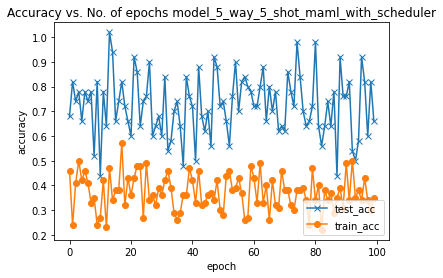

In [29]:
plot_accuracies(history6,'model_5_way_5_shot_maml_with_scheduler')

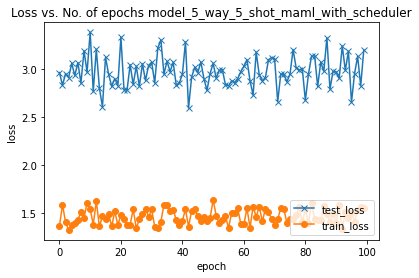

In [30]:
plot_losses(history6,'model_5_way_5_shot_maml_with_scheduler')

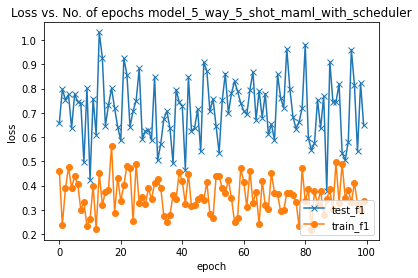

In [31]:
plot_f1(history6,'model_5_way_5_shot_maml_with_scheduler')

In [ ]:
test_F_maml_6 = test_F_maml(model_5_way_5_shot_maml_with_scheduler,10,5,5,5,10)

val_loss : 1.91 val_acc : 0.4300 val_F1: 0.4246
val_loss : 1.85 val_acc : 0.4600 val_F1: 0.4480
val_loss : 1.87 val_acc : 0.4150 val_F1: 0.4166
val_loss : 1.78 val_acc : 0.4950 val_F1: 0.4807
val_loss : 1.93 val_acc : 0.4100 val_F1: 0.3998
val_loss : 1.83 val_acc : 0.5250 val_F1: 0.5196
val_loss : 1.83 val_acc : 0.4950 val_F1: 0.4673
val_loss : 1.90 val_acc : 0.4300 val_F1: 0.4232
val_loss : 1.95 val_acc : 0.3750 val_F1: 0.3624
val_loss : 1.82 val_acc : 0.4350 val_F1: 0.4321


In [ ]:
print("model_5_way_5_shot_maml_with_scheduler test :")
print(f"loss : {test_F_maml_6[0]:.2f}   acc: {test_F_maml_6[1]:.2f}  f1 : {test_F_maml_6[2]:.2f} ")

model_5_way_5_shot_maml_with_scheduler test :
loss : 1.87   acc: 0.45  f1 : 0.44 


In [ ]:
Fomaml = True
scheduler = torch.optim.lr_scheduler.ExponentialLR
# scheduler = None
history7,model_5_way_1_shot_fomaml_with_scheduler = train_F_maml(Epochs,4,5,1,10,save_epoch,Fomaml,scheduler)

  0%|          | 1/20000 [00:00<59:46,  5.58it/s]

train_loss : 1.68 train_acc : 0.2600 train_F1: 0.2266
val_loss : 2.19 val_acc : 0.3600 val_F1: 0.3670
#####################################################################################


  1%|          | 201/20000 [00:15<30:21, 10.87it/s]

train_loss : 1.63 train_acc : 0.3300 train_F1: 0.3064
val_loss : 2.14 val_acc : 0.3667 val_F1: 0.3101
#####################################################################################


  2%|▏         | 401/20000 [00:30<28:23, 11.51it/s]

train_loss : 1.62 train_acc : 0.2700 train_F1: 0.2536
val_loss : 2.12 val_acc : 0.3733 val_F1: 0.3424
#####################################################################################


  3%|▎         | 601/20000 [00:44<30:33, 10.58it/s]

train_loss : 1.61 train_acc : 0.2750 train_F1: 0.2610
val_loss : 1.98 val_acc : 0.4733 val_F1: 0.4275
#####################################################################################


  4%|▍         | 801/20000 [00:59<27:39, 11.57it/s]

train_loss : 1.61 train_acc : 0.3200 train_F1: 0.2865
val_loss : 2.37 val_acc : 0.2267 val_F1: 0.2153
#####################################################################################


  5%|▌         | 1001/20000 [01:14<27:56, 11.33it/s]

train_loss : 1.59 train_acc : 0.2850 train_F1: 0.2718
val_loss : 2.08 val_acc : 0.3733 val_F1: 0.3271
#####################################################################################


  6%|▌         | 1201/20000 [01:29<28:02, 11.18it/s]

train_loss : 1.67 train_acc : 0.2850 train_F1: 0.2715
val_loss : 2.14 val_acc : 0.3800 val_F1: 0.3612
#####################################################################################


  7%|▋         | 1401/20000 [01:44<27:26, 11.29it/s]

train_loss : 1.55 train_acc : 0.3450 train_F1: 0.3218
val_loss : 2.19 val_acc : 0.3400 val_F1: 0.3254
#####################################################################################


  8%|▊         | 1601/20000 [01:58<27:07, 11.30it/s]

train_loss : 1.52 train_acc : 0.2600 train_F1: 0.2380
val_loss : 2.23 val_acc : 0.3000 val_F1: 0.2710
#####################################################################################


  9%|▉         | 1801/20000 [02:13<26:11, 11.58it/s]

train_loss : 1.59 train_acc : 0.2850 train_F1: 0.2710
val_loss : 2.16 val_acc : 0.3733 val_F1: 0.3487
#####################################################################################


 10%|█         | 2001/20000 [02:28<27:01, 11.10it/s]

train_loss : 1.57 train_acc : 0.3200 train_F1: 0.3061
val_loss : 2.18 val_acc : 0.3800 val_F1: 0.3287
#####################################################################################


 11%|█         | 2201/20000 [02:43<25:26, 11.66it/s]

train_loss : 1.57 train_acc : 0.3600 train_F1: 0.3263
val_loss : 2.10 val_acc : 0.4333 val_F1: 0.3786
#####################################################################################


 12%|█▏        | 2401/20000 [02:58<26:49, 10.94it/s]

train_loss : 1.62 train_acc : 0.2400 train_F1: 0.2375
val_loss : 2.13 val_acc : 0.4067 val_F1: 0.3745
#####################################################################################


 13%|█▎        | 2601/20000 [03:12<25:38, 11.31it/s]

train_loss : 1.61 train_acc : 0.2450 train_F1: 0.2250
val_loss : 2.13 val_acc : 0.3133 val_F1: 0.2672
#####################################################################################


 14%|█▍        | 2801/20000 [03:27<25:07, 11.41it/s]

train_loss : 1.57 train_acc : 0.3050 train_F1: 0.2946
val_loss : 2.09 val_acc : 0.4133 val_F1: 0.3602
#####################################################################################


 15%|█▌        | 3001/20000 [03:42<24:24, 11.61it/s]

train_loss : 1.63 train_acc : 0.2400 train_F1: 0.2162
val_loss : 2.27 val_acc : 0.3200 val_F1: 0.2827
#####################################################################################


 16%|█▌        | 3201/20000 [03:57<24:09, 11.59it/s]

train_loss : 1.62 train_acc : 0.2850 train_F1: 0.2610
val_loss : 2.21 val_acc : 0.3733 val_F1: 0.3356
#####################################################################################


 17%|█▋        | 3401/20000 [04:11<25:08, 11.00it/s]

train_loss : 1.59 train_acc : 0.2950 train_F1: 0.2660
val_loss : 2.09 val_acc : 0.4000 val_F1: 0.3741
#####################################################################################


 18%|█▊        | 3601/20000 [04:26<24:24, 11.19it/s]

train_loss : 1.65 train_acc : 0.2750 train_F1: 0.2564
val_loss : 2.21 val_acc : 0.3067 val_F1: 0.2542
#####################################################################################


 19%|█▉        | 3801/20000 [04:41<23:50, 11.32it/s]

train_loss : 1.66 train_acc : 0.2550 train_F1: 0.2339
val_loss : 2.25 val_acc : 0.3267 val_F1: 0.2949
#####################################################################################


 20%|██        | 4001/20000 [04:56<24:07, 11.06it/s]

train_loss : 1.71 train_acc : 0.2050 train_F1: 0.1926
val_loss : 2.17 val_acc : 0.3000 val_F1: 0.2797
#####################################################################################


 21%|██        | 4201/20000 [05:11<23:12, 11.34it/s]

train_loss : 1.62 train_acc : 0.2650 train_F1: 0.2459
val_loss : 2.28 val_acc : 0.3733 val_F1: 0.2955
#####################################################################################


 22%|██▏       | 4401/20000 [05:25<24:30, 10.60it/s]

train_loss : 1.60 train_acc : 0.2550 train_F1: 0.2334
val_loss : 2.16 val_acc : 0.3533 val_F1: 0.3504
#####################################################################################


 23%|██▎       | 4601/20000 [05:40<22:20, 11.49it/s]

train_loss : 1.53 train_acc : 0.3100 train_F1: 0.2965
val_loss : 2.06 val_acc : 0.4067 val_F1: 0.3880
#####################################################################################


 24%|██▍       | 4801/20000 [05:55<21:33, 11.75it/s]

train_loss : 1.60 train_acc : 0.2950 train_F1: 0.2768
val_loss : 2.22 val_acc : 0.3267 val_F1: 0.3049
#####################################################################################


 25%|██▌       | 5001/20000 [06:10<22:37, 11.05it/s]

train_loss : 1.62 train_acc : 0.2700 train_F1: 0.2652
val_loss : 2.16 val_acc : 0.3533 val_F1: 0.3111
#####################################################################################


 26%|██▌       | 5201/20000 [06:25<21:09, 11.65it/s]

train_loss : 1.54 train_acc : 0.3050 train_F1: 0.2882
val_loss : 2.18 val_acc : 0.3800 val_F1: 0.3531
#####################################################################################


 27%|██▋       | 5401/20000 [06:39<21:34, 11.28it/s]

train_loss : 1.60 train_acc : 0.2650 train_F1: 0.2517
val_loss : 2.09 val_acc : 0.3533 val_F1: 0.3209
#####################################################################################


 28%|██▊       | 5601/20000 [06:54<20:52, 11.50it/s]

train_loss : 1.63 train_acc : 0.2900 train_F1: 0.2876
val_loss : 2.19 val_acc : 0.3467 val_F1: 0.2976
#####################################################################################


 29%|██▉       | 5801/20000 [07:09<20:54, 11.32it/s]

train_loss : 1.63 train_acc : 0.2700 train_F1: 0.2448
val_loss : 2.18 val_acc : 0.3733 val_F1: 0.3503
#####################################################################################


 30%|███       | 6001/20000 [07:24<19:52, 11.73it/s]

train_loss : 1.59 train_acc : 0.2750 train_F1: 0.2702
val_loss : 2.28 val_acc : 0.2667 val_F1: 0.2473
#####################################################################################


 31%|███       | 6201/20000 [07:39<20:34, 11.18it/s]

train_loss : 1.66 train_acc : 0.2500 train_F1: 0.2171
val_loss : 2.11 val_acc : 0.4467 val_F1: 0.3955
#####################################################################################


 32%|███▏      | 6401/20000 [07:54<19:49, 11.44it/s]

train_loss : 1.59 train_acc : 0.3000 train_F1: 0.2822
val_loss : 2.23 val_acc : 0.3200 val_F1: 0.2877
#####################################################################################


 33%|███▎      | 6601/20000 [08:09<19:34, 11.41it/s]

train_loss : 1.58 train_acc : 0.2800 train_F1: 0.2557
val_loss : 2.10 val_acc : 0.3200 val_F1: 0.2998
#####################################################################################


 34%|███▍      | 6801/20000 [08:24<21:07, 10.41it/s]

train_loss : 1.59 train_acc : 0.2650 train_F1: 0.2485
val_loss : 2.20 val_acc : 0.2933 val_F1: 0.2760
#####################################################################################


 35%|███▌      | 7001/20000 [08:39<18:51, 11.49it/s]

train_loss : 1.64 train_acc : 0.2450 train_F1: 0.2246
val_loss : 2.19 val_acc : 0.3467 val_F1: 0.3139
#####################################################################################


 36%|███▌      | 7201/20000 [08:54<19:11, 11.11it/s]

train_loss : 1.60 train_acc : 0.3000 train_F1: 0.2825
val_loss : 2.14 val_acc : 0.3733 val_F1: 0.3301
#####################################################################################


 37%|███▋      | 7401/20000 [09:09<17:52, 11.75it/s]

train_loss : 1.60 train_acc : 0.2900 train_F1: 0.2892
val_loss : 2.20 val_acc : 0.3000 val_F1: 0.2679
#####################################################################################


 38%|███▊      | 7601/20000 [09:24<18:34, 11.13it/s]

train_loss : 1.56 train_acc : 0.2900 train_F1: 0.2759
val_loss : 2.17 val_acc : 0.3933 val_F1: 0.3572
#####################################################################################


 39%|███▉      | 7801/20000 [09:39<17:24, 11.68it/s]

train_loss : 1.62 train_acc : 0.2750 train_F1: 0.2591
val_loss : 2.20 val_acc : 0.3000 val_F1: 0.2816
#####################################################################################


 40%|████      | 8001/20000 [09:54<17:28, 11.44it/s]

train_loss : 1.67 train_acc : 0.1850 train_F1: 0.1571
val_loss : 2.25 val_acc : 0.3200 val_F1: 0.2922
#####################################################################################


 41%|████      | 8201/20000 [10:09<17:26, 11.28it/s]

train_loss : 1.59 train_acc : 0.2550 train_F1: 0.2363
val_loss : 2.11 val_acc : 0.3933 val_F1: 0.3849
#####################################################################################


 42%|████▏     | 8401/20000 [10:24<16:50, 11.47it/s]

train_loss : 1.61 train_acc : 0.2800 train_F1: 0.2466
val_loss : 2.13 val_acc : 0.4467 val_F1: 0.4015
#####################################################################################


 43%|████▎     | 8601/20000 [10:39<17:25, 10.90it/s]

train_loss : 1.60 train_acc : 0.2850 train_F1: 0.2772
val_loss : 2.20 val_acc : 0.3533 val_F1: 0.3213
#####################################################################################


 44%|████▍     | 8801/20000 [10:53<16:31, 11.30it/s]

train_loss : 1.60 train_acc : 0.2650 train_F1: 0.2581
val_loss : 2.20 val_acc : 0.3800 val_F1: 0.3564
#####################################################################################


 45%|████▌     | 9001/20000 [11:10<16:16, 11.27it/s]

train_loss : 1.62 train_acc : 0.2200 train_F1: 0.1979
val_loss : 2.18 val_acc : 0.3667 val_F1: 0.3268
#####################################################################################


 46%|████▌     | 9201/20000 [11:26<17:17, 10.41it/s]

train_loss : 1.55 train_acc : 0.3500 train_F1: 0.3288
val_loss : 2.17 val_acc : 0.3200 val_F1: 0.2786
#####################################################################################


 47%|████▋     | 9401/20000 [11:41<15:27, 11.42it/s]

train_loss : 1.60 train_acc : 0.2850 train_F1: 0.2531
val_loss : 2.10 val_acc : 0.3667 val_F1: 0.3387
#####################################################################################


 48%|████▊     | 9601/20000 [11:56<15:21, 11.29it/s]

train_loss : 1.67 train_acc : 0.1900 train_F1: 0.1689
val_loss : 2.17 val_acc : 0.3667 val_F1: 0.3513
#####################################################################################


 49%|████▉     | 9801/20000 [12:11<14:47, 11.50it/s]

train_loss : 1.61 train_acc : 0.2500 train_F1: 0.2337
val_loss : 2.13 val_acc : 0.4067 val_F1: 0.4054
#####################################################################################


 50%|█████     | 10001/20000 [12:26<15:00, 11.10it/s]

train_loss : 1.60 train_acc : 0.2700 train_F1: 0.2475
val_loss : 2.10 val_acc : 0.4267 val_F1: 0.3877
#####################################################################################


 51%|█████     | 10201/20000 [12:42<14:32, 11.23it/s]

train_loss : 1.59 train_acc : 0.2550 train_F1: 0.2463
val_loss : 2.25 val_acc : 0.3067 val_F1: 0.2785
#####################################################################################


 52%|█████▏    | 10401/20000 [12:58<15:15, 10.49it/s]

train_loss : 1.55 train_acc : 0.3400 train_F1: 0.3208
val_loss : 2.18 val_acc : 0.3933 val_F1: 0.3508
#####################################################################################


 53%|█████▎    | 10601/20000 [13:13<14:16, 10.97it/s]

train_loss : 1.53 train_acc : 0.3100 train_F1: 0.2998
val_loss : 2.16 val_acc : 0.3533 val_F1: 0.3074
#####################################################################################


 54%|█████▍    | 10801/20000 [13:29<13:46, 11.13it/s]

train_loss : 1.56 train_acc : 0.3150 train_F1: 0.2809
val_loss : 2.18 val_acc : 0.3600 val_F1: 0.3312
#####################################################################################


 55%|█████▌    | 11001/20000 [13:44<13:24, 11.19it/s]

train_loss : 1.61 train_acc : 0.2350 train_F1: 0.2261
val_loss : 2.19 val_acc : 0.3600 val_F1: 0.3424
#####################################################################################


 56%|█████▌    | 11201/20000 [13:59<12:59, 11.29it/s]

train_loss : 1.62 train_acc : 0.2750 train_F1: 0.2532
val_loss : 2.10 val_acc : 0.4067 val_F1: 0.3648
#####################################################################################


 57%|█████▋    | 11401/20000 [14:14<12:57, 11.07it/s]

train_loss : 1.64 train_acc : 0.2550 train_F1: 0.2440
val_loss : 2.03 val_acc : 0.4533 val_F1: 0.4143
#####################################################################################


 58%|█████▊    | 11601/20000 [14:30<12:18, 11.38it/s]

train_loss : 1.60 train_acc : 0.3100 train_F1: 0.2733
val_loss : 2.23 val_acc : 0.3067 val_F1: 0.2719
#####################################################################################


 59%|█████▉    | 11801/20000 [14:45<12:16, 11.14it/s]

train_loss : 1.51 train_acc : 0.3250 train_F1: 0.3135
val_loss : 2.17 val_acc : 0.3600 val_F1: 0.3356
#####################################################################################


 60%|██████    | 12001/20000 [15:00<11:58, 11.14it/s]

train_loss : 1.61 train_acc : 0.2800 train_F1: 0.2508
val_loss : 2.17 val_acc : 0.4000 val_F1: 0.3851
#####################################################################################


 61%|██████    | 12201/20000 [15:16<11:29, 11.30it/s]

train_loss : 1.63 train_acc : 0.2750 train_F1: 0.2644
val_loss : 2.14 val_acc : 0.3933 val_F1: 0.3524
#####################################################################################


 62%|██████▏   | 12401/20000 [15:31<11:11, 11.31it/s]

train_loss : 1.58 train_acc : 0.2950 train_F1: 0.2744
val_loss : 2.18 val_acc : 0.3400 val_F1: 0.3181
#####################################################################################


 63%|██████▎   | 12601/20000 [15:46<10:33, 11.67it/s]

train_loss : 1.55 train_acc : 0.3650 train_F1: 0.3629
val_loss : 2.12 val_acc : 0.3600 val_F1: 0.3362
#####################################################################################


 64%|██████▍   | 12801/20000 [16:01<10:34, 11.35it/s]

train_loss : 1.59 train_acc : 0.3150 train_F1: 0.2874
val_loss : 2.08 val_acc : 0.3667 val_F1: 0.3386
#####################################################################################


 65%|██████▌   | 13001/20000 [16:15<10:27, 11.16it/s]

train_loss : 1.56 train_acc : 0.3200 train_F1: 0.2980
val_loss : 2.23 val_acc : 0.3533 val_F1: 0.3181
#####################################################################################


 66%|██████▌   | 13201/20000 [16:30<10:07, 11.20it/s]

train_loss : 1.56 train_acc : 0.3300 train_F1: 0.3133
val_loss : 2.12 val_acc : 0.4267 val_F1: 0.3732
#####################################################################################


 67%|██████▋   | 13401/20000 [16:45<09:29, 11.59it/s]

train_loss : 1.57 train_acc : 0.2750 train_F1: 0.2478
val_loss : 2.11 val_acc : 0.3400 val_F1: 0.3169
#####################################################################################


 68%|██████▊   | 13601/20000 [17:00<09:12, 11.59it/s]

train_loss : 1.57 train_acc : 0.2700 train_F1: 0.2609
val_loss : 2.28 val_acc : 0.3200 val_F1: 0.3045
#####################################################################################


 69%|██████▉   | 13801/20000 [17:15<08:56, 11.56it/s]

train_loss : 1.59 train_acc : 0.3250 train_F1: 0.2935
val_loss : 2.21 val_acc : 0.3067 val_F1: 0.2736
#####################################################################################


 70%|███████   | 14001/20000 [17:30<08:51, 11.29it/s]

train_loss : 1.60 train_acc : 0.2900 train_F1: 0.2771
val_loss : 2.28 val_acc : 0.3467 val_F1: 0.2968
#####################################################################################


 71%|███████   | 14201/20000 [17:45<08:14, 11.73it/s]

train_loss : 1.65 train_acc : 0.2850 train_F1: 0.2750
val_loss : 2.18 val_acc : 0.3667 val_F1: 0.3517
#####################################################################################


 72%|███████▏  | 14401/20000 [18:00<08:05, 11.53it/s]

train_loss : 1.63 train_acc : 0.2550 train_F1: 0.2366
val_loss : 2.18 val_acc : 0.3600 val_F1: 0.3283
#####################################################################################


 73%|███████▎  | 14601/20000 [18:15<08:23, 10.72it/s]

train_loss : 1.65 train_acc : 0.2200 train_F1: 0.1998
val_loss : 2.16 val_acc : 0.4000 val_F1: 0.3703
#####################################################################################


 74%|███████▍  | 14801/20000 [18:31<09:41,  8.95it/s]

train_loss : 1.65 train_acc : 0.2400 train_F1: 0.2297
val_loss : 2.23 val_acc : 0.3267 val_F1: 0.2948
#####################################################################################


 75%|███████▌  | 15001/20000 [18:47<07:26, 11.19it/s]

train_loss : 1.50 train_acc : 0.3400 train_F1: 0.3241
val_loss : 2.28 val_acc : 0.2933 val_F1: 0.2527
#####################################################################################


 76%|███████▌  | 15201/20000 [19:02<07:07, 11.24it/s]

train_loss : 1.59 train_acc : 0.2750 train_F1: 0.2611
val_loss : 2.16 val_acc : 0.3400 val_F1: 0.2948
#####################################################################################


 77%|███████▋  | 15401/20000 [19:18<07:06, 10.79it/s]

train_loss : 1.62 train_acc : 0.2650 train_F1: 0.2389
val_loss : 2.12 val_acc : 0.3600 val_F1: 0.3244
#####################################################################################


 78%|███████▊  | 15601/20000 [19:33<07:22,  9.93it/s]

train_loss : 1.61 train_acc : 0.3000 train_F1: 0.2708
val_loss : 2.22 val_acc : 0.3667 val_F1: 0.3519
#####################################################################################


 79%|███████▉  | 15801/20000 [19:49<06:26, 10.85it/s]

train_loss : 1.63 train_acc : 0.2500 train_F1: 0.2382
val_loss : 2.14 val_acc : 0.4400 val_F1: 0.4036
#####################################################################################


 80%|████████  | 16001/20000 [20:05<05:57, 11.18it/s]

train_loss : 1.61 train_acc : 0.3100 train_F1: 0.2932
val_loss : 2.13 val_acc : 0.3600 val_F1: 0.3336
#####################################################################################


 81%|████████  | 16201/20000 [20:20<06:15, 10.11it/s]

train_loss : 1.59 train_acc : 0.3200 train_F1: 0.3087
val_loss : 2.14 val_acc : 0.3533 val_F1: 0.3332
#####################################################################################


 82%|████████▏ | 16401/20000 [20:37<05:48, 10.34it/s]

train_loss : 1.53 train_acc : 0.3600 train_F1: 0.3559
val_loss : 2.13 val_acc : 0.3867 val_F1: 0.3610
#####################################################################################


 83%|████████▎ | 16601/20000 [20:53<05:31, 10.24it/s]

train_loss : 1.58 train_acc : 0.2800 train_F1: 0.2660
val_loss : 2.14 val_acc : 0.4133 val_F1: 0.3380
#####################################################################################


 84%|████████▍ | 16801/20000 [21:09<05:01, 10.61it/s]

train_loss : 1.60 train_acc : 0.2550 train_F1: 0.2496
val_loss : 2.24 val_acc : 0.2800 val_F1: 0.2558
#####################################################################################


 85%|████████▌ | 17001/20000 [21:24<04:57, 10.07it/s]

train_loss : 1.60 train_acc : 0.2450 train_F1: 0.2213
val_loss : 2.22 val_acc : 0.3600 val_F1: 0.3403
#####################################################################################


 86%|████████▌ | 17201/20000 [21:40<04:20, 10.74it/s]

train_loss : 1.67 train_acc : 0.2550 train_F1: 0.2459
val_loss : 2.10 val_acc : 0.4467 val_F1: 0.4000
#####################################################################################


 87%|████████▋ | 17401/20000 [21:56<04:00, 10.81it/s]

train_loss : 1.52 train_acc : 0.3200 train_F1: 0.2973
val_loss : 2.22 val_acc : 0.2933 val_F1: 0.2824
#####################################################################################


 88%|████████▊ | 17601/20000 [22:11<03:57, 10.12it/s]

train_loss : 1.52 train_acc : 0.3750 train_F1: 0.3498
val_loss : 2.08 val_acc : 0.3933 val_F1: 0.3570
#####################################################################################


 89%|████████▉ | 17801/20000 [22:27<03:13, 11.39it/s]

train_loss : 1.57 train_acc : 0.2750 train_F1: 0.2631
val_loss : 2.07 val_acc : 0.4400 val_F1: 0.4099
#####################################################################################


 90%|█████████ | 18001/20000 [22:42<02:53, 11.52it/s]

train_loss : 1.63 train_acc : 0.2700 train_F1: 0.2520
val_loss : 2.17 val_acc : 0.3667 val_F1: 0.3345
#####################################################################################


 91%|█████████ | 18201/20000 [22:57<02:37, 11.43it/s]

train_loss : 1.65 train_acc : 0.2250 train_F1: 0.2056
val_loss : 2.10 val_acc : 0.4067 val_F1: 0.3601
#####################################################################################


 92%|█████████▏| 18401/20000 [23:11<02:19, 11.47it/s]

train_loss : 1.66 train_acc : 0.2550 train_F1: 0.2454
val_loss : 2.19 val_acc : 0.3467 val_F1: 0.3403
#####################################################################################


 93%|█████████▎| 18601/20000 [23:26<02:04, 11.19it/s]

train_loss : 1.51 train_acc : 0.3200 train_F1: 0.3101
val_loss : 2.07 val_acc : 0.4400 val_F1: 0.4095
#####################################################################################


 94%|█████████▍| 18801/20000 [23:41<01:42, 11.68it/s]

train_loss : 1.62 train_acc : 0.2900 train_F1: 0.2690
val_loss : 2.27 val_acc : 0.3133 val_F1: 0.2739
#####################################################################################


 95%|█████████▌| 19001/20000 [23:56<01:27, 11.46it/s]

train_loss : 1.51 train_acc : 0.3550 train_F1: 0.3132
val_loss : 2.15 val_acc : 0.3533 val_F1: 0.3103
#####################################################################################


 96%|█████████▌| 19201/20000 [24:11<01:09, 11.47it/s]

train_loss : 1.68 train_acc : 0.2500 train_F1: 0.2274
val_loss : 2.07 val_acc : 0.4467 val_F1: 0.4113
#####################################################################################


 97%|█████████▋| 19401/20000 [24:26<00:52, 11.50it/s]

train_loss : 1.60 train_acc : 0.3100 train_F1: 0.2802
val_loss : 2.16 val_acc : 0.3933 val_F1: 0.3748
#####################################################################################


 98%|█████████▊| 19601/20000 [24:40<00:35, 11.39it/s]

train_loss : 1.54 train_acc : 0.3500 train_F1: 0.3282
val_loss : 2.18 val_acc : 0.3600 val_F1: 0.3301
#####################################################################################


 99%|█████████▉| 19801/20000 [24:55<00:17, 11.10it/s]

train_loss : 1.59 train_acc : 0.2950 train_F1: 0.2701
val_loss : 2.17 val_acc : 0.3600 val_F1: 0.3230
#####################################################################################


100%|██████████| 20000/20000 [25:10<00:00, 13.24it/s]


In [ ]:
joblib.dump(model_5_way_1_shot_fomaml_with_scheduler, 'model_5_way_1_shot_fomaml_with_scheduler')
joblib.dump(history7,'history7')

['history7']

In [33]:
history7 = joblib.load('history7')

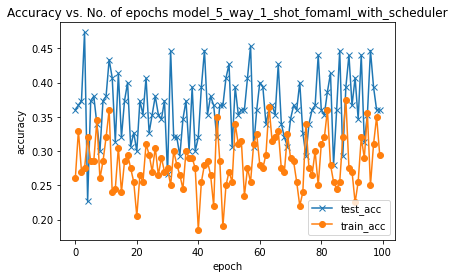

In [34]:
plot_accuracies(history7,'model_5_way_1_shot_fomaml_with_scheduler')

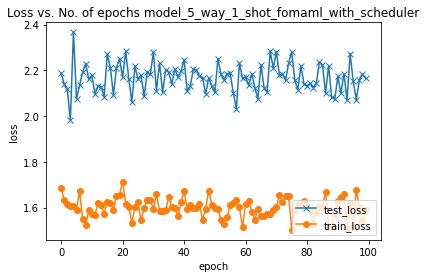

In [35]:
plot_losses(history7,'model_5_way_1_shot_fomaml_with_scheduler')

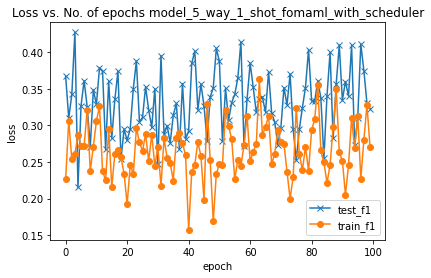

In [36]:
plot_f1(history7,'model_5_way_1_shot_fomaml_with_scheduler')

In [ ]:
test_F_maml_7 = test_F_maml(model_5_way_1_shot_fomaml_with_scheduler,10,5,5,1,10)

val_loss : 2.11 val_acc : 0.2950 val_F1: 0.2829
val_loss : 2.00 val_acc : 0.3750 val_F1: 0.3524
val_loss : 2.02 val_acc : 0.3700 val_F1: 0.3396
val_loss : 2.10 val_acc : 0.2800 val_F1: 0.2507
val_loss : 2.01 val_acc : 0.3250 val_F1: 0.2991
val_loss : 2.06 val_acc : 0.3100 val_F1: 0.2818
val_loss : 2.02 val_acc : 0.2850 val_F1: 0.2729
val_loss : 1.98 val_acc : 0.4050 val_F1: 0.3773
val_loss : 2.07 val_acc : 0.3650 val_F1: 0.3401
val_loss : 2.03 val_acc : 0.3600 val_F1: 0.3315


In [ ]:
print("model_5_way_1_shot_fomaml_with_scheduler test :")
print(f"loss : {test_F_maml_7[0]:.2f}   acc: {test_F_maml_7[1]:.2f}  f1 : {test_F_maml_7[2]:.2f} ")

model_5_way_1_shot_fomaml_with_scheduler test :
loss : 2.04   acc: 0.34  f1 : 0.31 


In [ ]:
Fomaml = True
scheduler = torch.optim.lr_scheduler.ExponentialLR
# scheduler = None
history8,model_5_way_5_shot_fomaml_with_scheduler = train_F_maml(Epochs,2,5,5,10,save_epoch,Fomaml,scheduler)

  0%|          | 0/20000 [00:00<?, ?it/s]

train_loss : 1.46 train_acc : 0.4200 train_F1: 0.3899


  0%|          | 1/20000 [00:00<34:51,  9.56it/s]

val_loss : 2.95 val_acc : 0.6800 val_F1: 0.6650
#####################################################################################


  1%|          | 202/20000 [00:09<16:52, 19.54it/s]

train_loss : 1.53 train_acc : 0.2600 train_F1: 0.2590
val_loss : 2.97 val_acc : 0.7400 val_F1: 0.7320
#####################################################################################


  2%|▏         | 402/20000 [00:18<17:43, 18.44it/s]

train_loss : 1.45 train_acc : 0.4100 train_F1: 0.4063
val_loss : 2.66 val_acc : 0.8800 val_F1: 0.8938
#####################################################################################


  3%|▎         | 602/20000 [00:28<16:48, 19.24it/s]

train_loss : 1.39 train_acc : 0.4000 train_F1: 0.3972
val_loss : 3.03 val_acc : 0.6600 val_F1: 0.6539
#####################################################################################


  4%|▍         | 803/20000 [00:37<17:02, 18.77it/s]

train_loss : 1.57 train_acc : 0.3300 train_F1: 0.3101
val_loss : 3.30 val_acc : 0.5200 val_F1: 0.5074
#####################################################################################


  5%|▌         | 1001/20000 [00:47<17:07, 18.49it/s]

train_loss : 1.48 train_acc : 0.3300 train_F1: 0.3216
val_loss : 3.20 val_acc : 0.6400 val_F1: 0.6309
#####################################################################################


  6%|▌         | 1202/20000 [00:56<16:32, 18.94it/s]

train_loss : 1.49 train_acc : 0.4200 train_F1: 0.3913
val_loss : 2.82 val_acc : 0.8000 val_F1: 0.7862
#####################################################################################


  7%|▋         | 1403/20000 [01:05<16:06, 19.24it/s]

train_loss : 1.51 train_acc : 0.2900 train_F1: 0.2760
val_loss : 2.80 val_acc : 0.7000 val_F1: 0.6980
#####################################################################################


  8%|▊         | 1601/20000 [01:15<17:08, 17.89it/s]

train_loss : 1.58 train_acc : 0.2900 train_F1: 0.2917
val_loss : 2.95 val_acc : 0.6800 val_F1: 0.6646
#####################################################################################


  9%|▉         | 1802/20000 [01:24<15:55, 19.05it/s]

train_loss : 1.58 train_acc : 0.3400 train_F1: 0.3385
val_loss : 2.78 val_acc : 0.8400 val_F1: 0.8086
#####################################################################################


 10%|█         | 2003/20000 [01:34<15:40, 19.13it/s]

train_loss : 1.50 train_acc : 0.3900 train_F1: 0.3862
val_loss : 3.12 val_acc : 0.5800 val_F1: 0.5568
#####################################################################################


 11%|█         | 2204/20000 [01:43<14:53, 19.92it/s]

train_loss : 1.45 train_acc : 0.3900 train_F1: 0.3810
val_loss : 2.97 val_acc : 0.7200 val_F1: 0.7003
#####################################################################################


 12%|█▏        | 2402/20000 [01:52<15:12, 19.30it/s]

train_loss : 1.55 train_acc : 0.3300 train_F1: 0.3184
val_loss : 3.12 val_acc : 0.5200 val_F1: 0.4938
#####################################################################################


 13%|█▎        | 2603/20000 [02:02<15:20, 18.90it/s]

train_loss : 1.60 train_acc : 0.2500 train_F1: 0.2455
val_loss : 2.81 val_acc : 0.8600 val_F1: 0.8518
#####################################################################################


 14%|█▍        | 2801/20000 [02:11<15:07, 18.95it/s]

train_loss : 1.54 train_acc : 0.3100 train_F1: 0.2940
val_loss : 2.94 val_acc : 0.7600 val_F1: 0.7265
#####################################################################################


 15%|█▌        | 3002/20000 [02:20<14:29, 19.56it/s]

train_loss : 1.38 train_acc : 0.4000 train_F1: 0.3926
val_loss : 2.98 val_acc : 0.6600 val_F1: 0.6579
#####################################################################################


 16%|█▌        | 3203/20000 [02:30<14:57, 18.72it/s]

train_loss : 1.54 train_acc : 0.3700 train_F1: 0.3531
val_loss : 3.13 val_acc : 0.5600 val_F1: 0.5567
#####################################################################################


 17%|█▋        | 3404/20000 [02:39<13:45, 20.11it/s]

train_loss : 1.44 train_acc : 0.3700 train_F1: 0.3728
val_loss : 2.82 val_acc : 0.6800 val_F1: 0.6781
#####################################################################################


 18%|█▊        | 3602/20000 [02:49<15:03, 18.15it/s]

train_loss : 1.52 train_acc : 0.3000 train_F1: 0.2954
val_loss : 3.19 val_acc : 0.5200 val_F1: 0.5087
#####################################################################################


 19%|█▉        | 3803/20000 [02:58<14:19, 18.84it/s]

train_loss : 1.43 train_acc : 0.3400 train_F1: 0.3308
val_loss : 3.18 val_acc : 0.7000 val_F1: 0.6747
#####################################################################################


 20%|██        | 4001/20000 [03:07<14:03, 18.97it/s]

train_loss : 1.59 train_acc : 0.2400 train_F1: 0.2319
val_loss : 3.20 val_acc : 0.6400 val_F1: 0.6434
#####################################################################################


 21%|██        | 4202/20000 [03:17<13:59, 18.81it/s]

train_loss : 1.63 train_acc : 0.2600 train_F1: 0.2639
val_loss : 2.83 val_acc : 0.8600 val_F1: 0.8432
#####################################################################################


 22%|██▏       | 4403/20000 [03:26<14:06, 18.44it/s]

train_loss : 1.44 train_acc : 0.4200 train_F1: 0.4023
val_loss : 2.94 val_acc : 0.7800 val_F1: 0.7797
#####################################################################################


 23%|██▎       | 4603/20000 [03:36<14:30, 17.69it/s]

train_loss : 1.53 train_acc : 0.3600 train_F1: 0.3475
val_loss : 2.72 val_acc : 0.8800 val_F1: 0.8453
#####################################################################################


 24%|██▍       | 4804/20000 [03:46<12:45, 19.86it/s]

train_loss : 1.54 train_acc : 0.3400 train_F1: 0.3077
val_loss : 2.68 val_acc : 0.8200 val_F1: 0.8145
#####################################################################################


 25%|██▌       | 5003/20000 [03:56<15:03, 16.60it/s]

train_loss : 1.43 train_acc : 0.3500 train_F1: 0.3383
val_loss : 2.97 val_acc : 0.6600 val_F1: 0.6586
#####################################################################################


 26%|██▌       | 5202/20000 [04:07<14:43, 16.75it/s]

train_loss : 1.48 train_acc : 0.3400 train_F1: 0.3274
val_loss : 2.93 val_acc : 0.6000 val_F1: 0.5923
#####################################################################################


 27%|██▋       | 5403/20000 [04:17<13:13, 18.41it/s]

train_loss : 1.57 train_acc : 0.3300 train_F1: 0.3191
val_loss : 2.95 val_acc : 0.8200 val_F1: 0.8131
#####################################################################################


 28%|██▊       | 5601/20000 [04:27<14:01, 17.11it/s]

train_loss : 1.54 train_acc : 0.3500 train_F1: 0.3406
val_loss : 2.84 val_acc : 0.7400 val_F1: 0.7304
#####################################################################################


 29%|██▉       | 5802/20000 [04:36<12:54, 18.34it/s]

train_loss : 1.36 train_acc : 0.3900 train_F1: 0.3840
val_loss : 2.88 val_acc : 0.7400 val_F1: 0.7241
#####################################################################################


 30%|███       | 6002/20000 [04:46<12:39, 18.42it/s]

train_loss : 1.41 train_acc : 0.3900 train_F1: 0.3785
val_loss : 3.14 val_acc : 0.4400 val_F1: 0.4296
#####################################################################################


 31%|███       | 6201/20000 [04:56<12:16, 18.75it/s]

train_loss : 1.34 train_acc : 0.5300 train_F1: 0.5043
val_loss : 2.97 val_acc : 0.7200 val_F1: 0.7102
#####################################################################################


 32%|███▏      | 6403/20000 [05:06<12:34, 18.01it/s]

train_loss : 1.50 train_acc : 0.3700 train_F1: 0.3506
val_loss : 3.08 val_acc : 0.5400 val_F1: 0.5046
#####################################################################################


 33%|███▎      | 6602/20000 [05:16<11:41, 19.11it/s]

train_loss : 1.46 train_acc : 0.4300 train_F1: 0.4264
val_loss : 2.84 val_acc : 0.8800 val_F1: 0.8082
#####################################################################################


 34%|███▍      | 6803/20000 [05:25<11:45, 18.70it/s]

train_loss : 1.50 train_acc : 0.3700 train_F1: 0.3628
val_loss : 3.00 val_acc : 0.6000 val_F1: 0.5267
#####################################################################################


 35%|███▌      | 7003/20000 [05:35<11:25, 18.97it/s]

train_loss : 1.40 train_acc : 0.4200 train_F1: 0.4199
val_loss : 3.02 val_acc : 0.6000 val_F1: 0.5948
#####################################################################################


 36%|███▌      | 7201/20000 [05:45<11:23, 18.73it/s]

train_loss : 1.52 train_acc : 0.3700 train_F1: 0.3749
val_loss : 2.85 val_acc : 0.8000 val_F1: 0.8154
#####################################################################################


 37%|███▋      | 7403/20000 [05:55<11:09, 18.81it/s]

train_loss : 1.45 train_acc : 0.4000 train_F1: 0.3992
val_loss : 2.94 val_acc : 0.7800 val_F1: 0.7651
#####################################################################################


 38%|███▊      | 7601/20000 [06:04<11:16, 18.32it/s]

train_loss : 1.40 train_acc : 0.4300 train_F1: 0.4164
val_loss : 2.95 val_acc : 0.7600 val_F1: 0.7701
#####################################################################################


 39%|███▉      | 7802/20000 [06:14<10:47, 18.83it/s]

train_loss : 1.44 train_acc : 0.4000 train_F1: 0.4010
val_loss : 2.96 val_acc : 0.8200 val_F1: 0.8192
#####################################################################################


 40%|████      | 8003/20000 [06:23<10:25, 19.19it/s]

train_loss : 1.51 train_acc : 0.3300 train_F1: 0.3301
val_loss : 3.14 val_acc : 0.6200 val_F1: 0.6014
#####################################################################################


 41%|████      | 8204/20000 [06:33<10:02, 19.58it/s]

train_loss : 1.46 train_acc : 0.3700 train_F1: 0.3477
val_loss : 2.93 val_acc : 0.7800 val_F1: 0.7653
#####################################################################################


 42%|████▏     | 8402/20000 [06:43<10:13, 18.90it/s]

train_loss : 1.39 train_acc : 0.4400 train_F1: 0.4422
val_loss : 3.23 val_acc : 0.6000 val_F1: 0.5959
#####################################################################################


 43%|████▎     | 8602/20000 [06:52<10:06, 18.78it/s]

train_loss : 1.49 train_acc : 0.3500 train_F1: 0.3477
val_loss : 2.93 val_acc : 0.7000 val_F1: 0.6486
#####################################################################################


 44%|████▍     | 8802/20000 [07:02<10:22, 17.99it/s]

train_loss : 1.51 train_acc : 0.3500 train_F1: 0.3496
val_loss : 3.11 val_acc : 0.6800 val_F1: 0.6630
#####################################################################################


 45%|████▌     | 9001/20000 [07:12<11:04, 16.55it/s]

train_loss : 1.48 train_acc : 0.4300 train_F1: 0.4190
val_loss : 2.93 val_acc : 0.7800 val_F1: 0.7660
#####################################################################################


 46%|████▌     | 9201/20000 [07:22<09:40, 18.61it/s]

train_loss : 1.54 train_acc : 0.3000 train_F1: 0.2915
val_loss : 2.90 val_acc : 0.7800 val_F1: 0.7580
#####################################################################################


 47%|████▋     | 9403/20000 [07:31<09:48, 18.00it/s]

train_loss : 1.48 train_acc : 0.3600 train_F1: 0.3686
val_loss : 2.83 val_acc : 0.8400 val_F1: 0.8298
#####################################################################################


 48%|████▊     | 9602/20000 [07:41<09:30, 18.24it/s]

train_loss : 1.56 train_acc : 0.3300 train_F1: 0.3311
val_loss : 2.96 val_acc : 0.6400 val_F1: 0.6545
#####################################################################################


 49%|████▉     | 9803/20000 [07:51<09:17, 18.28it/s]

train_loss : 1.54 train_acc : 0.2900 train_F1: 0.2797
val_loss : 3.24 val_acc : 0.6200 val_F1: 0.5897
#####################################################################################


 50%|█████     | 10003/20000 [08:01<09:12, 18.10it/s]

train_loss : 1.34 train_acc : 0.4400 train_F1: 0.4324
val_loss : 2.71 val_acc : 0.8600 val_F1: 0.8424
#####################################################################################


 51%|█████     | 10203/20000 [08:10<09:14, 17.66it/s]

train_loss : 1.40 train_acc : 0.4400 train_F1: 0.4326
val_loss : 3.02 val_acc : 0.7800 val_F1: 0.7566
#####################################################################################


 52%|█████▏    | 10402/20000 [08:21<08:39, 18.49it/s]

train_loss : 1.50 train_acc : 0.3800 train_F1: 0.3688
val_loss : 3.08 val_acc : 0.7000 val_F1: 0.6972
#####################################################################################


 53%|█████▎    | 10604/20000 [08:30<07:51, 19.93it/s]

train_loss : 1.29 train_acc : 0.4800 train_F1: 0.4626
val_loss : 2.98 val_acc : 0.7800 val_F1: 0.7688
#####################################################################################


 54%|█████▍    | 10802/20000 [08:39<08:09, 18.78it/s]

train_loss : 1.47 train_acc : 0.3700 train_F1: 0.3518
val_loss : 2.74 val_acc : 0.9200 val_F1: 0.9203
#####################################################################################


 55%|█████▌    | 11003/20000 [08:49<07:45, 19.34it/s]

train_loss : 1.51 train_acc : 0.2600 train_F1: 0.2511
val_loss : 2.75 val_acc : 0.8000 val_F1: 0.7821
#####################################################################################


 56%|█████▌    | 11204/20000 [08:58<07:30, 19.52it/s]

train_loss : 1.52 train_acc : 0.4000 train_F1: 0.3932
val_loss : 3.10 val_acc : 0.6400 val_F1: 0.6491
#####################################################################################


 57%|█████▋    | 11404/20000 [09:08<07:07, 20.09it/s]

train_loss : 1.50 train_acc : 0.3200 train_F1: 0.3150
val_loss : 2.78 val_acc : 0.8800 val_F1: 0.8821
#####################################################################################


 58%|█████▊    | 11602/20000 [09:17<07:21, 19.00it/s]

train_loss : 1.54 train_acc : 0.2900 train_F1: 0.2929
val_loss : 2.94 val_acc : 0.7000 val_F1: 0.6751
#####################################################################################


 59%|█████▉    | 11803/20000 [09:26<07:06, 19.22it/s]

train_loss : 1.45 train_acc : 0.3600 train_F1: 0.3440
val_loss : 2.83 val_acc : 0.9400 val_F1: 0.9296
#####################################################################################


 60%|██████    | 12004/20000 [09:36<06:47, 19.62it/s]

train_loss : 1.46 train_acc : 0.3200 train_F1: 0.3110
val_loss : 2.81 val_acc : 0.8800 val_F1: 0.8405
#####################################################################################


 61%|██████    | 12202/20000 [09:45<06:39, 19.51it/s]

train_loss : 1.46 train_acc : 0.4000 train_F1: 0.3856
val_loss : 3.26 val_acc : 0.5600 val_F1: 0.5302
#####################################################################################


 62%|██████▏   | 12403/20000 [09:54<06:42, 18.88it/s]

train_loss : 1.43 train_acc : 0.4400 train_F1: 0.4403
val_loss : 3.06 val_acc : 0.6800 val_F1: 0.6896
#####################################################################################


 63%|██████▎   | 12601/20000 [10:04<06:23, 19.29it/s]

train_loss : 1.49 train_acc : 0.3600 train_F1: 0.3566
val_loss : 3.09 val_acc : 0.6200 val_F1: 0.5945
#####################################################################################


 64%|██████▍   | 12802/20000 [10:13<06:18, 19.04it/s]

train_loss : 1.37 train_acc : 0.4000 train_F1: 0.4123
val_loss : 3.04 val_acc : 0.6400 val_F1: 0.5815
#####################################################################################


 65%|██████▌   | 13003/20000 [10:22<06:06, 19.08it/s]

train_loss : 1.48 train_acc : 0.3600 train_F1: 0.3512
val_loss : 3.08 val_acc : 0.6400 val_F1: 0.6311
#####################################################################################


 66%|██████▌   | 13204/20000 [10:32<05:41, 19.89it/s]

train_loss : 1.41 train_acc : 0.4400 train_F1: 0.4352
val_loss : 3.01 val_acc : 0.7400 val_F1: 0.7112
#####################################################################################


 67%|██████▋   | 13402/20000 [10:41<05:45, 19.11it/s]

train_loss : 1.46 train_acc : 0.3800 train_F1: 0.3799
val_loss : 3.01 val_acc : 0.6800 val_F1: 0.6631
#####################################################################################


 68%|██████▊   | 13603/20000 [10:50<05:46, 18.45it/s]

train_loss : 1.48 train_acc : 0.2800 train_F1: 0.2780
val_loss : 3.07 val_acc : 0.7200 val_F1: 0.6775
#####################################################################################


 69%|██████▉   | 13804/20000 [11:00<05:06, 20.24it/s]

train_loss : 1.46 train_acc : 0.3300 train_F1: 0.3246
val_loss : 2.98 val_acc : 0.7000 val_F1: 0.7084
#####################################################################################


 70%|███████   | 14002/20000 [11:09<05:14, 19.07it/s]

train_loss : 1.49 train_acc : 0.3500 train_F1: 0.3428
val_loss : 2.97 val_acc : 0.6800 val_F1: 0.6409
#####################################################################################


 71%|███████   | 14203/20000 [11:19<05:02, 19.16it/s]

train_loss : 1.42 train_acc : 0.5000 train_F1: 0.4953
val_loss : 2.84 val_acc : 0.8000 val_F1: 0.8010
#####################################################################################


 72%|███████▏  | 14404/20000 [11:28<04:44, 19.64it/s]

train_loss : 1.59 train_acc : 0.3000 train_F1: 0.2828
val_loss : 2.95 val_acc : 0.6200 val_F1: 0.6072
#####################################################################################


 73%|███████▎  | 14602/20000 [11:37<04:38, 19.37it/s]

train_loss : 1.42 train_acc : 0.3800 train_F1: 0.3776
val_loss : 2.98 val_acc : 0.6200 val_F1: 0.5999
#####################################################################################


 74%|███████▍  | 14802/20000 [11:47<04:42, 18.38it/s]

train_loss : 1.47 train_acc : 0.2600 train_F1: 0.2516
val_loss : 2.78 val_acc : 0.9400 val_F1: 0.9363
#####################################################################################


 75%|███████▌  | 15002/20000 [11:56<04:28, 18.63it/s]

train_loss : 1.36 train_acc : 0.4700 train_F1: 0.4385
val_loss : 3.14 val_acc : 0.5200 val_F1: 0.5241
#####################################################################################


 76%|███████▌  | 15203/20000 [12:06<04:27, 17.91it/s]

train_loss : 1.64 train_acc : 0.2200 train_F1: 0.2249
val_loss : 2.84 val_acc : 0.7400 val_F1: 0.7220
#####################################################################################


 77%|███████▋  | 15401/20000 [12:16<04:24, 17.39it/s]

train_loss : 1.44 train_acc : 0.3800 train_F1: 0.3662
val_loss : 2.88 val_acc : 0.7600 val_F1: 0.7450
#####################################################################################


 78%|███████▊  | 15602/20000 [12:25<04:18, 17.02it/s]

train_loss : 1.51 train_acc : 0.3200 train_F1: 0.3154
val_loss : 2.74 val_acc : 0.8400 val_F1: 0.8377
#####################################################################################


 79%|███████▉  | 15802/20000 [12:35<04:03, 17.23it/s]

train_loss : 1.55 train_acc : 0.2800 train_F1: 0.2767
val_loss : 3.02 val_acc : 0.7200 val_F1: 0.7120
#####################################################################################


 80%|████████  | 16001/20000 [12:45<03:41, 18.06it/s]

train_loss : 1.42 train_acc : 0.3700 train_F1: 0.3606
val_loss : 3.00 val_acc : 0.6600 val_F1: 0.6698
#####################################################################################


 81%|████████  | 16202/20000 [12:55<03:30, 18.07it/s]

train_loss : 1.58 train_acc : 0.3200 train_F1: 0.3184
val_loss : 3.10 val_acc : 0.6000 val_F1: 0.5733
#####################################################################################


 82%|████████▏ | 16402/20000 [13:05<03:53, 15.41it/s]

train_loss : 1.34 train_acc : 0.4700 train_F1: 0.4573
val_loss : 3.16 val_acc : 0.6600 val_F1: 0.6806
#####################################################################################


 83%|████████▎ | 16601/20000 [13:15<03:39, 15.52it/s]

train_loss : 1.35 train_acc : 0.4100 train_F1: 0.3859
val_loss : 2.82 val_acc : 0.8200 val_F1: 0.7891
#####################################################################################


 84%|████████▍ | 16803/20000 [13:25<03:02, 17.54it/s]

train_loss : 1.50 train_acc : 0.3800 train_F1: 0.3680
val_loss : 3.07 val_acc : 0.6400 val_F1: 0.6208
#####################################################################################


 85%|████████▌ | 17002/20000 [13:35<02:42, 18.50it/s]

train_loss : 1.54 train_acc : 0.3100 train_F1: 0.3103
val_loss : 2.89 val_acc : 0.7200 val_F1: 0.7212
#####################################################################################


 86%|████████▌ | 17202/20000 [13:45<02:34, 18.12it/s]

train_loss : 1.56 train_acc : 0.2600 train_F1: 0.2500
val_loss : 2.93 val_acc : 0.7000 val_F1: 0.6932
#####################################################################################


 87%|████████▋ | 17402/20000 [13:54<02:17, 18.89it/s]

train_loss : 1.37 train_acc : 0.4600 train_F1: 0.4405
val_loss : 2.88 val_acc : 0.7800 val_F1: 0.7455
#####################################################################################


 88%|████████▊ | 17603/20000 [14:04<02:08, 18.67it/s]

train_loss : 1.46 train_acc : 0.3800 train_F1: 0.3642
val_loss : 2.96 val_acc : 0.7400 val_F1: 0.7426
#####################################################################################


 89%|████████▉ | 17801/20000 [14:14<01:58, 18.58it/s]

train_loss : 1.43 train_acc : 0.4300 train_F1: 0.4039
val_loss : 2.98 val_acc : 0.7200 val_F1: 0.7088
#####################################################################################


 90%|█████████ | 18001/20000 [14:23<01:47, 18.52it/s]

train_loss : 1.57 train_acc : 0.2700 train_F1: 0.2712
val_loss : 2.92 val_acc : 0.7400 val_F1: 0.7234
#####################################################################################


 91%|█████████ | 18203/20000 [14:33<01:35, 18.72it/s]

train_loss : 1.41 train_acc : 0.4600 train_F1: 0.4504
val_loss : 3.07 val_acc : 0.6000 val_F1: 0.5965
#####################################################################################


 92%|█████████▏| 18403/20000 [14:43<01:27, 18.32it/s]

train_loss : 1.49 train_acc : 0.3400 train_F1: 0.3308
val_loss : 2.88 val_acc : 0.7400 val_F1: 0.7240
#####################################################################################


 93%|█████████▎| 18602/20000 [14:53<01:15, 18.46it/s]

train_loss : 1.46 train_acc : 0.3700 train_F1: 0.3704
val_loss : 2.94 val_acc : 0.7200 val_F1: 0.6822
#####################################################################################


 94%|█████████▍| 18803/20000 [15:02<01:04, 18.43it/s]

train_loss : 1.54 train_acc : 0.2800 train_F1: 0.2769
val_loss : 3.03 val_acc : 0.7000 val_F1: 0.6919
#####################################################################################


 95%|█████████▌| 19003/20000 [15:12<00:55, 18.06it/s]

train_loss : 1.47 train_acc : 0.3600 train_F1: 0.3571
val_loss : 2.91 val_acc : 0.7800 val_F1: 0.7656
#####################################################################################


 96%|█████████▌| 19204/20000 [15:22<00:40, 19.87it/s]

train_loss : 1.44 train_acc : 0.3900 train_F1: 0.3904
val_loss : 3.10 val_acc : 0.6200 val_F1: 0.5868
#####################################################################################


 97%|█████████▋| 19402/20000 [15:32<00:31, 19.06it/s]

train_loss : 1.32 train_acc : 0.4700 train_F1: 0.4462
val_loss : 3.04 val_acc : 0.7000 val_F1: 0.6889
#####################################################################################


 98%|█████████▊| 19603/20000 [15:42<00:21, 18.69it/s]

train_loss : 1.36 train_acc : 0.4300 train_F1: 0.4090
val_loss : 2.90 val_acc : 0.7800 val_F1: 0.7534
#####################################################################################


 99%|█████████▉| 19802/20000 [15:51<00:11, 17.74it/s]

train_loss : 1.37 train_acc : 0.4700 train_F1: 0.4605
val_loss : 3.26 val_acc : 0.6200 val_F1: 0.6291
#####################################################################################


100%|██████████| 20000/20000 [16:01<00:00, 20.81it/s]


In [ ]:
joblib.dump(model_5_way_5_shot_fomaml_with_scheduler, 'model_5_way_5_shot_fomaml_with_scheduler')
joblib.dump(history8,'history8')

['history8']

In [9]:
history8 = joblib.load('history8')

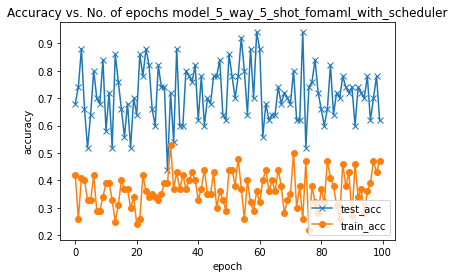

In [10]:
plot_accuracies(history8,'model_5_way_5_shot_fomaml_with_scheduler')

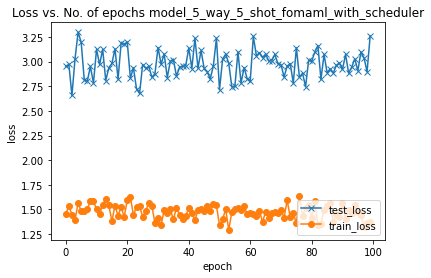

In [11]:
plot_losses(history8,'model_5_way_5_shot_fomaml_with_scheduler')

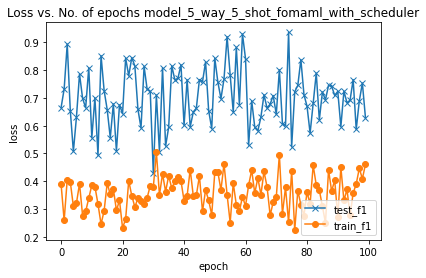

In [12]:
plot_f1(history8,'model_5_way_5_shot_fomaml_with_scheduler')

In [ ]:
test_F_maml_8 = test_F_maml(model_5_way_5_shot_fomaml_with_scheduler,10,5,5,5,10)

val_loss : 1.87 val_acc : 0.4700 val_F1: 0.4524
val_loss : 1.92 val_acc : 0.4050 val_F1: 0.3948
val_loss : 1.90 val_acc : 0.4400 val_F1: 0.4233
val_loss : 1.90 val_acc : 0.4250 val_F1: 0.4238
val_loss : 1.90 val_acc : 0.4250 val_F1: 0.4197
val_loss : 1.82 val_acc : 0.4450 val_F1: 0.4354
val_loss : 1.88 val_acc : 0.4450 val_F1: 0.4405
val_loss : 1.94 val_acc : 0.3650 val_F1: 0.3640
val_loss : 1.87 val_acc : 0.4700 val_F1: 0.4622
val_loss : 1.81 val_acc : 0.5050 val_F1: 0.4972


In [ ]:
print("model_5_way_5_shot_fomaml_with_scheduler test :")
print(f"loss : {test_F_maml_8[0]:.2f}   acc: {test_F_maml_8[1]:.2f}  f1 : {test_F_maml_8[2]:.2f} ")

model_5_way_5_shot_fomaml_with_scheduler test :
loss : 1.88   acc: 0.44  f1 : 0.43 


In [ ]:
import pandas as pd

lsot = [test_F_maml_1[0]
        ,test_F_maml_2[0]
        ,test_F_maml_3[0]
        ,test_F_maml_4[0]
        ,test_F_maml_5[0]
        ,test_F_maml_6[0]
        ,test_F_maml_7[0]
        ,test_F_maml_8[0]]

acc = [test_F_maml_1[1].item(),
       test_F_maml_2[1].item(),
       test_F_maml_3[1].item(),
       test_F_maml_4[1].item(),
        test_F_maml_5[1].item(),
       test_F_maml_6[1].item(),
       test_F_maml_7[1].item(),
       test_F_maml_8[1].item()]


f1 = [test_F_maml_1[2].item(),
      test_F_maml_2[2].item(),
      test_F_maml_3[2].item(),
      test_F_maml_4[2].item(),
      test_F_maml_5[2].item(),
      test_F_maml_6[2].item(),
      test_F_maml_7[2].item(),
      test_F_maml_8[2].item()]

name = ['model_5_way_shot_1_maml',
        'model_5_way_5_shot_maml',
        'model_5_way_1_shot_fomaml',
        'model_5_way_5_shot_fomaml',
        'model_5_way_1_shot_maml_with_scheduler',
        'model_5_way_5_shot_maml_with_scheduler',
        'model_5_way_1_shot_fomaml_with_scheduler',
        'model_5_way_5_shot_fomaml_with_scheduler']

d ={'name':name,'loss': lsot, 'acc': acc,'f1':f1}
df = pd.DataFrame(data=d)
df.head(10)

name      loss     acc        f1
0                   model_5_way_shot_1_maml  2.028873  0.3550  0.332438
1                   model_5_way_5_shot_maml  1.845626  0.4475  0.436394
2                 model_5_way_1_shot_fomaml  1.999163  0.3565  0.334361
3                 model_5_way_5_shot_fomaml  1.807084  0.4745  0.467698
4    model_5_way_1_shot_maml_with_scheduler  2.028186  0.3290  0.299164
5    model_5_way_5_shot_maml_with_scheduler  1.866307  0.4470  0.437437
6  model_5_way_1_shot_fomaml_with_scheduler  2.039116  0.3370  0.312835
7  model_5_way_5_shot_fomaml_with_scheduler  1.882448  0.4395  0.431333

In [ ]:
df.to_csv('compare each model')

In [ ]:
one_model = joblib.load('model_5_way_shot_1_maml')

In [ ]:
test_job_lib = test_F_maml(one_model,10,5,5,1,10)

val_loss : 2.05 val_acc : 0.2950 val_F1: 0.2665
val_loss : 2.10 val_acc : 0.2600 val_F1: 0.2365
val_loss : 2.10 val_acc : 0.3200 val_F1: 0.2921
val_loss : 2.04 val_acc : 0.3250 val_F1: 0.2868
val_loss : 2.06 val_acc : 0.3250 val_F1: 0.3033
val_loss : 2.05 val_acc : 0.3050 val_F1: 0.2801
val_loss : 2.06 val_acc : 0.3300 val_F1: 0.2906
val_loss : 2.03 val_acc : 0.3450 val_F1: 0.3097
val_loss : 2.02 val_acc : 0.3250 val_F1: 0.2970
val_loss : 2.10 val_acc : 0.2800 val_F1: 0.2589
